In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import os
from collections import OrderedDict
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met, u_interpolate as u_int
import pandas as pd
from metpy.calc import kinematics

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd .. 

/home/ck/pythonWorkspace/proj_CEH


In [72]:
def read_pdf(path, res):
    
    pdf = pkl.load(open (path, 'rb'))
  
    pdf = pdf.where((pdf.clat>=5) & (pdf.area*res**2>=10000) & (pdf.area*res**2<=150000) & (pdf.clat<=8.5) &
                    (pdf.clon>=-10) & (pdf.clon<=8.5) & ((pdf.month<=5) | (pdf.month>=10)))
    pdf = pdf.dropna()

    pdf.tmin = np.array(pdf.tmin, dtype=float)
    pdf.tmean = np.array(pdf.tmean, dtype=float)
    pdf['70area'] = np.array(pdf['70area'], dtype=int)
    
    return pdf
    

In [73]:
pdf = read_pdf(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 7.7)

In [74]:
pdf_cp4 = read_pdf(cnst.CLOVER_SAVES + 'StormLoc_CP4hist_-50_5000km_WA.p', 4.4)

In [75]:
pdf_cp4

,month,tmin,year,t90,minlon,area,maxlon,date,tmean,clon,clat,t10,70area,minlat,maxlat
1997-03-01_18:30:00_11,3.0,-73.240921,1997.0,-70.874219,-6.416779,533.0,-5.120758,1997-03-01 18:30:00,-63.056557,-5.768768,5.889750,-70.874219,72,5.322750,6.456749
1997-03-01_18:30:00_15,3.0,-65.754227,1997.0,-61.627420,-4.472778,1035.0,-2.650269,1997-03-01 18:30:00,-55.819180,-3.561523,7.104752,-61.627420,0,6.213753,7.995750
1997-03-01_18:30:00_16,3.0,-76.062958,1997.0,-71.286008,0.589722,608.0,1.804749,1997-03-01 18:30:00,-61.508575,1.197235,7.185749,-71.286008,89,6.456749,7.914749
1997-03-03_18:30:00_16,3.0,-60.016464,1997.0,-56.174280,7.960724,563.0,8.811218,1997-03-03 18:30:00,-53.583546,8.385971,5.262001,-56.174280,0,4.391251,6.132751
1997-03-03_18:30:00_18,3.0,-74.009720,1997.0,-70.342149,-8.887268,1120.0,-7.024261,1997-03-03 18:30:00,-61.284416,-7.955765,5.424002,-70.342149,122,4.634251,6.213753
1997-03-03_18:30:00_22,3.0,-76.229050,1997.0,-71.179968,-4.432251,4272.0,0.346741,1997-03-03 18:30:00,-62.728443,-2.042755,6.396000,-71.179968,717,5.120251,7.671749
1997-03-03_18:30:00_23,3.0,-73.055908,1997.0,-67.096106,4.072723,1347.0,6.543243,1997-03-03 18:30:00,-59.349091,5.307983,6.355501,-67.096106,77,5.322750,7.388252
1997-03-03_18:30:00_40,3.0,-68.954712,1997.0,-67.045175,0.427734,737.0,1.561737,1997-03-03 18:30:00,-60.092957,0.994736,8.177999,-67.045175,0,7.428749,8.927250
1997-03-04_18:30:00_15,3.0,-69.824539,1997.0,-61.887141,5.125732,1338.0,7.312744,1997-03-04 18:30:00,-55.937756,6.219238,5.748001,-61.887141,0,4.472252,7.023750
1997-03-04_18:30:00_19,3.0,-75.220184,1997.0,-69.777840,-3.136261,2616.0,-0.017761,1997-03-04 18:30:00,-62.974472,-1.577011,6.072001,-69.777840,240,4.958252,7.185749


In [76]:
tfile = xr.open_dataset('/home/ck/DIR/cornkle/data/CP4/CLOVER/CP4hist/t2/t2_A1hr_inst_ac144_4km_199703250100-199703260000.nc')

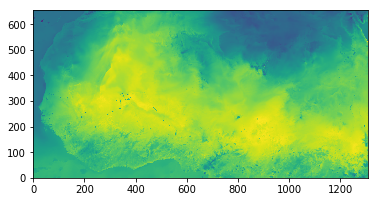

In [77]:
plt.imshow(tfile['t2'].isel(time=1), origin='lower')

In [78]:
tarray = tfile['t2'].isel(time=1)

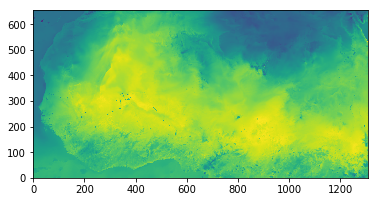

In [79]:
plt.imshow(tarray, origin='lower')

In [80]:
for index, storm in pdf_cp4.iterrows():
    
        elat = storm.clat
        elon = storm.clon

        point = tarray.sel(latitude=elat, longitude=elon, method='nearest')
        plat = point['latitude'].values
        plon = point['longitude'].values
        
        xpos = np.where(tarray['longitude'].values == plon)
        xpos = int(xpos[0])
        ypos = np.where(tarray['latitude'].values == plat)
        ypos = int(ypos[0])
        tarray.values[ypos, xpos] += -10

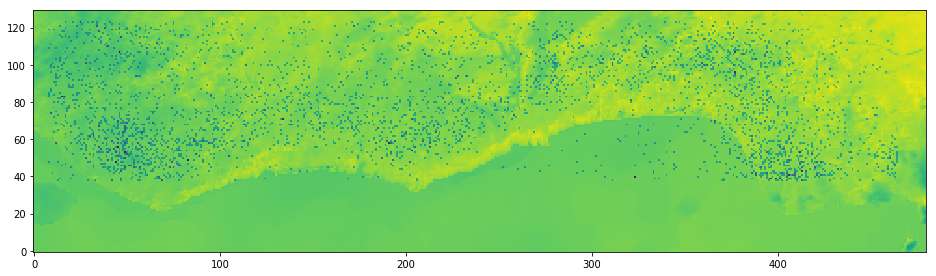

In [83]:
f = plt.figure(figsize=(16,5))
plt.imshow(tarray[0:130,190:670], origin='lower', cmap='viridis')

In [84]:
era = xr.open_dataset(cnst.ERA_DAILY_PL12UTC)
era = uda.flip_lat(era)
#era = era.sel(latitude=slice(-10,25), longitude=slice(-20,25))

In [85]:
clim = era.resample(time='M').mean('time')

In [11]:
# get era box from GRIDSAT storm centre point
def get_ERA(era, indic, clim):
    
    ano = None
    out_ds = None
    out_clim = None
    out_strong = None
    out_weak = None
    cnt = None
    cnt_strong = None
    cnt_weak = None
  
    for ids, date in enumerate(indic.date):
        
        print(date)

        getera =np.where((era['time.day']==(indic['date'])[ids].day) & (era['time.month']==indic.month[ids]) & (era['time.year']==indic.year[ids]))
        #ipdb.set_trace()
        getclim = np.where((clim['time.month']==indic.month[ids]) & (clim['time.year']==indic.year[ids]))
        try:
            era_day = era.isel(time=int(getera[0]))
            
        except TypeError:
            print('Era missing')
            continue
            
        clim_day = clim.isel(time=int(getclim[0]))
            
        tmean = indic.tmin[ids]
      
        elat = indic.clat[ids]
        elon = indic.clon[ids]
        
        print(elat,elon)
        
        point = era_day.sel(latitude=elat, longitude=elon, method='nearest')
        plat = point['latitude'].values
        plon = point['longitude'].values

        xpos = np.where(era_day['longitude'].values == plon)
        xpos = int(xpos[0])
        ypos = np.where(era_day['latitude'].values == plat)
        ypos = int(ypos[0])
        
        point = clim_day.sel(latitude=elat, longitude=elon, method='nearest')
        plat = point['latitude'].values
        plon = point['longitude'].values
        
        cxpos = np.where(clim_day['longitude'].values == plon)
        cxpos = int(cxpos[0])
        cypos = np.where(clim_day['latitude'].values == plat)
        cypos = int(cypos[0])
        
        print(ypos,xpos)

        dist=5 # ca 200km i.e. 45 *4.4km
        
        ds_box = era_day.apply(uda.cut_box, xpos=xpos, ypos=ypos, dist=dist)           
        ds_clim = clim_day.apply(uda.cut_box, xpos=cxpos, ypos=cypos, dist=dist)
        
#         f = plt.figure()
#         plt.pcolormesh(ds_box['t'])

        names = list(ds_box.data_vars)
    
#         if np.sum(np.isnan(ds_box['t'].values)!=0):
#             ipdb.set_trace()
    
#         if (ypos, xpos) == (5,20):
#             ipdb.set_trace()
       
        if cnt is None:
            cnt = np.zeros_like(ds_box[names[0]].values)
            cnt[np.isfinite(ds_box[names[0]].values)] = 1
        else:
            cnt[np.isfinite(ds_box[names[0]].values)] += 1 
            
        if tmean >= np.percentile(indic.tmean, 90):
            if cnt_weak is None:
                cnt_weak = np.zeros_like(ds_box[names[0]].values)
                cnt_weak[np.isfinite(ds_box[names[0]].values)] = 1
            else:
                
                cnt_weak[np.isfinite(ds_box[names[0]].values)] += 1 

        if tmean <= np.percentile(indic.tmean, 10):
            if cnt_strong is None:
                cnt_strong = np.zeros_like(ds_box[names[0]].values)
                cnt_strong[np.isfinite(ds_box[names[0]].values)] = 1
            else:
                cnt_strong[np.isfinite(ds_box[names[0]].values)] += 1 
                
            
        for d in ds_box.data_vars:
            ds_box[d].values[np.isnan(ds_box[d].values)]=0
        
        for d in ds_clim.data_vars:
             ds_clim[d].values[np.isnan(ds_clim[d].values)]=0
        
            
        if out_ds is None:      
            out_ds = ds_box.copy(deep=True)
        else:
            out_ds += ds_box

        if out_clim is None:      
            out_clim = ds_clim.copy(deep=True)
        else:
            out_clim += ds_clim
            
        if tmean <= np.percentile(indic.tmean, 10):           
            if out_strong is None:
                out_strong = ds_box.copy(deep=True)
            else:
                out_strong += ds_box
            
        if tmean >= np.percentile(indic.tmean, 90):
            
            if out_weak is None:
                out_weak = ds_box.copy(deep=True)
            else:
                #ipdb.set_trace()
                out_weak += ds_box
            
        
    return out_ds, out_clim, cnt, out_weak, out_strong, cnt_weak, cnt_strong

In [91]:
def get_CP4(cp_dir, out_dir, ancils_dir, vars, datestring, box, tthresh, indic):

    keys = vars.keys()

    if 'lw_out_PBLtop' not in keys:
        print('please provide ORL first in dictionary')
        return
    
    indic_day = indic.where(indic.date == datestring).dropna()

    #load seamask
    landsea_path = glob.glob(ancils_dir+os.sep+'landseamask*.nc')[0]
    landsea = xr.open_dataset(landsea_path, decode_times=False)
    ls = landsea['lsm']

    ls.rlon.values = ls.rlon.values-360
    ls_arr = ls.sel(rlon=slice(box[0], box[1]), rlat=slice(box[2], box[3]))
    pos = np.where(ls_arr[0, 0, :, :] == 0)
    lons, lats = np.meshgrid(ls_arr.rlon.values, ls_arr.rlat.values)
    goodinds = 0

    #create empty dataset
    ds = xr.Dataset()
    # create empty

    #loop through every var
    for v in keys:

        h = (vars[v])[1]
        pl = (vars[v])[0]
        derived = False
        if (v == 'shear') | (v == 'u_mid') | (v == 'u_srfc'):
            derived = v
            v = 'u_pl'


        filepath = cp_dir+os.sep+str(v)+os.sep+'*'+str(int(indic_day.year[0]))+ str(int(indic_day.month[0])).zfill(2)+'*.nc'

        arr = xr.open_mfdataset(filepath, autoclose=True)

        dar = arr[v].sel(longitude=slice(box[0],box[1]), latitude=slice(box[2],box[3]))
        
        pdt = pd.to_datetime(datestring)
        pdt = pdt.replace(hour=h)
        dar = dar.sel(time=pdt, method='nearest')
      
        if int(dar['time.hour'])!=h:
            print('Wrong hour')
            return

        if 'pressure' in dar.coords:
            
            if (np.sum(dar.values) == 0) | np.sum(np.isfinite(dar.values) == 0):
                return
            
            dar.values[dar.values==0] = np.nan # potential missing value maskout
            if len(pl) > 1:
                shear = dar.sel(pressure=pl[0]).values - dar.sel(pressure=pl[1]).values
                dar = dar.sum(dim='pressure').squeeze()
                dar.values = shear
                if derived:
                    v = derived

            else:
                dar = dar.sel(pressure=pl[0]).squeeze()
            if derived:
                v = derived

        # regrid to common grid (unstagger wind, bring to landsea mask grid)
        regrid = u_int.griddata_int(dar.values, dar.longitude, dar.latitude, ls_arr.rlon, ls_arr.rlat)
        da = xr.DataArray(regrid,
                          coords={'time': dar.time, 'latitude': ls_arr.rlat.values,
                                  'longitude': ls_arr.rlon.values, },
                          dims=['latitude', 'longitude'])


        da.attrs = dar.attrs
        da.values[pos[0], pos[1]] = np.nan  # mask sea

        if v == 'lw_out_PBLtop':

            da.values = u_met.olr_to_bt(da.values)
            da.values[da.values >= tthresh] = 0  # T threshold maskout
            da.values[np.isnan(da.values)] = 0 # set ocean nans to 0

            try:
                date = da.time.values[0]
            except IndexError:
                date = da.time.values

        if (v == 'lsRain') | (v == 'totRain'):
            da.values = da.values*3600  # rain to mm/h
            da.attrs['units'] = 'mm h-1'

        ds[v] = da

        print('Saved ', v)

    for index, storm in indic_day.iterrows():

        elat = storm.clat
        elon = storm.clon

        dbox = ds.copy(deep=True)

        point = dbox.sel(latitude=elat, longitude=elon, method='nearest')
        plat = point['latitude'].values
        plon = point['longitude'].values

        xpos = np.where(dbox['longitude'].values == plon)
        xpos = int(xpos[0])
        ypos = np.where(dbox['latitude'].values == plat)
        ypos = int(ypos[0])

        dist=57 # ca 400km i.e. 91 *4.4km, 250km is 57*4.4
        
        ds_box = dbox.apply(uda.cut_box, xpos=xpos, ypos=ypos, dist=dist)  
        
        if np.sum(np.isfinite(ds_box['lw_out_PBLtop'].values)) <= 10:
            return
 
        savefile = out_dir + os.sep + str(storm.name) + '.nc'
        try:
            os.remove(savefile)
        except OSError:
            pass
        
        for s in storm.keys():
            #ipdb.set_trace()
            if s == 'date':
                continue
            ds_box.attrs[s] = storm[s]
        
        ds_box.to_netcdf(path=savefile, mode='w')
        print('Saved ' + savefile)


        print('Saved MCS no.'+str(storm.name)+ ' as netcdf.')



### Inputs CP25

data_path = cnst.network_data + 'data/CP4/CLOVER/CP4hist'  # CP4 data directory
ancils_path = cnst.network_data + 'data/CP4/ANCILS' # directory with seamask file inside
out_path = cnst.network_data + 'data/CP4/CLOVER/COMP4_-50_5000km2'  # out directory to save MCS files
sbox = [-11, 11, 4.5, 8.5]  # W- E , S - N geographical storm box
datestring = '19990401'  # set this to date of file

years = np.array(np.arange(1998,2007), dtype=str)
months = np.array([ '03', '04', '05', '09', '10', '11'])
days = np.array(np.arange(1,32), dtype=str)

tthresh = -50 # chosen temperature threshold, e.g. -50, -60, -70

vars = OrderedDict()   # dictionary which contains info on pressure level and hour extraction for wanted variables
vars['lw_out_PBLtop'] = ([], 18)
vars['lsRain'] =  ([], 18)   # pressure levels, hour # totRain for CP25, lsRain for CP
vars['shear'] = ([650, 925], 12) # should use 925 later
vars['u_mid'] = ([650], 12)
vars['u_srfc'] = ([925], 12)
vars['q_pl'] = ([925], 12)  # 925, 650 available
datelist = []
# for y,m,d in itertools.product(years, months, days):
#     datelist.append(y+m+str(d).zfill(2))
# files = glob.glob(data_path+os.sep+'lw_out_PBLtop'+os.sep+'*.nc')

#dummy = xr.open_mfdataset(data_path+os.sep+'lw_out_PBLtop'+os.sep+'*.nc', autoclose=True)

time = np.unique(pdf_cp4.date)
time = time[25::]
for d in time:
    get_CP4(data_path, out_path, ancils_path, vars, d, sbox, tthresh, pdf_cp4)

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-01_18:30:00_18.nc
Saved MCS no.1997-10-01_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-01_18:30:00_21.nc
Saved MCS no.1997-10-01_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-03_18:30:00_22.nc
Saved MCS no.1997-10-03_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-05_18:30:00_22.nc
Saved MCS no.1997-10-05_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-05_18:30:00_9.nc
Saved MCS no.1997-10-05_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-07_18:30:00_6.nc
Saved MCS no.1997-10-07_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-08_18:30:00_5.nc
Saved MCS no.1997-10-08_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-09_18:30:00_11.nc
Saved MCS no.1997-10-09_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-09_18:30:00_20.nc
Saved MCS no.1997-10-09_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-10_18:30:00_15.nc
Saved MCS no.1997-10-10_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-12_18:30:00_29.nc
Saved MCS no.1997-10-12_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-12_18:30:00_45.nc
Saved MCS no.1997-10-12_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-16_18:30:00_22.nc
Saved MCS no.1997-10-16_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-16_18:30:00_28.nc
Saved MCS no.1997-10-16_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-17_18:30:00_12.nc
Saved MCS no.1997-10-17_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-17_18:30:00_16.nc
Saved MCS no.1997-10-17_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-17_18:30:00_18.nc
Saved MCS no.1997-10-17_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-17_18:30:00_4.nc
Saved MCS no.1997-10-17_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-18_18:30:00_5.nc
Saved MCS no.1997-10-18_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-19_18:30:00_12.nc
Saved MCS no.1997-10-19_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-19_18:30:00_8.nc
Saved MCS no.1997-10-19_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-20_18:30:00_36.nc
Saved MCS no.1997-10-20_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-20_18:30:00_38.nc
Saved MCS no.1997-10-20_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-20_18:30:00_9.nc
Saved MCS no.1997-10-20_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-21_18:30:00_14.nc
Saved MCS no.1997-10-21_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-21_18:30:00_26.nc
Saved MCS no.1997-10-21_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-21_18:30:00_8.nc
Saved MCS no.1997-10-21_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-22_18:30:00_42.nc
Saved MCS no.1997-10-22_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-22_18:30:00_46.nc
Saved MCS no.1997-10-22_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-23_18:30:00_31.nc
Saved MCS no.1997-10-23_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-23_18:30:00_36.nc
Saved MCS no.1997-10-23_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-23_18:30:00_52.nc
Saved MCS no.1997-10-23_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-24_18:30:00_17.nc
Saved MCS no.1997-10-24_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-24_18:30:00_24.nc
Saved MCS no.1997-10-24_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-24_18:30:00_44.nc
Saved MCS no.1997-10-24_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-24_18:30:00_50.nc
Saved MCS no.1997-10-24_18:30:00_50 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-24_18:30:00_8.nc
Saved MCS no.1997-10-24_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-25_18:30:00_48.nc
Saved MCS no.1997-10-25_18:30:00_48 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-26_18:30:00_31.nc
Saved MCS no.1997-10-26_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-26_18:30:00_35.nc
Saved MCS no.1997-10-26_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-26_18:30:00_60.nc
Saved MCS no.1997-10-26_18:30:00_60 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-27_18:30:00_12.nc
Saved MCS no.1997-10-27_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-27_18:30:00_18.nc
Saved MCS no.1997-10-27_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-28_18:30:00_10.nc
Saved MCS no.1997-10-28_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-29_18:30:00_4.nc
Saved MCS no.1997-10-29_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-29_18:30:00_42.nc
Saved MCS no.1997-10-29_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-30_18:30:00_10.nc
Saved MCS no.1997-10-30_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-30_18:30:00_19.nc
Saved MCS no.1997-10-30_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-30_18:30:00_24.nc
Saved MCS no.1997-10-30_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-30_18:30:00_44.nc
Saved MCS no.1997-10-30_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-30_18:30:00_5.nc
Saved MCS no.1997-10-30_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-10-30_18:30:00_8.nc
Saved MCS no.1997-10-30_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-01_18:30:00_19.nc
Saved MCS no.1997-11-01_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-01_18:30:00_36.nc
Saved MCS no.1997-11-01_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-01_18:30:00_44.nc
Saved MCS no.1997-11-01_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-01_18:30:00_63.nc
Saved MCS no.1997-11-01_18:30:00_63 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-01_18:30:00_68.nc
Saved MCS no.1997-11-01_18:30:00_68 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-02_18:30:00_24.nc
Saved MCS no.1997-11-02_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-02_18:30:00_61.nc
Saved MCS no.1997-11-02_18:30:00_61 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-02_18:30:00_69.nc
Saved MCS no.1997-11-02_18:30:00_69 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-02_18:30:00_86.nc
Saved MCS no.1997-11-02_18:30:00_86 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-03_18:30:00_36.nc
Saved MCS no.1997-11-03_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-03_18:30:00_55.nc
Saved MCS no.1997-11-03_18:30:00_55 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-04_18:30:00_46.nc
Saved MCS no.1997-11-04_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-04_18:30:00_61.nc
Saved MCS no.1997-11-04_18:30:00_61 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-05_18:30:00_14.nc
Saved MCS no.1997-11-05_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-05_18:30:00_33.nc
Saved MCS no.1997-11-05_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-05_18:30:00_46.nc
Saved MCS no.1997-11-05_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-05_18:30:00_64.nc
Saved MCS no.1997-11-05_18:30:00_64 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-06_18:30:00_35.nc
Saved MCS no.1997-11-06_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-07_18:30:00_21.nc
Saved MCS no.1997-11-07_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-08_18:30:00_11.nc
Saved MCS no.1997-11-08_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-08_18:30:00_29.nc
Saved MCS no.1997-11-08_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-08_18:30:00_43.nc
Saved MCS no.1997-11-08_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-09_18:30:00_12.nc
Saved MCS no.1997-11-09_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-09_18:30:00_19.nc
Saved MCS no.1997-11-09_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-09_18:30:00_50.nc
Saved MCS no.1997-11-09_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-11_18:30:00_13.nc
Saved MCS no.1997-11-11_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-11_18:30:00_17.nc
Saved MCS no.1997-11-11_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-11_18:30:00_31.nc
Saved MCS no.1997-11-11_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-11_18:30:00_32.nc
Saved MCS no.1997-11-11_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-11_18:30:00_40.nc
Saved MCS no.1997-11-11_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-11_18:30:00_6.nc
Saved MCS no.1997-11-11_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-12_18:30:00_36.nc
Saved MCS no.1997-11-12_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-13_18:30:00_18.nc
Saved MCS no.1997-11-13_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-13_18:30:00_41.nc
Saved MCS no.1997-11-13_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-13_18:30:00_44.nc
Saved MCS no.1997-11-13_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-14_18:30:00_15.nc
Saved MCS no.1997-11-14_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-14_18:30:00_22.nc
Saved MCS no.1997-11-14_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-14_18:30:00_23.nc
Saved MCS no.1997-11-14_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-14_18:30:00_29.nc
Saved MCS no.1997-11-14_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-15_18:30:00_10.nc
Saved MCS no.1997-11-15_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-15_18:30:00_20.nc
Saved MCS no.1997-11-15_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-15_18:30:00_38.nc
Saved MCS no.1997-11-15_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-15_18:30:00_6.nc
Saved MCS no.1997-11-15_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-16_18:30:00_14.nc
Saved MCS no.1997-11-16_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-16_18:30:00_36.nc
Saved MCS no.1997-11-16_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-16_18:30:00_41.nc
Saved MCS no.1997-11-16_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-16_18:30:00_8.nc
Saved MCS no.1997-11-16_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-17_18:30:00_36.nc
Saved MCS no.1997-11-17_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-17_18:30:00_37.nc
Saved MCS no.1997-11-17_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-17_18:30:00_6.nc
Saved MCS no.1997-11-17_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-17_18:30:00_7.nc
Saved MCS no.1997-11-17_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-18_18:30:00_7.nc
Saved MCS no.1997-11-18_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-19_18:30:00_1.nc
Saved MCS no.1997-11-19_18:30:00_1 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-19_18:30:00_7.nc
Saved MCS no.1997-11-19_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-22_18:30:00_15.nc
Saved MCS no.1997-11-22_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-23_18:30:00_11.nc
Saved MCS no.1997-11-23_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-23_18:30:00_12.nc
Saved MCS no.1997-11-23_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-24_18:30:00_11.nc
Saved MCS no.1997-11-24_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-24_18:30:00_12.nc
Saved MCS no.1997-11-24_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-24_18:30:00_13.nc
Saved MCS no.1997-11-24_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-24_18:30:00_19.nc
Saved MCS no.1997-11-24_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-25_18:30:00_10.nc
Saved MCS no.1997-11-25_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-25_18:30:00_16.nc
Saved MCS no.1997-11-25_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-25_18:30:00_22.nc
Saved MCS no.1997-11-25_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-26_18:30:00_27.nc
Saved MCS no.1997-11-26_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-26_18:30:00_51.nc
Saved MCS no.1997-11-26_18:30:00_51 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-28_18:30:00_10.nc
Saved MCS no.1997-11-28_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-28_18:30:00_11.nc
Saved MCS no.1997-11-28_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-28_18:30:00_14.nc
Saved MCS no.1997-11-28_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-29_18:30:00_10.nc
Saved MCS no.1997-11-29_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1997-11-29_18:30:00_7.nc
Saved MCS no.1997-11-29_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-11_18:30:00_6.nc
Saved MCS no.1998-03-11_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-12_18:30:00_12.nc
Saved MCS no.1998-03-12_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-13_18:30:00_12.nc
Saved MCS no.1998-03-13_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-13_18:30:00_8.nc
Saved MCS no.1998-03-13_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-14_18:30:00_11.nc
Saved MCS no.1998-03-14_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-14_18:30:00_27.nc
Saved MCS no.1998-03-14_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-15_18:30:00_12.nc
Saved MCS no.1998-03-15_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-15_18:30:00_13.nc
Saved MCS no.1998-03-15_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-15_18:30:00_5.nc
Saved MCS no.1998-03-15_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-16_18:30:00_10.nc
Saved MCS no.1998-03-16_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-16_18:30:00_16.nc
Saved MCS no.1998-03-16_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-17_18:30:00_5.nc
Saved MCS no.1998-03-17_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-17_18:30:00_6.nc
Saved MCS no.1998-03-17_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-18_18:30:00_7.nc
Saved MCS no.1998-03-18_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-19_18:30:00_5.nc
Saved MCS no.1998-03-19_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-20_18:30:00_7.nc
Saved MCS no.1998-03-20_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-21_18:30:00_12.nc
Saved MCS no.1998-03-21_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-22_18:30:00_14.nc
Saved MCS no.1998-03-22_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-22_18:30:00_9.nc
Saved MCS no.1998-03-22_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-25_18:30:00_14.nc
Saved MCS no.1998-03-25_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-25_18:30:00_21.nc
Saved MCS no.1998-03-25_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-25_18:30:00_9.nc
Saved MCS no.1998-03-25_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-26_18:30:00_11.nc
Saved MCS no.1998-03-26_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-27_18:30:00_3.nc
Saved MCS no.1998-03-27_18:30:00_3 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-28_18:30:00_11.nc
Saved MCS no.1998-03-28_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-29_18:30:00_12.nc
Saved MCS no.1998-03-29_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-29_18:30:00_17.nc
Saved MCS no.1998-03-29_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-29_18:30:00_29.nc
Saved MCS no.1998-03-29_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-29_18:30:00_30.nc
Saved MCS no.1998-03-29_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-29_18:30:00_7.nc
Saved MCS no.1998-03-29_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-30_18:30:00_12.nc
Saved MCS no.1998-03-30_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-30_18:30:00_19.nc
Saved MCS no.1998-03-30_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-03-30_18:30:00_5.nc
Saved MCS no.1998-03-30_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-01_18:30:00_41.nc
Saved MCS no.1998-04-01_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-01_18:30:00_43.nc
Saved MCS no.1998-04-01_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-02_18:30:00_12.nc
Saved MCS no.1998-04-02_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-02_18:30:00_16.nc
Saved MCS no.1998-04-02_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-02_18:30:00_22.nc
Saved MCS no.1998-04-02_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-02_18:30:00_26.nc
Saved MCS no.1998-04-02_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-03_18:30:00_14.nc
Saved MCS no.1998-04-03_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-03_18:30:00_19.nc
Saved MCS no.1998-04-03_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-03_18:30:00_25.nc
Saved MCS no.1998-04-03_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-03_18:30:00_34.nc
Saved MCS no.1998-04-03_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-03_18:30:00_7.nc
Saved MCS no.1998-04-03_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-04_18:30:00_21.nc
Saved MCS no.1998-04-04_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-04_18:30:00_32.nc
Saved MCS no.1998-04-04_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-05_18:30:00_22.nc
Saved MCS no.1998-04-05_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-05_18:30:00_37.nc
Saved MCS no.1998-04-05_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-06_18:30:00_20.nc
Saved MCS no.1998-04-06_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-06_18:30:00_33.nc
Saved MCS no.1998-04-06_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-07_18:30:00_15.nc
Saved MCS no.1998-04-07_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-07_18:30:00_7.nc
Saved MCS no.1998-04-07_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-08_18:30:00_27.nc
Saved MCS no.1998-04-08_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-10_18:30:00_7.nc
Saved MCS no.1998-04-10_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-11_18:30:00_7.nc
Saved MCS no.1998-04-11_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-12_18:30:00_19.nc
Saved MCS no.1998-04-12_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-12_18:30:00_9.nc
Saved MCS no.1998-04-12_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-13_18:30:00_18.nc
Saved MCS no.1998-04-13_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-13_18:30:00_7.nc
Saved MCS no.1998-04-13_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-14_18:30:00_20.nc
Saved MCS no.1998-04-14_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-14_18:30:00_22.nc
Saved MCS no.1998-04-14_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-14_18:30:00_41.nc
Saved MCS no.1998-04-14_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-14_18:30:00_42.nc
Saved MCS no.1998-04-14_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-15_18:30:00_13.nc
Saved MCS no.1998-04-15_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-15_18:30:00_16.nc
Saved MCS no.1998-04-15_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-15_18:30:00_20.nc
Saved MCS no.1998-04-15_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-15_18:30:00_25.nc
Saved MCS no.1998-04-15_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-15_18:30:00_28.nc
Saved MCS no.1998-04-15_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-15_18:30:00_33.nc
Saved MCS no.1998-04-15_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-16_18:30:00_16.nc
Saved MCS no.1998-04-16_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-16_18:30:00_18.nc
Saved MCS no.1998-04-16_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-16_18:30:00_21.nc
Saved MCS no.1998-04-16_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-16_18:30:00_26.nc
Saved MCS no.1998-04-16_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-16_18:30:00_39.nc
Saved MCS no.1998-04-16_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-17_18:30:00_32.nc
Saved MCS no.1998-04-17_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-17_18:30:00_46.nc
Saved MCS no.1998-04-17_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-17_18:30:00_53.nc
Saved MCS no.1998-04-17_18:30:00_53 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-17_18:30:00_6.nc
Saved MCS no.1998-04-17_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-18_18:30:00_31.nc
Saved MCS no.1998-04-18_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-18_18:30:00_42.nc
Saved MCS no.1998-04-18_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-18_18:30:00_43.nc
Saved MCS no.1998-04-18_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-18_18:30:00_46.nc
Saved MCS no.1998-04-18_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-18_18:30:00_6.nc
Saved MCS no.1998-04-18_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-19_18:30:00_16.nc
Saved MCS no.1998-04-19_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-19_18:30:00_18.nc
Saved MCS no.1998-04-19_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-20_18:30:00_15.nc
Saved MCS no.1998-04-20_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-20_18:30:00_29.nc
Saved MCS no.1998-04-20_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-20_18:30:00_37.nc
Saved MCS no.1998-04-20_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-21_18:30:00_13.nc
Saved MCS no.1998-04-21_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-21_18:30:00_15.nc
Saved MCS no.1998-04-21_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-21_18:30:00_17.nc
Saved MCS no.1998-04-21_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-21_18:30:00_19.nc
Saved MCS no.1998-04-21_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-21_18:30:00_4.nc
Saved MCS no.1998-04-21_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-21_18:30:00_8.nc
Saved MCS no.1998-04-21_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-22_18:30:00_37.nc
Saved MCS no.1998-04-22_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-22_18:30:00_38.nc
Saved MCS no.1998-04-22_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-22_18:30:00_51.nc
Saved MCS no.1998-04-22_18:30:00_51 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-23_18:30:00_13.nc
Saved MCS no.1998-04-23_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-23_18:30:00_24.nc
Saved MCS no.1998-04-23_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-23_18:30:00_27.nc
Saved MCS no.1998-04-23_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-24_18:30:00_46.nc
Saved MCS no.1998-04-24_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-25_18:30:00_13.nc
Saved MCS no.1998-04-25_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-25_18:30:00_18.nc
Saved MCS no.1998-04-25_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-25_18:30:00_35.nc
Saved MCS no.1998-04-25_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-25_18:30:00_43.nc
Saved MCS no.1998-04-25_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-25_18:30:00_7.nc
Saved MCS no.1998-04-25_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-26_18:30:00_10.nc
Saved MCS no.1998-04-26_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-26_18:30:00_21.nc
Saved MCS no.1998-04-26_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-26_18:30:00_29.nc
Saved MCS no.1998-04-26_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-26_18:30:00_34.nc
Saved MCS no.1998-04-26_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-26_18:30:00_35.nc
Saved MCS no.1998-04-26_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-29_18:30:00_11.nc
Saved MCS no.1998-04-29_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-29_18:30:00_26.nc
Saved MCS no.1998-04-29_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-30_18:30:00_25.nc
Saved MCS no.1998-04-30_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-04-30_18:30:00_26.nc
Saved MCS no.1998-04-30_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-01_18:30:00_25.nc
Saved MCS no.1998-05-01_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-01_18:30:00_31.nc
Saved MCS no.1998-05-01_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-01_18:30:00_41.nc
Saved MCS no.1998-05-01_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-01_18:30:00_49.nc
Saved MCS no.1998-05-01_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-02_18:30:00_40.nc
Saved MCS no.1998-05-02_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-03_18:30:00_17.nc
Saved MCS no.1998-05-03_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-03_18:30:00_27.nc
Saved MCS no.1998-05-03_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-03_18:30:00_34.nc
Saved MCS no.1998-05-03_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-03_18:30:00_35.nc
Saved MCS no.1998-05-03_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-04_18:30:00_13.nc
Saved MCS no.1998-05-04_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-04_18:30:00_19.nc
Saved MCS no.1998-05-04_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-04_18:30:00_20.nc
Saved MCS no.1998-05-04_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-05_18:30:00_52.nc
Saved MCS no.1998-05-05_18:30:00_52 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-05_18:30:00_71.nc
Saved MCS no.1998-05-05_18:30:00_71 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-06_18:30:00_12.nc
Saved MCS no.1998-05-06_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-06_18:30:00_21.nc
Saved MCS no.1998-05-06_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-06_18:30:00_26.nc
Saved MCS no.1998-05-06_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-06_18:30:00_29.nc
Saved MCS no.1998-05-06_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-06_18:30:00_8.nc
Saved MCS no.1998-05-06_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-07_18:30:00_21.nc
Saved MCS no.1998-05-07_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-07_18:30:00_38.nc
Saved MCS no.1998-05-07_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-07_18:30:00_41.nc
Saved MCS no.1998-05-07_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-09_18:30:00_4.nc
Saved MCS no.1998-05-09_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-10_18:30:00_24.nc
Saved MCS no.1998-05-10_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-12_18:30:00_10.nc
Saved MCS no.1998-05-12_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-13_18:30:00_20.nc
Saved MCS no.1998-05-13_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-14_18:30:00_19.nc
Saved MCS no.1998-05-14_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-14_18:30:00_36.nc
Saved MCS no.1998-05-14_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-15_18:30:00_28.nc
Saved MCS no.1998-05-15_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-16_18:30:00_14.nc
Saved MCS no.1998-05-16_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-17_18:30:00_23.nc
Saved MCS no.1998-05-17_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-17_18:30:00_43.nc
Saved MCS no.1998-05-17_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-21_18:30:00_26.nc
Saved MCS no.1998-05-21_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-21_18:30:00_29.nc
Saved MCS no.1998-05-21_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-21_18:30:00_50.nc
Saved MCS no.1998-05-21_18:30:00_50 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-21_18:30:00_56.nc
Saved MCS no.1998-05-21_18:30:00_56 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-22_18:30:00_18.nc
Saved MCS no.1998-05-22_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-22_18:30:00_35.nc
Saved MCS no.1998-05-22_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-22_18:30:00_57.nc
Saved MCS no.1998-05-22_18:30:00_57 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-23_18:30:00_16.nc
Saved MCS no.1998-05-23_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-23_18:30:00_52.nc
Saved MCS no.1998-05-23_18:30:00_52 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-23_18:30:00_56.nc
Saved MCS no.1998-05-23_18:30:00_56 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-23_18:30:00_57.nc
Saved MCS no.1998-05-23_18:30:00_57 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-23_18:30:00_9.nc
Saved MCS no.1998-05-23_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-24_18:30:00_22.nc
Saved MCS no.1998-05-24_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-24_18:30:00_7.nc
Saved MCS no.1998-05-24_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-25_18:30:00_31.nc
Saved MCS no.1998-05-25_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-25_18:30:00_32.nc
Saved MCS no.1998-05-25_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-25_18:30:00_46.nc
Saved MCS no.1998-05-25_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-26_18:30:00_37.nc
Saved MCS no.1998-05-26_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-27_18:30:00_19.nc
Saved MCS no.1998-05-27_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-27_18:30:00_6.nc
Saved MCS no.1998-05-27_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-28_18:30:00_26.nc
Saved MCS no.1998-05-28_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-29_18:30:00_27.nc
Saved MCS no.1998-05-29_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-29_18:30:00_34.nc
Saved MCS no.1998-05-29_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-30_18:30:00_18.nc
Saved MCS no.1998-05-30_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-30_18:30:00_32.nc
Saved MCS no.1998-05-30_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-05-30_18:30:00_34.nc
Saved MCS no.1998-05-30_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-04_18:30:00_31.nc
Saved MCS no.1998-10-04_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-08_18:30:00_6.nc
Saved MCS no.1998-10-08_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-10_18:30:00_10.nc
Saved MCS no.1998-10-10_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-10_18:30:00_23.nc
Saved MCS no.1998-10-10_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-10_18:30:00_34.nc
Saved MCS no.1998-10-10_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-11_18:30:00_17.nc
Saved MCS no.1998-10-11_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-11_18:30:00_27.nc
Saved MCS no.1998-10-11_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-12_18:30:00_2.nc
Saved MCS no.1998-10-12_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-12_18:30:00_21.nc
Saved MCS no.1998-10-12_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-12_18:30:00_22.nc
Saved MCS no.1998-10-12_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-12_18:30:00_24.nc
Saved MCS no.1998-10-12_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-12_18:30:00_42.nc
Saved MCS no.1998-10-12_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-12_18:30:00_43.nc
Saved MCS no.1998-10-12_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-13_18:30:00_10.nc
Saved MCS no.1998-10-13_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-13_18:30:00_19.nc
Saved MCS no.1998-10-13_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-13_18:30:00_7.nc
Saved MCS no.1998-10-13_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-14_18:30:00_46.nc
Saved MCS no.1998-10-14_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-15_18:30:00_13.nc
Saved MCS no.1998-10-15_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-15_18:30:00_26.nc
Saved MCS no.1998-10-15_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-15_18:30:00_27.nc
Saved MCS no.1998-10-15_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-15_18:30:00_38.nc
Saved MCS no.1998-10-15_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-15_18:30:00_42.nc
Saved MCS no.1998-10-15_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-15_18:30:00_9.nc
Saved MCS no.1998-10-15_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-16_18:30:00_12.nc
Saved MCS no.1998-10-16_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-16_18:30:00_34.nc
Saved MCS no.1998-10-16_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-16_18:30:00_49.nc
Saved MCS no.1998-10-16_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-18_18:30:00_26.nc
Saved MCS no.1998-10-18_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-19_18:30:00_14.nc
Saved MCS no.1998-10-19_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-19_18:30:00_26.nc
Saved MCS no.1998-10-19_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-20_18:30:00_32.nc
Saved MCS no.1998-10-20_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-21_18:30:00_4.nc
Saved MCS no.1998-10-21_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-23_18:30:00_20.nc
Saved MCS no.1998-10-23_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-23_18:30:00_9.nc
Saved MCS no.1998-10-23_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-24_18:30:00_23.nc
Saved MCS no.1998-10-24_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-25_18:30:00_11.nc
Saved MCS no.1998-10-25_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-26_18:30:00_27.nc
Saved MCS no.1998-10-26_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-27_18:30:00_37.nc
Saved MCS no.1998-10-27_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-27_18:30:00_54.nc
Saved MCS no.1998-10-27_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-28_18:30:00_29.nc
Saved MCS no.1998-10-28_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-28_18:30:00_35.nc
Saved MCS no.1998-10-28_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-29_18:30:00_14.nc
Saved MCS no.1998-10-29_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-29_18:30:00_15.nc
Saved MCS no.1998-10-29_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-29_18:30:00_18.nc
Saved MCS no.1998-10-29_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-29_18:30:00_32.nc
Saved MCS no.1998-10-29_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-30_18:30:00_15.nc
Saved MCS no.1998-10-30_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-10-30_18:30:00_23.nc
Saved MCS no.1998-10-30_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-01_18:30:00_15.nc
Saved MCS no.1998-11-01_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-03_18:30:00_17.nc
Saved MCS no.1998-11-03_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-03_18:30:00_2.nc
Saved MCS no.1998-11-03_18:30:00_2 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-04_18:30:00_16.nc
Saved MCS no.1998-11-04_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-04_18:30:00_21.nc
Saved MCS no.1998-11-04_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-04_18:30:00_8.nc
Saved MCS no.1998-11-04_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-07_18:30:00_32.nc
Saved MCS no.1998-11-07_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-08_18:30:00_12.nc
Saved MCS no.1998-11-08_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-08_18:30:00_8.nc
Saved MCS no.1998-11-08_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-09_18:30:00_30.nc
Saved MCS no.1998-11-09_18:30:00_30 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-10_18:30:00_21.nc
Saved MCS no.1998-11-10_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-10_18:30:00_7.nc
Saved MCS no.1998-11-10_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-10_18:30:00_9.nc
Saved MCS no.1998-11-10_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-11_18:30:00_15.nc
Saved MCS no.1998-11-11_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-11_18:30:00_16.nc
Saved MCS no.1998-11-11_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-11_18:30:00_24.nc
Saved MCS no.1998-11-11_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-11_18:30:00_26.nc
Saved MCS no.1998-11-11_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-11_18:30:00_27.nc
Saved MCS no.1998-11-11_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-12_18:30:00_12.nc
Saved MCS no.1998-11-12_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-12_18:30:00_18.nc
Saved MCS no.1998-11-12_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-12_18:30:00_23.nc
Saved MCS no.1998-11-12_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-12_18:30:00_34.nc
Saved MCS no.1998-11-12_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-13_18:30:00_12.nc
Saved MCS no.1998-11-13_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-13_18:30:00_16.nc
Saved MCS no.1998-11-13_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-13_18:30:00_20.nc
Saved MCS no.1998-11-13_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-13_18:30:00_34.nc
Saved MCS no.1998-11-13_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-14_18:30:00_17.nc
Saved MCS no.1998-11-14_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-14_18:30:00_28.nc
Saved MCS no.1998-11-14_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-14_18:30:00_34.nc
Saved MCS no.1998-11-14_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-14_18:30:00_42.nc
Saved MCS no.1998-11-14_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-14_18:30:00_5.nc
Saved MCS no.1998-11-14_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-15_18:30:00_28.nc
Saved MCS no.1998-11-15_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-15_18:30:00_33.nc
Saved MCS no.1998-11-15_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-15_18:30:00_37.nc
Saved MCS no.1998-11-15_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-15_18:30:00_38.nc
Saved MCS no.1998-11-15_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-15_18:30:00_41.nc
Saved MCS no.1998-11-15_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-15_18:30:00_43.nc
Saved MCS no.1998-11-15_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-15_18:30:00_44.nc
Saved MCS no.1998-11-1

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-16_18:30:00_16.nc
Saved MCS no.1998-11-16_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-16_18:30:00_44.nc
Saved MCS no.1998-11-16_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-17_18:30:00_17.nc
Saved MCS no.1998-11-17_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-17_18:30:00_29.nc
Saved MCS no.1998-11-17_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-18_18:30:00_16.nc
Saved MCS no.1998-11-18_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-18_18:30:00_19.nc
Saved MCS no.1998-11-18_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-18_18:30:00_25.nc
Saved MCS no.1998-11-18_18:30:00_25 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-19_18:30:00_15.nc
Saved MCS no.1998-11-19_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-20_18:30:00_15.nc
Saved MCS no.1998-11-20_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-20_18:30:00_16.nc
Saved MCS no.1998-11-20_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-20_18:30:00_20.nc
Saved MCS no.1998-11-20_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-20_18:30:00_31.nc
Saved MCS no.1998-11-20_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-20_18:30:00_42.nc
Saved MCS no.1998-11-20_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-21_18:30:00_17.nc
Saved MCS no.1998-11-21_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-21_18:30:00_21.nc
Saved MCS no.1998-11-21_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-21_18:30:00_23.nc
Saved MCS no.1998-11-21_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-22_18:30:00_16.nc
Saved MCS no.1998-11-22_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-22_18:30:00_19.nc
Saved MCS no.1998-11-22_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-22_18:30:00_22.nc
Saved MCS no.1998-11-22_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-23_18:30:00_20.nc
Saved MCS no.1998-11-23_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-23_18:30:00_22.nc
Saved MCS no.1998-11-23_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-23_18:30:00_23.nc
Saved MCS no.1998-11-23_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-23_18:30:00_31.nc
Saved MCS no.1998-11-23_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-23_18:30:00_45.nc
Saved MCS no.1998-11-23_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-23_18:30:00_47.nc
Saved MCS no.1998-11-23_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-24_18:30:00_25.nc
Saved MCS no.1998-11-24_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-24_18:30:00_33.nc
Saved MCS no.1998-11-24_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-24_18:30:00_34.nc
Saved MCS no.1998-11-24_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-24_18:30:00_43.nc
Saved MCS no.1998-11-24_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-24_18:30:00_45.nc
Saved MCS no.1998-11-24_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-24_18:30:00_67.nc
Saved MCS no.1998-11-24_18:30:00_67 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-25_18:30:00_23.nc
Saved MCS no.1998-11-25_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-25_18:30:00_39.nc
Saved MCS no.1998-11-25_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-25_18:30:00_44.nc
Saved MCS no.1998-11-25_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-25_18:30:00_47.nc
Saved MCS no.1998-11-25_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-26_18:30:00_23.nc
Saved MCS no.1998-11-26_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-26_18:30:00_36.nc
Saved MCS no.1998-11-26_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-26_18:30:00_5.nc
Saved MCS no.1998-11-26_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-27_18:30:00_31.nc
Saved MCS no.1998-11-27_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-27_18:30:00_34.nc
Saved MCS no.1998-11-27_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-27_18:30:00_35.nc
Saved MCS no.1998-11-27_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-30_18:30:00_23.nc
Saved MCS no.1998-11-30_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1998-11-30_18:30:00_31.nc
Saved MCS no.1998-11-30_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-01_18:30:00_11.nc
Saved MCS no.1999-03-01_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-01_18:30:00_8.nc
Saved MCS no.1999-03-01_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-02_18:30:00_26.nc
Saved MCS no.1999-03-02_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-02_18:30:00_27.nc
Saved MCS no.1999-03-02_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-03_18:30:00_8.nc
Saved MCS no.1999-03-03_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-04_18:30:00_10.nc
Saved MCS no.1999-03-04_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-04_18:30:00_27.nc
Saved MCS no.1999-03-04_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-05_18:30:00_15.nc
Saved MCS no.1999-03-05_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-09_18:30:00_17.nc
Saved MCS no.1999-03-09_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-10_18:30:00_18.nc
Saved MCS no.1999-03-10_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-11_18:30:00_11.nc
Saved MCS no.1999-03-11_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-11_18:30:00_13.nc
Saved MCS no.1999-03-11_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-11_18:30:00_20.nc
Saved MCS no.1999-03-11_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-12_18:30:00_17.nc
Saved MCS no.1999-03-12_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-12_18:30:00_7.nc
Saved MCS no.1999-03-12_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-13_18:30:00_13.nc
Saved MCS no.1999-03-13_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-13_18:30:00_22.nc
Saved MCS no.1999-03-13_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-14_18:30:00_16.nc
Saved MCS no.1999-03-14_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-14_18:30:00_21.nc
Saved MCS no.1999-03-14_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-14_18:30:00_22.nc
Saved MCS no.1999-03-14_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-14_18:30:00_32.nc
Saved MCS no.1999-03-14_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-14_18:30:00_33.nc
Saved MCS no.1999-03-14_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-15_18:30:00_22.nc
Saved MCS no.1999-03-15_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-15_18:30:00_23.nc
Saved MCS no.1999-03-15_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-15_18:30:00_28.nc
Saved MCS no.1999-03-15_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-15_18:30:00_40.nc
Saved MCS no.1999-03-15_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-16_18:30:00_13.nc
Saved MCS no.1999-03-16_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-16_18:30:00_15.nc
Saved MCS no.1999-03-16_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-16_18:30:00_17.nc
Saved MCS no.1999-03-16_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-16_18:30:00_24.nc
Saved MCS no.1999-03-16_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-16_18:30:00_35.nc
Saved MCS no.1999-03-16_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-16_18:30:00_38.nc
Saved MCS no.1999-03-16_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-17_18:30:00_20.nc
Saved MCS no.1999-03-17_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-17_18:30:00_22.nc
Saved MCS no.1999-03-17_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-18_18:30:00_13.nc
Saved MCS no.1999-03-18_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-18_18:30:00_22.nc
Saved MCS no.1999-03-18_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-18_18:30:00_33.nc
Saved MCS no.1999-03-18_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-18_18:30:00_35.nc
Saved MCS no.1999-03-18_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-18_18:30:00_8.nc
Saved MCS no.1999-03-18_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-19_18:30:00_13.nc
Saved MCS no.1999-03-19_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-19_18:30:00_17.nc
Saved MCS no.1999-03-19_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-19_18:30:00_20.nc
Saved MCS no.1999-03-19_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-19_18:30:00_7.nc
Saved MCS no.1999-03-19_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-19_18:30:00_9.nc
Saved MCS no.1999-03-19_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-20_18:30:00_16.nc
Saved MCS no.1999-03-20_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-20_18:30:00_27.nc
Saved MCS no.1999-03-20_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-20_18:30:00_30.nc
Saved MCS no.1999-03-20_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-20_18:30:00_34.nc
Saved MCS no.1999-03-20_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-21_18:30:00_15.nc
Saved MCS no.1999-03-21_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-22_18:30:00_14.nc
Saved MCS no.1999-03-22_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-22_18:30:00_17.nc
Saved MCS no.1999-03-22_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-22_18:30:00_23.nc
Saved MCS no.1999-03-22_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-23_18:30:00_12.nc
Saved MCS no.1999-03-23_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-24_18:30:00_20.nc
Saved MCS no.1999-03-24_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-25_18:30:00_26.nc
Saved MCS no.1999-03-25_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-25_18:30:00_32.nc
Saved MCS no.1999-03-25_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-26_18:30:00_27.nc
Saved MCS no.1999-03-26_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-26_18:30:00_36.nc
Saved MCS no.1999-03-26_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-26_18:30:00_45.nc
Saved MCS no.1999-03-26_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-27_18:30:00_20.nc
Saved MCS no.1999-03-27_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-27_18:30:00_23.nc
Saved MCS no.1999-03-27_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-27_18:30:00_24.nc
Saved MCS no.1999-03-27_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-27_18:30:00_45.nc
Saved MCS no.1999-03-27_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-27_18:30:00_46.nc
Saved MCS no.1999-03-27_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-27_18:30:00_48.nc
Saved MCS no.1999-03-27_18:30:00_48 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-28_18:30:00_19.nc
Saved MCS no.1999-03-28_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-28_18:30:00_23.nc
Saved MCS no.1999-03-28_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-28_18:30:00_28.nc
Saved MCS no.1999-03-28_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-29_18:30:00_11.nc
Saved MCS no.1999-03-29_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-29_18:30:00_24.nc
Saved MCS no.1999-03-29_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-29_18:30:00_33.nc
Saved MCS no.1999-03-29_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-30_18:30:00_15.nc
Saved MCS no.1999-03-30_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-03-30_18:30:00_22.nc
Saved MCS no.1999-03-30_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-01_18:30:00_10.nc
Saved MCS no.1999-04-01_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-02_18:30:00_27.nc
Saved MCS no.1999-04-02_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-03_18:30:00_19.nc
Saved MCS no.1999-04-03_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-03_18:30:00_6.nc
Saved MCS no.1999-04-03_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-03_18:30:00_7.nc
Saved MCS no.1999-04-03_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-04_18:30:00_15.nc
Saved MCS no.1999-04-04_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-04_18:30:00_17.nc
Saved MCS no.1999-04-04_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-04_18:30:00_26.nc
Saved MCS no.1999-04-04_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-05_18:30:00_13.nc
Saved MCS no.1999-04-05_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-05_18:30:00_14.nc
Saved MCS no.1999-04-05_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-05_18:30:00_20.nc
Saved MCS no.1999-04-05_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-05_18:30:00_8.nc
Saved MCS no.1999-04-05_18:30:00_8 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-05_18:30:00_9.nc
Saved MCS no.1999-04-05_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-06_18:30:00_18.nc
Saved MCS no.1999-04-06_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-06_18:30:00_5.nc
Saved MCS no.1999-04-06_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-06_18:30:00_6.nc
Saved MCS no.1999-04-06_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-06_18:30:00_7.nc
Saved MCS no.1999-04-06_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-07_18:30:00_17.nc
Saved MCS no.1999-04-07_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-07_18:30:00_33.nc
Saved MCS no.1999-04-07_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-07_18:30:00_39.nc
Saved MCS no.1999-04-07_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-07_18:30:00_41.nc
Saved MCS no.1999-04-07_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-08_18:30:00_33.nc
Saved MCS no.1999-04-08_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-08_18:30:00_34.nc
Saved MCS no.1999-04-08_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-09_18:30:00_25.nc
Saved MCS no.1999-04-09_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-09_18:30:00_36.nc
Saved MCS no.1999-04-09_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-10_18:30:00_11.nc
Saved MCS no.1999-04-10_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-10_18:30:00_26.nc
Saved MCS no.1999-04-10_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-10_18:30:00_27.nc
Saved MCS no.1999-04-10_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-10_18:30:00_28.nc
Saved MCS no.1999-04-10_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-10_18:30:00_31.nc
Saved MCS no.1999-04-10_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-11_18:30:00_11.nc
Saved MCS no.1999-04-11_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-11_18:30:00_17.nc
Saved MCS no.1999-04-11_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-11_18:30:00_29.nc
Saved MCS no.1999-04-11_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-11_18:30:00_36.nc
Saved MCS no.1999-04-11_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-11_18:30:00_43.nc
Saved MCS no.1999-04-11_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-12_18:30:00_15.nc
Saved MCS no.1999-04-12_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-12_18:30:00_19.nc
Saved MCS no.1999-04-12_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-12_18:30:00_20.nc
Saved MCS no.1999-04-12_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-12_18:30:00_24.nc
Saved MCS no.1999-04-12_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-12_18:30:00_41.nc
Saved MCS no.1999-04-12_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-12_18:30:00_6.nc
Saved MCS no.1999-04-12_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-13_18:30:00_13.nc
Saved MCS no.1999-04-13_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-13_18:30:00_17.nc
Saved MCS no.1999-04-13_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-13_18:30:00_19.nc
Saved MCS no.1999-04-13_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-13_18:30:00_26.nc
Saved MCS no.1999-04-13_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-13_18:30:00_30.nc
Saved MCS no.1999-04-13_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-13_18:30:00_37.nc
Saved MCS no.1999-04-13_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-13_18:30:00_47.nc
Saved MCS no.1999-04-1

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-14_18:30:00_13.nc
Saved MCS no.1999-04-14_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-14_18:30:00_18.nc
Saved MCS no.1999-04-14_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-14_18:30:00_9.nc
Saved MCS no.1999-04-14_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-15_18:30:00_18.nc
Saved MCS no.1999-04-15_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-15_18:30:00_24.nc
Saved MCS no.1999-04-15_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-15_18:30:00_33.nc
Saved MCS no.1999-04-15_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-15_18:30:00_48.nc
Saved MCS no.1999-04-15_18:30:00_48 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-16_18:30:00_17.nc
Saved MCS no.1999-04-16_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-16_18:30:00_24.nc
Saved MCS no.1999-04-16_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-16_18:30:00_38.nc
Saved MCS no.1999-04-16_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-17_18:30:00_16.nc
Saved MCS no.1999-04-17_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-17_18:30:00_19.nc
Saved MCS no.1999-04-17_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-17_18:30:00_34.nc
Saved MCS no.1999-04-17_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-17_18:30:00_35.nc
Saved MCS no.1999-04-17_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-18_18:30:00_13.nc
Saved MCS no.1999-04-18_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-18_18:30:00_14.nc
Saved MCS no.1999-04-18_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-18_18:30:00_21.nc
Saved MCS no.1999-04-18_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-19_18:30:00_19.nc
Saved MCS no.1999-04-19_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-19_18:30:00_21.nc
Saved MCS no.1999-04-19_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-19_18:30:00_25.nc
Saved MCS no.1999-04-19_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-19_18:30:00_43.nc
Saved MCS no.1999-04-19_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-19_18:30:00_46.nc
Saved MCS no.1999-04-19_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-20_18:30:00_14.nc
Saved MCS no.1999-04-20_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-20_18:30:00_25.nc
Saved MCS no.1999-04-20_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-20_18:30:00_33.nc
Saved MCS no.1999-04-20_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-20_18:30:00_42.nc
Saved MCS no.1999-04-20_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-20_18:30:00_50.nc
Saved MCS no.1999-04-20_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-21_18:30:00_12.nc
Saved MCS no.1999-04-21_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-22_18:30:00_29.nc
Saved MCS no.1999-04-22_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-22_18:30:00_38.nc
Saved MCS no.1999-04-22_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-22_18:30:00_42.nc
Saved MCS no.1999-04-22_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-22_18:30:00_46.nc
Saved MCS no.1999-04-22_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-22_18:30:00_50.nc
Saved MCS no.1999-04-22_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-23_18:30:00_14.nc
Saved MCS no.1999-04-23_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-23_18:30:00_20.nc
Saved MCS no.1999-04-23_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-23_18:30:00_47.nc
Saved MCS no.1999-04-23_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-24_18:30:00_18.nc
Saved MCS no.1999-04-24_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-24_18:30:00_47.nc
Saved MCS no.1999-04-24_18:30:00_47 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-24_18:30:00_49.nc
Saved MCS no.1999-04-24_18:30:00_49 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-24_18:30:00_7.nc
Saved MCS no.1999-04-24_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-25_18:30:00_29.nc
Saved MCS no.1999-04-25_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-25_18:30:00_33.nc
Saved MCS no.1999-04-25_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-25_18:30:00_35.nc
Saved MCS no.1999-04-25_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-25_18:30:00_38.nc
Saved MCS no.1999-04-25_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-26_18:30:00_18.nc
Saved MCS no.1999-04-26_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-26_18:30:00_39.nc
Saved MCS no.1999-04-26_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-28_18:30:00_26.nc
Saved MCS no.1999-04-28_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-28_18:30:00_4.nc
Saved MCS no.1999-04-28_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-28_18:30:00_41.nc
Saved MCS no.1999-04-28_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-29_18:30:00_24.nc
Saved MCS no.1999-04-29_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-29_18:30:00_27.nc
Saved MCS no.1999-04-29_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-29_18:30:00_30.nc
Saved MCS no.1999-04-29_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-29_18:30:00_31.nc
Saved MCS no.1999-04-29_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-29_18:30:00_34.nc
Saved MCS no.1999-04-29_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-29_18:30:00_37.nc
Saved MCS no.1999-04-29_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-29_18:30:00_53.nc
Saved MCS no.1999-04-2

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-30_18:30:00_44.nc
Saved MCS no.1999-04-30_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-04-30_18:30:00_61.nc
Saved MCS no.1999-04-30_18:30:00_61 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-01_18:30:00_20.nc
Saved MCS no.1999-05-01_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-01_18:30:00_21.nc
Saved MCS no.1999-05-01_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-01_18:30:00_31.nc
Saved MCS no.1999-05-01_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-01_18:30:00_8.nc
Saved MCS no.1999-05-01_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-02_18:30:00_8.nc
Saved MCS no.1999-05-02_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-03_18:30:00_16.nc
Saved MCS no.1999-05-03_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-03_18:30:00_21.nc
Saved MCS no.1999-05-03_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-03_18:30:00_34.nc
Saved MCS no.1999-05-03_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-03_18:30:00_42.nc
Saved MCS no.1999-05-03_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-03_18:30:00_43.nc
Saved MCS no.1999-05-03_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-04_18:30:00_14.nc
Saved MCS no.1999-05-04_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-04_18:30:00_19.nc
Saved MCS no.1999-05-04_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-04_18:30:00_20.nc
Saved MCS no.1999-05-04_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-04_18:30:00_21.nc
Saved MCS no.1999-05-04_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-04_18:30:00_22.nc
Saved MCS no.1999-05-04_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-04_18:30:00_44.nc
Saved MCS no.1999-05-04_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-04_18:30:00_46.nc
Saved MCS no.1999-05-0

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-05_18:30:00_15.nc
Saved MCS no.1999-05-05_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-05_18:30:00_21.nc
Saved MCS no.1999-05-05_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-05_18:30:00_24.nc
Saved MCS no.1999-05-05_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-05_18:30:00_38.nc
Saved MCS no.1999-05-05_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-05_18:30:00_4.nc
Saved MCS no.1999-05-05_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-05_18:30:00_52.nc
Saved MCS no.1999-05-05_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-06_18:30:00_11.nc
Saved MCS no.1999-05-06_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-06_18:30:00_2.nc
Saved MCS no.1999-05-06_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-06_18:30:00_31.nc
Saved MCS no.1999-05-06_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-06_18:30:00_34.nc
Saved MCS no.1999-05-06_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-07_18:30:00_11.nc
Saved MCS no.1999-05-07_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-07_18:30:00_13.nc
Saved MCS no.1999-05-07_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-07_18:30:00_17.nc
Saved MCS no.1999-05-07_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-07_18:30:00_5.nc
Saved MCS no.1999-05-07_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-08_18:30:00_7.nc
Saved MCS no.1999-05-08_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-09_18:30:00_16.nc
Saved MCS no.1999-05-09_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-10_18:30:00_16.nc
Saved MCS no.1999-05-10_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-10_18:30:00_20.nc
Saved MCS no.1999-05-10_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-10_18:30:00_21.nc
Saved MCS no.1999-05-10_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-11_18:30:00_13.nc
Saved MCS no.1999-05-11_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-11_18:30:00_21.nc
Saved MCS no.1999-05-11_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-12_18:30:00_16.nc
Saved MCS no.1999-05-12_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-12_18:30:00_19.nc
Saved MCS no.1999-05-12_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-13_18:30:00_24.nc
Saved MCS no.1999-05-13_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-13_18:30:00_29.nc
Saved MCS no.1999-05-13_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-14_18:30:00_19.nc
Saved MCS no.1999-05-14_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-14_18:30:00_50.nc
Saved MCS no.1999-05-14_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-15_18:30:00_15.nc
Saved MCS no.1999-05-15_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-15_18:30:00_17.nc
Saved MCS no.1999-05-15_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-15_18:30:00_36.nc
Saved MCS no.1999-05-15_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-16_18:30:00_73.nc
Saved MCS no.1999-05-16_18:30:00_73 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-17_18:30:00_22.nc
Saved MCS no.1999-05-17_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-17_18:30:00_5.nc
Saved MCS no.1999-05-17_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-18_18:30:00_23.nc
Saved MCS no.1999-05-18_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-18_18:30:00_31.nc
Saved MCS no.1999-05-18_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-18_18:30:00_59.nc
Saved MCS no.1999-05-18_18:30:00_59 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-18_18:30:00_60.nc
Saved MCS no.1999-05-18_18:30:00_60 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-18_18:30:00_62.nc
Saved MCS no.1999-05-18_18:30:00_62 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-19_18:30:00_15.nc
Saved MCS no.1999-05-19_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-19_18:30:00_25.nc
Saved MCS no.1999-05-19_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-19_18:30:00_46.nc
Saved MCS no.1999-05-19_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-20_18:30:00_16.nc
Saved MCS no.1999-05-20_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-20_18:30:00_24.nc
Saved MCS no.1999-05-20_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-21_18:30:00_19.nc
Saved MCS no.1999-05-21_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-22_18:30:00_11.nc
Saved MCS no.1999-05-22_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-23_18:30:00_26.nc
Saved MCS no.1999-05-23_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-23_18:30:00_38.nc
Saved MCS no.1999-05-23_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-23_18:30:00_41.nc
Saved MCS no.1999-05-23_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-24_18:30:00_27.nc
Saved MCS no.1999-05-24_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-26_18:30:00_21.nc
Saved MCS no.1999-05-26_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-26_18:30:00_25.nc
Saved MCS no.1999-05-26_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-26_18:30:00_30.nc
Saved MCS no.1999-05-26_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-26_18:30:00_35.nc
Saved MCS no.1999-05-26_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-26_18:30:00_5.nc
Saved MCS no.1999-05-26_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-27_18:30:00_24.nc
Saved MCS no.1999-05-27_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-27_18:30:00_30.nc
Saved MCS no.1999-05-27_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-27_18:30:00_33.nc
Saved MCS no.1999-05-27_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-27_18:30:00_34.nc
Saved MCS no.1999-05-27_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-28_18:30:00_21.nc
Saved MCS no.1999-05-28_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-29_18:30:00_20.nc
Saved MCS no.1999-05-29_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-29_18:30:00_22.nc
Saved MCS no.1999-05-29_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-29_18:30:00_42.nc
Saved MCS no.1999-05-29_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-29_18:30:00_53.nc
Saved MCS no.1999-05-29_18:30:00_53 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-29_18:30:00_56.nc
Saved MCS no.1999-05-29_18:30:00_56 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-29_18:30:00_61.nc
Saved MCS no.1999-05-29_18:30:00_61 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-30_18:30:00_18.nc
Saved MCS no.1999-05-30_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-05-30_18:30:00_42.nc
Saved MCS no.1999-05-30_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-01_18:30:00_42.nc
Saved MCS no.1999-10-01_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-02_18:30:00_10.nc
Saved MCS no.1999-10-02_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-03_18:30:00_13.nc
Saved MCS no.1999-10-03_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-03_18:30:00_15.nc
Saved MCS no.1999-10-03_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-03_18:30:00_23.nc
Saved MCS no.1999-10-03_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-05_18:30:00_33.nc
Saved MCS no.1999-10-05_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-05_18:30:00_34.nc
Saved MCS no.1999-10-05_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-05_18:30:00_6.nc
Saved MCS no.1999-10-05_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-07_18:30:00_6.nc
Saved MCS no.1999-10-07_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-09_18:30:00_32.nc
Saved MCS no.1999-10-09_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-09_18:30:00_7.nc
Saved MCS no.1999-10-09_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-10_18:30:00_15.nc
Saved MCS no.1999-10-10_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-10_18:30:00_19.nc
Saved MCS no.1999-10-10_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-10_18:30:00_34.nc
Saved MCS no.1999-10-10_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-13_18:30:00_27.nc
Saved MCS no.1999-10-13_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-13_18:30:00_31.nc
Saved MCS no.1999-10-13_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-13_18:30:00_38.nc
Saved MCS no.1999-10-13_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-14_18:30:00_11.nc
Saved MCS no.1999-10-14_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-14_18:30:00_12.nc
Saved MCS no.1999-10-14_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-14_18:30:00_47.nc
Saved MCS no.1999-10-14_18:30:00_47 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-14_18:30:00_50.nc
Saved MCS no.1999-10-14_18:30:00_50 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-14_18:30:00_52.nc
Saved MCS no.1999-10-14_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-16_18:30:00_7.nc
Saved MCS no.1999-10-16_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-17_18:30:00_8.nc
Saved MCS no.1999-10-17_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-18_18:30:00_30.nc
Saved MCS no.1999-10-18_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-18_18:30:00_40.nc
Saved MCS no.1999-10-18_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-19_18:30:00_12.nc
Saved MCS no.1999-10-19_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-19_18:30:00_3.nc
Saved MCS no.1999-10-19_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-19_18:30:00_62.nc
Saved MCS no.1999-10-19_18:30:00_62 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-20_18:30:00_26.nc
Saved MCS no.1999-10-20_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-20_18:30:00_7.nc
Saved MCS no.1999-10-20_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-21_18:30:00_22.nc
Saved MCS no.1999-10-21_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-24_18:30:00_7.nc
Saved MCS no.1999-10-24_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-25_18:30:00_8.nc
Saved MCS no.1999-10-25_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-26_18:30:00_10.nc
Saved MCS no.1999-10-26_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-26_18:30:00_43.nc
Saved MCS no.1999-10-26_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-26_18:30:00_6.nc
Saved MCS no.1999-10-26_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-27_18:30:00_18.nc
Saved MCS no.1999-10-27_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-27_18:30:00_49.nc
Saved MCS no.1999-10-27_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-28_18:30:00_7.nc
Saved MCS no.1999-10-28_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-29_18:30:00_11.nc
Saved MCS no.1999-10-29_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-10-30_18:30:00_11.nc
Saved MCS no.1999-10-30_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-01_18:30:00_19.nc
Saved MCS no.1999-11-01_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-01_18:30:00_25.nc
Saved MCS no.1999-11-01_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-01_18:30:00_30.nc
Saved MCS no.1999-11-01_18:30:00_30 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-02_18:30:00_18.nc
Saved MCS no.1999-11-02_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-03_18:30:00_7.nc
Saved MCS no.1999-11-03_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-03_18:30:00_8.nc
Saved MCS no.1999-11-03_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-04_18:30:00_32.nc
Saved MCS no.1999-11-04_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-05_18:30:00_14.nc
Saved MCS no.1999-11-05_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-05_18:30:00_41.nc
Saved MCS no.1999-11-05_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-05_18:30:00_6.nc
Saved MCS no.1999-11-05_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-06_18:30:00_11.nc
Saved MCS no.1999-11-06_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-06_18:30:00_52.nc
Saved MCS no.1999-11-06_18:30:00_52 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-06_18:30:00_8.nc
Saved MCS no.1999-11-06_18:30:00_8 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-06_18:30:00_9.nc
Saved MCS no.1999-11-06_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-07_18:30:00_13.nc
Saved MCS no.1999-11-07_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-07_18:30:00_18.nc
Saved MCS no.1999-11-07_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-07_18:30:00_28.nc
Saved MCS no.1999-11-07_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-07_18:30:00_46.nc
Saved MCS no.1999-11-07_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-08_18:30:00_24.nc
Saved MCS no.1999-11-08_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-08_18:30:00_28.nc
Saved MCS no.1999-11-08_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-08_18:30:00_42.nc
Saved MCS no.1999-11-08_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-09_18:30:00_45.nc
Saved MCS no.1999-11-09_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-09_18:30:00_7.nc
Saved MCS no.1999-11-09_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-09_18:30:00_8.nc
Saved MCS no.1999-11-09_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-10_18:30:00_44.nc
Saved MCS no.1999-11-10_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-11_18:30:00_15.nc
Saved MCS no.1999-11-11_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-12_18:30:00_11.nc
Saved MCS no.1999-11-12_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-14_18:30:00_11.nc
Saved MCS no.1999-11-14_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-14_18:30:00_23.nc
Saved MCS no.1999-11-14_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-14_18:30:00_7.nc
Saved MCS no.1999-11-14_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-24_18:30:00_6.nc
Saved MCS no.1999-11-24_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-25_18:30:00_11.nc
Saved MCS no.1999-11-25_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-25_18:30:00_15.nc
Saved MCS no.1999-11-25_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-26_18:30:00_15.nc
Saved MCS no.1999-11-26_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-26_18:30:00_21.nc
Saved MCS no.1999-11-26_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-27_18:30:00_7.nc
Saved MCS no.1999-11-27_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-27_18:30:00_9.nc
Saved MCS no.1999-11-27_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-28_18:30:00_20.nc
Saved MCS no.1999-11-28_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-28_18:30:00_4.nc
Saved MCS no.1999-11-28_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-29_18:30:00_15.nc
Saved MCS no.1999-11-29_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-30_18:30:00_14.nc
Saved MCS no.1999-11-30_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/1999-11-30_18:30:00_22.nc
Saved MCS no.1999-11-30_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-05_18:30:00_11.nc
Saved MCS no.2000-03-05_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-05_18:30:00_17.nc
Saved MCS no.2000-03-05_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-05_18:30:00_6.nc
Saved MCS no.2000-03-05_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-05_18:30:00_9.nc
Saved MCS no.2000-03-05_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-06_18:30:00_15.nc
Saved MCS no.2000-03-06_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-06_18:30:00_18.nc
Saved MCS no.2000-03-06_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-06_18:30:00_19.nc
Saved MCS no.2000-03-06_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-06_18:30:00_20.nc
Saved MCS no.2000-03-06_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-07_18:30:00_15.nc
Saved MCS no.2000-03-07_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-07_18:30:00_16.nc
Saved MCS no.2000-03-07_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-07_18:30:00_22.nc
Saved MCS no.2000-03-07_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-07_18:30:00_24.nc
Saved MCS no.2000-03-07_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-08_18:30:00_10.nc
Saved MCS no.2000-03-08_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-08_18:30:00_4.nc
Saved MCS no.2000-03-08_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-08_18:30:00_5.nc
Saved MCS no.2000-03-08_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-09_18:30:00_23.nc
Saved MCS no.2000-03-09_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-10_18:30:00_13.nc
Saved MCS no.2000-03-10_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-12_18:30:00_11.nc
Saved MCS no.2000-03-12_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-14_18:30:00_12.nc
Saved MCS no.2000-03-14_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-18_18:30:00_10.nc
Saved MCS no.2000-03-18_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-18_18:30:00_20.nc
Saved MCS no.2000-03-18_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-18_18:30:00_8.nc
Saved MCS no.2000-03-18_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-19_18:30:00_15.nc
Saved MCS no.2000-03-19_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-19_18:30:00_24.nc
Saved MCS no.2000-03-19_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-19_18:30:00_25.nc
Saved MCS no.2000-03-19_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-19_18:30:00_29.nc
Saved MCS no.2000-03-19_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-20_18:30:00_23.nc
Saved MCS no.2000-03-20_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-20_18:30:00_29.nc
Saved MCS no.2000-03-20_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-20_18:30:00_39.nc
Saved MCS no.2000-03-20_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-21_18:30:00_5.nc
Saved MCS no.2000-03-21_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-22_18:30:00_17.nc
Saved MCS no.2000-03-22_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-22_18:30:00_5.nc
Saved MCS no.2000-03-22_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-22_18:30:00_6.nc
Saved MCS no.2000-03-22_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-23_18:30:00_1.nc
Saved MCS no.2000-03-23_18:30:00_1 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-23_18:30:00_12.nc
Saved MCS no.2000-03-23_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-23_18:30:00_16.nc
Saved MCS no.2000-03-23_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-24_18:30:00_10.nc
Saved MCS no.2000-03-24_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-25_18:30:00_17.nc
Saved MCS no.2000-03-25_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-25_18:30:00_3.nc
Saved MCS no.2000-03-25_18:30:00_3 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-26_18:30:00_5.nc
Saved MCS no.2000-03-26_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-26_18:30:00_8.nc
Saved MCS no.2000-03-26_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-27_18:30:00_10.nc
Saved MCS no.2000-03-27_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-27_18:30:00_27.nc
Saved MCS no.2000-03-27_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-27_18:30:00_31.nc
Saved MCS no.2000-03-27_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-29_18:30:00_10.nc
Saved MCS no.2000-03-29_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-29_18:30:00_7.nc
Saved MCS no.2000-03-29_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-30_18:30:00_21.nc
Saved MCS no.2000-03-30_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-30_18:30:00_7.nc
Saved MCS no.2000-03-30_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-03-30_18:30:00_9.nc
Saved MCS no.2000-03-30_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-02_18:30:00_8.nc
Saved MCS no.2000-04-02_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-04_18:30:00_10.nc
Saved MCS no.2000-04-04_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-04_18:30:00_24.nc
Saved MCS no.2000-04-04_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-05_18:30:00_11.nc
Saved MCS no.2000-04-05_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-05_18:30:00_26.nc
Saved MCS no.2000-04-05_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-05_18:30:00_44.nc
Saved MCS no.2000-04-05_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-06_18:30:00_14.nc
Saved MCS no.2000-04-06_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-06_18:30:00_19.nc
Saved MCS no.2000-04-06_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-06_18:30:00_32.nc
Saved MCS no.2000-04-06_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-07_18:30:00_30.nc
Saved MCS no.2000-04-07_18:30:00_30 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-08_18:30:00_13.nc
Saved MCS no.2000-04-08_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-09_18:30:00_17.nc
Saved MCS no.2000-04-09_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-09_18:30:00_24.nc
Saved MCS no.2000-04-09_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-10_18:30:00_11.nc
Saved MCS no.2000-04-10_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-10_18:30:00_12.nc
Saved MCS no.2000-04-10_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-10_18:30:00_2.nc
Saved MCS no.2000-04-10_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-10_18:30:00_7.nc
Saved MCS no.2000-04-10_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-11_18:30:00_13.nc
Saved MCS no.2000-04-11_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-11_18:30:00_29.nc
Saved MCS no.2000-04-11_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-11_18:30:00_40.nc
Saved MCS no.2000-04-11_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-11_18:30:00_53.nc
Saved MCS no.2000-04-11_18:30:00_53 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-11_18:30:00_8.nc
Saved MCS no.2000-04-11_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-12_18:30:00_15.nc
Saved MCS no.2000-04-12_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-12_18:30:00_19.nc
Saved MCS no.2000-04-12_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-12_18:30:00_24.nc
Saved MCS no.2000-04-12_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-12_18:30:00_28.nc
Saved MCS no.2000-04-12_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-12_18:30:00_33.nc
Saved MCS no.2000-04-12_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-12_18:30:00_8.nc
Saved MCS no.2000-04-12_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-13_18:30:00_15.nc
Saved MCS no.2000-04-13_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-13_18:30:00_16.nc
Saved MCS no.2000-04-13_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-13_18:30:00_18.nc
Saved MCS no.2000-04-13_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-13_18:30:00_31.nc
Saved MCS no.2000-04-13_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-13_18:30:00_39.nc
Saved MCS no.2000-04-13_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-14_18:30:00_5.nc
Saved MCS no.2000-04-14_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-15_18:30:00_16.nc
Saved MCS no.2000-04-15_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-15_18:30:00_17.nc
Saved MCS no.2000-04-15_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-15_18:30:00_35.nc
Saved MCS no.2000-04-15_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-16_18:30:00_17.nc
Saved MCS no.2000-04-16_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-16_18:30:00_36.nc
Saved MCS no.2000-04-16_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-16_18:30:00_44.nc
Saved MCS no.2000-04-16_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-17_18:30:00_5.nc
Saved MCS no.2000-04-17_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-19_18:30:00_15.nc
Saved MCS no.2000-04-19_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-19_18:30:00_38.nc
Saved MCS no.2000-04-19_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-20_18:30:00_12.nc
Saved MCS no.2000-04-20_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-20_18:30:00_18.nc
Saved MCS no.2000-04-20_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-20_18:30:00_8.nc
Saved MCS no.2000-04-20_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-21_18:30:00_19.nc
Saved MCS no.2000-04-21_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-21_18:30:00_30.nc
Saved MCS no.2000-04-21_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-21_18:30:00_35.nc
Saved MCS no.2000-04-21_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-21_18:30:00_41.nc
Saved MCS no.2000-04-21_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-21_18:30:00_43.nc
Saved MCS no.2000-04-21_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-21_18:30:00_52.nc
Saved MCS no.2000-04-21_18:30:00_52 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-21_18:30:00_7.nc
Saved MCS no.2000-04-21

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-22_18:30:00_11.nc
Saved MCS no.2000-04-22_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-22_18:30:00_13.nc
Saved MCS no.2000-04-22_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-22_18:30:00_28.nc
Saved MCS no.2000-04-22_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-22_18:30:00_48.nc
Saved MCS no.2000-04-22_18:30:00_48 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-23_18:30:00_17.nc
Saved MCS no.2000-04-23_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-23_18:30:00_29.nc
Saved MCS no.2000-04-23_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-23_18:30:00_38.nc
Saved MCS no.2000-04-23_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-24_18:30:00_23.nc
Saved MCS no.2000-04-24_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-24_18:30:00_26.nc
Saved MCS no.2000-04-24_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-24_18:30:00_28.nc
Saved MCS no.2000-04-24_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-24_18:30:00_42.nc
Saved MCS no.2000-04-24_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-25_18:30:00_15.nc
Saved MCS no.2000-04-25_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-25_18:30:00_29.nc
Saved MCS no.2000-04-25_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-25_18:30:00_34.nc
Saved MCS no.2000-04-25_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-25_18:30:00_8.nc
Saved MCS no.2000-04-25_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-26_18:30:00_22.nc
Saved MCS no.2000-04-26_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-26_18:30:00_28.nc
Saved MCS no.2000-04-26_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-26_18:30:00_5.nc
Saved MCS no.2000-04-26_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-27_18:30:00_12.nc
Saved MCS no.2000-04-27_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-27_18:30:00_13.nc
Saved MCS no.2000-04-27_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-27_18:30:00_15.nc
Saved MCS no.2000-04-27_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-27_18:30:00_5.nc
Saved MCS no.2000-04-27_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-28_18:30:00_13.nc
Saved MCS no.2000-04-28_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-28_18:30:00_33.nc
Saved MCS no.2000-04-28_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-28_18:30:00_4.nc
Saved MCS no.2000-04-28_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-28_18:30:00_5.nc
Saved MCS no.2000-04-28_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-04-29_18:30:00_52.nc
Saved MCS no.2000-04-29_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-02_18:30:00_23.nc
Saved MCS no.2000-05-02_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-02_18:30:00_29.nc
Saved MCS no.2000-05-02_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-02_18:30:00_46.nc
Saved MCS no.2000-05-02_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-02_18:30:00_54.nc
Saved MCS no.2000-05-02_18:30:00_54 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-02_18:30:00_63.nc
Saved MCS no.2000-05-02_18:30:00_63 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-03_18:30:00_19.nc
Saved MCS no.2000-05-03_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-03_18:30:00_32.nc
Saved MCS no.2000-05-03_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-03_18:30:00_6.nc
Saved MCS no.2000-05-03_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-04_18:30:00_25.nc
Saved MCS no.2000-05-04_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-04_18:30:00_27.nc
Saved MCS no.2000-05-04_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-04_18:30:00_31.nc
Saved MCS no.2000-05-04_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-04_18:30:00_40.nc
Saved MCS no.2000-05-04_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-05_18:30:00_16.nc
Saved MCS no.2000-05-05_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-05_18:30:00_22.nc
Saved MCS no.2000-05-05_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-05_18:30:00_33.nc
Saved MCS no.2000-05-05_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-05_18:30:00_42.nc
Saved MCS no.2000-05-05_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-05_18:30:00_5.nc
Saved MCS no.2000-05-05_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-06_18:30:00_22.nc
Saved MCS no.2000-05-06_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-06_18:30:00_55.nc
Saved MCS no.2000-05-06_18:30:00_55 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-07_18:30:00_11.nc
Saved MCS no.2000-05-07_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-07_18:30:00_16.nc
Saved MCS no.2000-05-07_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-07_18:30:00_23.nc
Saved MCS no.2000-05-07_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-07_18:30:00_24.nc
Saved MCS no.2000-05-07_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-07_18:30:00_25.nc
Saved MCS no.2000-05-07_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-07_18:30:00_34.nc
Saved MCS no.2000-05-07_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-07_18:30:00_4.nc
Saved MCS no.2000-05-07

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-08_18:30:00_12.nc
Saved MCS no.2000-05-08_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-08_18:30:00_26.nc
Saved MCS no.2000-05-08_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-08_18:30:00_7.nc
Saved MCS no.2000-05-08_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-09_18:30:00_14.nc
Saved MCS no.2000-05-09_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-09_18:30:00_16.nc
Saved MCS no.2000-05-09_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-09_18:30:00_25.nc
Saved MCS no.2000-05-09_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-09_18:30:00_27.nc
Saved MCS no.2000-05-09_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-10_18:30:00_14.nc
Saved MCS no.2000-05-10_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-10_18:30:00_36.nc
Saved MCS no.2000-05-10_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-10_18:30:00_7.nc
Saved MCS no.2000-05-10_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-12_18:30:00_21.nc
Saved MCS no.2000-05-12_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-12_18:30:00_32.nc
Saved MCS no.2000-05-12_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-13_18:30:00_31.nc
Saved MCS no.2000-05-13_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-13_18:30:00_42.nc
Saved MCS no.2000-05-13_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-13_18:30:00_5.nc
Saved MCS no.2000-05-13_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-15_18:30:00_24.nc
Saved MCS no.2000-05-15_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-16_18:30:00_64.nc
Saved MCS no.2000-05-16_18:30:00_64 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-17_18:30:00_30.nc
Saved MCS no.2000-05-17_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-17_18:30:00_56.nc
Saved MCS no.2000-05-17_18:30:00_56 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-17_18:30:00_61.nc
Saved MCS no.2000-05-17_18:30:00_61 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-17_18:30:00_73.nc
Saved MCS no.2000-05-17_18:30:00_73 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-18_18:30:00_14.nc
Saved MCS no.2000-05-18_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-18_18:30:00_32.nc
Saved MCS no.2000-05-18_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-18_18:30:00_58.nc
Saved MCS no.2000-05-18_18:30:00_58 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-19_18:30:00_25.nc
Saved MCS no.2000-05-19_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-19_18:30:00_39.nc
Saved MCS no.2000-05-19_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-19_18:30:00_44.nc
Saved MCS no.2000-05-19_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-19_18:30:00_54.nc
Saved MCS no.2000-05-19_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-20_18:30:00_24.nc
Saved MCS no.2000-05-20_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-20_18:30:00_26.nc
Saved MCS no.2000-05-20_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-20_18:30:00_37.nc
Saved MCS no.2000-05-20_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-21_18:30:00_35.nc
Saved MCS no.2000-05-21_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-21_18:30:00_8.nc
Saved MCS no.2000-05-21_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-22_18:30:00_20.nc
Saved MCS no.2000-05-22_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-22_18:30:00_51.nc
Saved MCS no.2000-05-22_18:30:00_51 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-23_18:30:00_28.nc
Saved MCS no.2000-05-23_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-24_18:30:00_24.nc
Saved MCS no.2000-05-24_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-24_18:30:00_44.nc
Saved MCS no.2000-05-24_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-26_18:30:00_28.nc
Saved MCS no.2000-05-26_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-26_18:30:00_39.nc
Saved MCS no.2000-05-26_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-27_18:30:00_21.nc
Saved MCS no.2000-05-27_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-27_18:30:00_40.nc
Saved MCS no.2000-05-27_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-28_18:30:00_38.nc
Saved MCS no.2000-05-28_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-29_18:30:00_48.nc
Saved MCS no.2000-05-29_18:30:00_48 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-05-30_18:30:00_25.nc
Saved MCS no.2000-05-30_18:30:00_25 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-08_18:30:00_33.nc
Saved MCS no.2000-10-08_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-08_18:30:00_6.nc
Saved MCS no.2000-10-08_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-09_18:30:00_11.nc
Saved MCS no.2000-10-09_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-10_18:30:00_26.nc
Saved MCS no.2000-10-10_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-12_18:30:00_25.nc
Saved MCS no.2000-10-12_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-12_18:30:00_26.nc
Saved MCS no.2000-10-12_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-12_18:30:00_34.nc
Saved MCS no.2000-10-12_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-14_18:30:00_22.nc
Saved MCS no.2000-10-14_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-14_18:30:00_32.nc
Saved MCS no.2000-10-14_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-15_18:30:00_11.nc
Saved MCS no.2000-10-15_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-15_18:30:00_16.nc
Saved MCS no.2000-10-15_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-16_18:30:00_27.nc
Saved MCS no.2000-10-16_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-17_18:30:00_36.nc
Saved MCS no.2000-10-17_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-19_18:30:00_18.nc
Saved MCS no.2000-10-19_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-19_18:30:00_44.nc
Saved MCS no.2000-10-19_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-20_18:30:00_71.nc
Saved MCS no.2000-10-20_18:30:00_71 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-22_18:30:00_35.nc
Saved MCS no.2000-10-22_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-22_18:30:00_43.nc
Saved MCS no.2000-10-22_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-23_18:30:00_21.nc
Saved MCS no.2000-10-23_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-23_18:30:00_25.nc
Saved MCS no.2000-10-23_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-23_18:30:00_31.nc
Saved MCS no.2000-10-23_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-23_18:30:00_44.nc
Saved MCS no.2000-10-23_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-23_18:30:00_9.nc
Saved MCS no.2000-10-23_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-24_18:30:00_11.nc
Saved MCS no.2000-10-24_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-24_18:30:00_26.nc
Saved MCS no.2000-10-24_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-27_18:30:00_5.nc
Saved MCS no.2000-10-27_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-28_18:30:00_2.nc
Saved MCS no.2000-10-28_18:30:00_2 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-29_18:30:00_21.nc
Saved MCS no.2000-10-29_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-29_18:30:00_33.nc
Saved MCS no.2000-10-29_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-29_18:30:00_38.nc
Saved MCS no.2000-10-29_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-29_18:30:00_9.nc
Saved MCS no.2000-10-29_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-30_18:30:00_28.nc
Saved MCS no.2000-10-30_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-10-30_18:30:00_9.nc
Saved MCS no.2000-10-30_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-01_18:30:00_20.nc
Saved MCS no.2000-11-01_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-01_18:30:00_25.nc
Saved MCS no.2000-11-01_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-01_18:30:00_35.nc
Saved MCS no.2000-11-01_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-02_18:30:00_18.nc
Saved MCS no.2000-11-02_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-02_18:30:00_27.nc
Saved MCS no.2000-11-02_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-04_18:30:00_34.nc
Saved MCS no.2000-11-04_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-05_18:30:00_4.nc
Saved MCS no.2000-11-05_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-05_18:30:00_7.nc
Saved MCS no.2000-11-05_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-06_18:30:00_17.nc
Saved MCS no.2000-11-06_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-06_18:30:00_20.nc
Saved MCS no.2000-11-06_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-06_18:30:00_28.nc
Saved MCS no.2000-11-06_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-06_18:30:00_29.nc
Saved MCS no.2000-11-06_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-07_18:30:00_40.nc
Saved MCS no.2000-11-07_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-07_18:30:00_45.nc
Saved MCS no.2000-11-07_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-08_18:30:00_32.nc
Saved MCS no.2000-11-08_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-09_18:30:00_16.nc
Saved MCS no.2000-11-09_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-09_18:30:00_17.nc
Saved MCS no.2000-11-09_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-09_18:30:00_26.nc
Saved MCS no.2000-11-09_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-10_18:30:00_21.nc
Saved MCS no.2000-11-10_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-10_18:30:00_24.nc
Saved MCS no.2000-11-10_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-10_18:30:00_27.nc
Saved MCS no.2000-11-10_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-12_18:30:00_8.nc
Saved MCS no.2000-11-12_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-13_18:30:00_7.nc
Saved MCS no.2000-11-13_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-15_18:30:00_2.nc
Saved MCS no.2000-11-15_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-15_18:30:00_21.nc
Saved MCS no.2000-11-15_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-16_18:30:00_15.nc
Saved MCS no.2000-11-16_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-16_18:30:00_8.nc
Saved MCS no.2000-11-16_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-17_18:30:00_7.nc
Saved MCS no.2000-11-17_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-18_18:30:00_12.nc
Saved MCS no.2000-11-18_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-18_18:30:00_24.nc
Saved MCS no.2000-11-18_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-19_18:30:00_18.nc
Saved MCS no.2000-11-19_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-20_18:30:00_4.nc
Saved MCS no.2000-11-20_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-20_18:30:00_6.nc
Saved MCS no.2000-11-20_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-21_18:30:00_10.nc
Saved MCS no.2000-11-21_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-22_18:30:00_5.nc
Saved MCS no.2000-11-22_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-27_18:30:00_13.nc
Saved MCS no.2000-11-27_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-28_18:30:00_20.nc
Saved MCS no.2000-11-28_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-29_18:30:00_28.nc
Saved MCS no.2000-11-29_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-30_18:30:00_22.nc
Saved MCS no.2000-11-30_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2000-11-30_18:30:00_26.nc
Saved MCS no.2000-11-30_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-02_18:30:00_2.nc
Saved MCS no.2001-03-02_18:30:00_2 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-03_18:30:00_11.nc
Saved MCS no.2001-03-03_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-04_18:30:00_15.nc
Saved MCS no.2001-03-04_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-04_18:30:00_6.nc
Saved MCS no.2001-03-04_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-05_18:30:00_17.nc
Saved MCS no.2001-03-05_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-05_18:30:00_23.nc
Saved MCS no.2001-03-05_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-05_18:30:00_7.nc
Saved MCS no.2001-03-05_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-06_18:30:00_15.nc
Saved MCS no.2001-03-06_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-06_18:30:00_16.nc
Saved MCS no.2001-03-06_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-06_18:30:00_19.nc
Saved MCS no.2001-03-06_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-06_18:30:00_23.nc
Saved MCS no.2001-03-06_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-06_18:30:00_39.nc
Saved MCS no.2001-03-06_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-07_18:30:00_23.nc
Saved MCS no.2001-03-07_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-07_18:30:00_25.nc
Saved MCS no.2001-03-07_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-07_18:30:00_34.nc
Saved MCS no.2001-03-07_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-08_18:30:00_16.nc
Saved MCS no.2001-03-08_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-08_18:30:00_19.nc
Saved MCS no.2001-03-08_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-09_18:30:00_14.nc
Saved MCS no.2001-03-09_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-11_18:30:00_4.nc
Saved MCS no.2001-03-11_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-14_18:30:00_9.nc
Saved MCS no.2001-03-14_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-18_18:30:00_34.nc
Saved MCS no.2001-03-18_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-18_18:30:00_36.nc
Saved MCS no.2001-03-18_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-18_18:30:00_42.nc
Saved MCS no.2001-03-18_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-19_18:30:00_11.nc
Saved MCS no.2001-03-19_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-19_18:30:00_13.nc
Saved MCS no.2001-03-19_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-19_18:30:00_20.nc
Saved MCS no.2001-03-19_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-19_18:30:00_29.nc
Saved MCS no.2001-03-19_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-20_18:30:00_11.nc
Saved MCS no.2001-03-20_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-20_18:30:00_19.nc
Saved MCS no.2001-03-20_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-20_18:30:00_20.nc
Saved MCS no.2001-03-20_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-20_18:30:00_38.nc
Saved MCS no.2001-03-20_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-21_18:30:00_12.nc
Saved MCS no.2001-03-21_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-21_18:30:00_17.nc
Saved MCS no.2001-03-21_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-21_18:30:00_35.nc
Saved MCS no.2001-03-21_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-22_18:30:00_15.nc
Saved MCS no.2001-03-22_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-22_18:30:00_17.nc
Saved MCS no.2001-03-22_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-22_18:30:00_18.nc
Saved MCS no.2001-03-22_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-22_18:30:00_20.nc
Saved MCS no.2001-03-22_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-23_18:30:00_13.nc
Saved MCS no.2001-03-23_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-23_18:30:00_24.nc
Saved MCS no.2001-03-23_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-23_18:30:00_25.nc
Saved MCS no.2001-03-23_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-23_18:30:00_27.nc
Saved MCS no.2001-03-23_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-23_18:30:00_35.nc
Saved MCS no.2001-03-23_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-24_18:30:00_15.nc
Saved MCS no.2001-03-24_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-24_18:30:00_6.nc
Saved MCS no.2001-03-24_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-25_18:30:00_11.nc
Saved MCS no.2001-03-25_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-25_18:30:00_14.nc
Saved MCS no.2001-03-25_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-25_18:30:00_41.nc
Saved MCS no.2001-03-25_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-25_18:30:00_45.nc
Saved MCS no.2001-03-25_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-26_18:30:00_16.nc
Saved MCS no.2001-03-26_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-26_18:30:00_17.nc
Saved MCS no.2001-03-26_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-26_18:30:00_35.nc
Saved MCS no.2001-03-26_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-26_18:30:00_8.nc
Saved MCS no.2001-03-26_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-27_18:30:00_24.nc
Saved MCS no.2001-03-27_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-27_18:30:00_39.nc
Saved MCS no.2001-03-27_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-28_18:30:00_9.nc
Saved MCS no.2001-03-28_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-29_18:30:00_28.nc
Saved MCS no.2001-03-29_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-30_18:30:00_10.nc
Saved MCS no.2001-03-30_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-30_18:30:00_6.nc
Saved MCS no.2001-03-30_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-30_18:30:00_7.nc
Saved MCS no.2001-03-30_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-03-30_18:30:00_9.nc
Saved MCS no.2001-03-30_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-01_18:30:00_10.nc
Saved MCS no.2001-04-01_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-02_18:30:00_10.nc
Saved MCS no.2001-04-02_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-02_18:30:00_12.nc
Saved MCS no.2001-04-02_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-02_18:30:00_13.nc
Saved MCS no.2001-04-02_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-02_18:30:00_22.nc
Saved MCS no.2001-04-02_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-03_18:30:00_11.nc
Saved MCS no.2001-04-03_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-05_18:30:00_18.nc
Saved MCS no.2001-04-05_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-05_18:30:00_22.nc
Saved MCS no.2001-04-05_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-05_18:30:00_27.nc
Saved MCS no.2001-04-05_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-05_18:30:00_8.nc
Saved MCS no.2001-04-05_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-06_18:30:00_14.nc
Saved MCS no.2001-04-06_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-06_18:30:00_27.nc
Saved MCS no.2001-04-06_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-06_18:30:00_31.nc
Saved MCS no.2001-04-06_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-06_18:30:00_5.nc
Saved MCS no.2001-04-06_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-07_18:30:00_15.nc
Saved MCS no.2001-04-07_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-07_18:30:00_19.nc
Saved MCS no.2001-04-07_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-07_18:30:00_25.nc
Saved MCS no.2001-04-07_18:30:00_25 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-08_18:30:00_37.nc
Saved MCS no.2001-04-08_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-08_18:30:00_46.nc
Saved MCS no.2001-04-08_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-09_18:30:00_13.nc
Saved MCS no.2001-04-09_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-09_18:30:00_18.nc
Saved MCS no.2001-04-09_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-09_18:30:00_28.nc
Saved MCS no.2001-04-09_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-09_18:30:00_35.nc
Saved MCS no.2001-04-09_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-10_18:30:00_16.nc
Saved MCS no.2001-04-10_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-10_18:30:00_49.nc
Saved MCS no.2001-04-10_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-11_18:30:00_11.nc
Saved MCS no.2001-04-11_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-12_18:30:00_19.nc
Saved MCS no.2001-04-12_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-13_18:30:00_14.nc
Saved MCS no.2001-04-13_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-14_18:30:00_23.nc
Saved MCS no.2001-04-14_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-14_18:30:00_27.nc
Saved MCS no.2001-04-14_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-15_18:30:00_16.nc
Saved MCS no.2001-04-15_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-15_18:30:00_24.nc
Saved MCS no.2001-04-15_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-15_18:30:00_27.nc
Saved MCS no.2001-04-15_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-15_18:30:00_33.nc
Saved MCS no.2001-04-15_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-16_18:30:00_20.nc
Saved MCS no.2001-04-16_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-16_18:30:00_25.nc
Saved MCS no.2001-04-16_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-16_18:30:00_38.nc
Saved MCS no.2001-04-16_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-17_18:30:00_13.nc
Saved MCS no.2001-04-17_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-17_18:30:00_16.nc
Saved MCS no.2001-04-17_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-17_18:30:00_35.nc
Saved MCS no.2001-04-17_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-17_18:30:00_37.nc
Saved MCS no.2001-04-17_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-17_18:30:00_43.nc
Saved MCS no.2001-04-17_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-18_18:30:00_12.nc
Saved MCS no.2001-04-18_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-18_18:30:00_19.nc
Saved MCS no.2001-04-18_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-18_18:30:00_38.nc
Saved MCS no.2001-04-18_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-19_18:30:00_19.nc
Saved MCS no.2001-04-19_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-19_18:30:00_29.nc
Saved MCS no.2001-04-19_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-19_18:30:00_9.nc
Saved MCS no.2001-04-19_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-20_18:30:00_13.nc
Saved MCS no.2001-04-20_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-20_18:30:00_17.nc
Saved MCS no.2001-04-20_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-21_18:30:00_19.nc
Saved MCS no.2001-04-21_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-21_18:30:00_23.nc
Saved MCS no.2001-04-21_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-21_18:30:00_8.nc
Saved MCS no.2001-04-21_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-22_18:30:00_37.nc
Saved MCS no.2001-04-22_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-23_18:30:00_12.nc
Saved MCS no.2001-04-23_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-23_18:30:00_17.nc
Saved MCS no.2001-04-23_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-23_18:30:00_18.nc
Saved MCS no.2001-04-23_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-24_18:30:00_12.nc
Saved MCS no.2001-04-24_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-28_18:30:00_20.nc
Saved MCS no.2001-04-28_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-28_18:30:00_42.nc
Saved MCS no.2001-04-28_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-29_18:30:00_12.nc
Saved MCS no.2001-04-29_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-29_18:30:00_14.nc
Saved MCS no.2001-04-29_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-30_18:30:00_11.nc
Saved MCS no.2001-04-30_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-30_18:30:00_29.nc
Saved MCS no.2001-04-30_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-30_18:30:00_35.nc
Saved MCS no.2001-04-30_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-30_18:30:00_5.nc
Saved MCS no.2001-04-30_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-04-30_18:30:00_7.nc
Saved MCS no.2001-04-30_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-01_18:30:00_19.nc
Saved MCS no.2001-05-01_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-01_18:30:00_2.nc
Saved MCS no.2001-05-01_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-01_18:30:00_9.nc
Saved MCS no.2001-05-01_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-02_18:30:00_21.nc
Saved MCS no.2001-05-02_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-02_18:30:00_22.nc
Saved MCS no.2001-05-02_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-02_18:30:00_36.nc
Saved MCS no.2001-05-02_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-03_18:30:00_25.nc
Saved MCS no.2001-05-03_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-03_18:30:00_35.nc
Saved MCS no.2001-05-03_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-03_18:30:00_38.nc
Saved MCS no.2001-05-03_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-03_18:30:00_9.nc
Saved MCS no.2001-05-03_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-04_18:30:00_13.nc
Saved MCS no.2001-05-04_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-04_18:30:00_19.nc
Saved MCS no.2001-05-04_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-04_18:30:00_24.nc
Saved MCS no.2001-05-04_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-04_18:30:00_34.nc
Saved MCS no.2001-05-04_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-04_18:30:00_6.nc
Saved MCS no.2001-05-04_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-05_18:30:00_11.nc
Saved MCS no.2001-05-05_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-05_18:30:00_14.nc
Saved MCS no.2001-05-05_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-05_18:30:00_15.nc
Saved MCS no.2001-05-05_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-05_18:30:00_16.nc
Saved MCS no.2001-05-05_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-05_18:30:00_23.nc
Saved MCS no.2001-05-05_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-06_18:30:00_10.nc
Saved MCS no.2001-05-06_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-06_18:30:00_11.nc
Saved MCS no.2001-05-06_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-06_18:30:00_14.nc
Saved MCS no.2001-05-06_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-06_18:30:00_21.nc
Saved MCS no.2001-05-06_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-06_18:30:00_9.nc
Saved MCS no.2001-05-06_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-07_18:30:00_17.nc
Saved MCS no.2001-05-07_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-08_18:30:00_10.nc
Saved MCS no.2001-05-08_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-09_18:30:00_27.nc
Saved MCS no.2001-05-09_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-09_18:30:00_8.nc
Saved MCS no.2001-05-09_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-10_18:30:00_32.nc
Saved MCS no.2001-05-10_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-10_18:30:00_34.nc
Saved MCS no.2001-05-10_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-10_18:30:00_7.nc
Saved MCS no.2001-05-10_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-11_18:30:00_10.nc
Saved MCS no.2001-05-11_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-11_18:30:00_12.nc
Saved MCS no.2001-05-11_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-11_18:30:00_15.nc
Saved MCS no.2001-05-11_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-11_18:30:00_4.nc
Saved MCS no.2001-05-11_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-12_18:30:00_25.nc
Saved MCS no.2001-05-12_18:30:00_25 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-13_18:30:00_3.nc
Saved MCS no.2001-05-13_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-13_18:30:00_30.nc
Saved MCS no.2001-05-13_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-13_18:30:00_37.nc
Saved MCS no.2001-05-13_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-13_18:30:00_8.nc
Saved MCS no.2001-05-13_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-14_18:30:00_10.nc
Saved MCS no.2001-05-14_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-14_18:30:00_14.nc
Saved MCS no.2001-05-14_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-14_18:30:00_9.nc
Saved MCS no.2001-05-14_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-15_18:30:00_27.nc
Saved MCS no.2001-05-15_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-15_18:30:00_5.nc
Saved MCS no.2001-05-15_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-16_18:30:00_13.nc
Saved MCS no.2001-05-16_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-16_18:30:00_19.nc
Saved MCS no.2001-05-16_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-16_18:30:00_38.nc
Saved MCS no.2001-05-16_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-16_18:30:00_5.nc
Saved MCS no.2001-05-16_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-17_18:30:00_20.nc
Saved MCS no.2001-05-17_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-17_18:30:00_43.nc
Saved MCS no.2001-05-17_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-17_18:30:00_47.nc
Saved MCS no.2001-05-17_18:30:00_47 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-17_18:30:00_48.nc
Saved MCS no.2001-05-17_18:30:00_48 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-18_18:30:00_20.nc
Saved MCS no.2001-05-18_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-18_18:30:00_46.nc
Saved MCS no.2001-05-18_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-19_18:30:00_23.nc
Saved MCS no.2001-05-19_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-19_18:30:00_35.nc
Saved MCS no.2001-05-19_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-20_18:30:00_15.nc
Saved MCS no.2001-05-20_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-20_18:30:00_16.nc
Saved MCS no.2001-05-20_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-21_18:30:00_18.nc
Saved MCS no.2001-05-21_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-21_18:30:00_26.nc
Saved MCS no.2001-05-21_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-21_18:30:00_35.nc
Saved MCS no.2001-05-21_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-22_18:30:00_17.nc
Saved MCS no.2001-05-22_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-22_18:30:00_29.nc
Saved MCS no.2001-05-22_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-22_18:30:00_30.nc
Saved MCS no.2001-05-22_18:30:00_30 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-23_18:30:00_28.nc
Saved MCS no.2001-05-23_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-23_18:30:00_51.nc
Saved MCS no.2001-05-23_18:30:00_51 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-23_18:30:00_54.nc
Saved MCS no.2001-05-23_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-24_18:30:00_20.nc
Saved MCS no.2001-05-24_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-24_18:30:00_30.nc
Saved MCS no.2001-05-24_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-24_18:30:00_35.nc
Saved MCS no.2001-05-24_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-24_18:30:00_49.nc
Saved MCS no.2001-05-24_18:30:00_49 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-24_18:30:00_8.nc
Saved MCS no.2001-05-24_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-25_18:30:00_15.nc
Saved MCS no.2001-05-25_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-25_18:30:00_48.nc
Saved MCS no.2001-05-25_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-25_18:30:00_58.nc
Saved MCS no.2001-05-25_18:30:00_58 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-25_18:30:00_6.nc
Saved MCS no.2001-05-25_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-26_18:30:00_12.nc
Saved MCS no.2001-05-26_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-26_18:30:00_25.nc
Saved MCS no.2001-05-26_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-26_18:30:00_31.nc
Saved MCS no.2001-05-26_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-26_18:30:00_38.nc
Saved MCS no.2001-05-26_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-26_18:30:00_46.nc
Saved MCS no.2001-05-26_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-26_18:30:00_61.nc
Saved MCS no.2001-05-26_18:30:00_61 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-27_18:30:00_26.nc
Saved MCS no.2001-05-27_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-27_18:30:00_29.nc
Saved MCS no.2001-05-27_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-27_18:30:00_30.nc
Saved MCS no.2001-05-27_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-27_18:30:00_31.nc
Saved MCS no.2001-05-27_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-27_18:30:00_54.nc
Saved MCS no.2001-05-27_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-28_18:30:00_19.nc
Saved MCS no.2001-05-28_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-28_18:30:00_41.nc
Saved MCS no.2001-05-28_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-28_18:30:00_49.nc
Saved MCS no.2001-05-28_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-29_18:30:00_35.nc
Saved MCS no.2001-05-29_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-29_18:30:00_54.nc
Saved MCS no.2001-05-29_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-30_18:30:00_24.nc
Saved MCS no.2001-05-30_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-05-30_18:30:00_40.nc
Saved MCS no.2001-05-30_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-02_18:30:00_27.nc
Saved MCS no.2001-10-02_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-04_18:30:00_10.nc
Saved MCS no.2001-10-04_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-07_18:30:00_13.nc
Saved MCS no.2001-10-07_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-08_18:30:00_9.nc
Saved MCS no.2001-10-08_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-09_18:30:00_10.nc
Saved MCS no.2001-10-09_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-09_18:30:00_41.nc
Saved MCS no.2001-10-09_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-09_18:30:00_8.nc
Saved MCS no.2001-10-09_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-16_18:30:00_4.nc
Saved MCS no.2001-10-16_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-17_18:30:00_24.nc
Saved MCS no.2001-10-17_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-17_18:30:00_32.nc
Saved MCS no.2001-10-17_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-17_18:30:00_60.nc
Saved MCS no.2001-10-17_18:30:00_60 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-17_18:30:00_63.nc
Saved MCS no.2001-10-17_18:30:00_63 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-18_18:30:00_20.nc
Saved MCS no.2001-10-18_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-18_18:30:00_32.nc
Saved MCS no.2001-10-18_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-18_18:30:00_37.nc
Saved MCS no.2001-10-18_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-19_18:30:00_33.nc
Saved MCS no.2001-10-19_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-19_18:30:00_44.nc
Saved MCS no.2001-10-19_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-19_18:30:00_7.nc
Saved MCS no.2001-10-19_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-20_18:30:00_18.nc
Saved MCS no.2001-10-20_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-20_18:30:00_38.nc
Saved MCS no.2001-10-20_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-21_18:30:00_19.nc
Saved MCS no.2001-10-21_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-21_18:30:00_43.nc
Saved MCS no.2001-10-21_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-22_18:30:00_26.nc
Saved MCS no.2001-10-22_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-23_18:30:00_48.nc
Saved MCS no.2001-10-23_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-23_18:30:00_49.nc
Saved MCS no.2001-10-23_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-24_18:30:00_28.nc
Saved MCS no.2001-10-24_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-24_18:30:00_33.nc
Saved MCS no.2001-10-24_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-24_18:30:00_34.nc
Saved MCS no.2001-10-24_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-24_18:30:00_9.nc
Saved MCS no.2001-10-24_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-25_18:30:00_17.nc
Saved MCS no.2001-10-25_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-25_18:30:00_7.nc
Saved MCS no.2001-10-25_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-25_18:30:00_8.nc
Saved MCS no.2001-10-25_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-26_18:30:00_2.nc
Saved MCS no.2001-10-26_18:30:00_2 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-27_18:30:00_21.nc
Saved MCS no.2001-10-27_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-27_18:30:00_22.nc
Saved MCS no.2001-10-27_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-28_18:30:00_37.nc
Saved MCS no.2001-10-28_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-28_18:30:00_41.nc
Saved MCS no.2001-10-28_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-29_18:30:00_5.nc
Saved MCS no.2001-10-29_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-29_18:30:00_55.nc
Saved MCS no.2001-10-29_18:30:00_55 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-30_18:30:00_13.nc
Saved MCS no.2001-10-30_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-30_18:30:00_17.nc
Saved MCS no.2001-10-30_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-30_18:30:00_19.nc
Saved MCS no.2001-10-30_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-10-30_18:30:00_32.nc
Saved MCS no.2001-10-30_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-01_18:30:00_17.nc
Saved MCS no.2001-11-01_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-01_18:30:00_18.nc
Saved MCS no.2001-11-01_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-01_18:30:00_25.nc
Saved MCS no.2001-11-01_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-01_18:30:00_28.nc
Saved MCS no.2001-11-01_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-01_18:30:00_34.nc
Saved MCS no.2001-11-01_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-02_18:30:00_23.nc
Saved MCS no.2001-11-02_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-04_18:30:00_13.nc
Saved MCS no.2001-11-04_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-04_18:30:00_7.nc
Saved MCS no.2001-11-04_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-05_18:30:00_12.nc
Saved MCS no.2001-11-05_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-05_18:30:00_15.nc
Saved MCS no.2001-11-05_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-06_18:30:00_13.nc
Saved MCS no.2001-11-06_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-06_18:30:00_16.nc
Saved MCS no.2001-11-06_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-06_18:30:00_3.nc
Saved MCS no.2001-11-06_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-06_18:30:00_33.nc
Saved MCS no.2001-11-06_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-07_18:30:00_11.nc
Saved MCS no.2001-11-07_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-07_18:30:00_12.nc
Saved MCS no.2001-11-07_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-07_18:30:00_3.nc
Saved MCS no.2001-11-07_18:30:00_3 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-10_18:30:00_6.nc
Saved MCS no.2001-11-10_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-11_18:30:00_15.nc
Saved MCS no.2001-11-11_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-19_18:30:00_4.nc
Saved MCS no.2001-11-19_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-25_18:30:00_2.nc
Saved MCS no.2001-11-25_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-25_18:30:00_6.nc
Saved MCS no.2001-11-25_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-26_18:30:00_7.nc
Saved MCS no.2001-11-26_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2001-11-30_18:30:00_4.nc
Saved MCS no.2001-11-30_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-01_18:30:00_11.nc
Saved MCS no.2002-03-01_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-01_18:30:00_44.nc
Saved MCS no.2002-03-01_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-02_18:30:00_20.nc
Saved MCS no.2002-03-02_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-02_18:30:00_26.nc
Saved MCS no.2002-03-02_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-03_18:30:00_17.nc
Saved MCS no.2002-03-03_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-03_18:30:00_20.nc
Saved MCS no.2002-03-03_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-04_18:30:00_11.nc
Saved MCS no.2002-03-04_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-04_18:30:00_5.nc
Saved MCS no.2002-03-04_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-08_18:30:00_3.nc
Saved MCS no.2002-03-08_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-08_18:30:00_5.nc
Saved MCS no.2002-03-08_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-09_18:30:00_11.nc
Saved MCS no.2002-03-09_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-09_18:30:00_4.nc
Saved MCS no.2002-03-09_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-10_18:30:00_18.nc
Saved MCS no.2002-03-10_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-11_18:30:00_15.nc
Saved MCS no.2002-03-11_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-11_18:30:00_29.nc
Saved MCS no.2002-03-11_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-11_18:30:00_34.nc
Saved MCS no.2002-03-11_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-12_18:30:00_22.nc
Saved MCS no.2002-03-12_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-12_18:30:00_9.nc
Saved MCS no.2002-03-12_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-13_18:30:00_22.nc
Saved MCS no.2002-03-13_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-14_18:30:00_12.nc
Saved MCS no.2002-03-14_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-15_18:30:00_18.nc
Saved MCS no.2002-03-15_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-15_18:30:00_5.nc
Saved MCS no.2002-03-15_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-16_18:30:00_6.nc
Saved MCS no.2002-03-16_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-17_18:30:00_11.nc
Saved MCS no.2002-03-17_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-17_18:30:00_26.nc
Saved MCS no.2002-03-17_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-18_18:30:00_11.nc
Saved MCS no.2002-03-18_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-18_18:30:00_34.nc
Saved MCS no.2002-03-18_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-19_18:30:00_11.nc
Saved MCS no.2002-03-19_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-19_18:30:00_13.nc
Saved MCS no.2002-03-19_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-20_18:30:00_15.nc
Saved MCS no.2002-03-20_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-20_18:30:00_33.nc
Saved MCS no.2002-03-20_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-21_18:30:00_5.nc
Saved MCS no.2002-03-21_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-22_18:30:00_17.nc
Saved MCS no.2002-03-22_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-22_18:30:00_37.nc
Saved MCS no.2002-03-22_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-22_18:30:00_40.nc
Saved MCS no.2002-03-22_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-22_18:30:00_44.nc
Saved MCS no.2002-03-22_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-22_18:30:00_45.nc
Saved MCS no.2002-03-22_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-23_18:30:00_16.nc
Saved MCS no.2002-03-23_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-23_18:30:00_18.nc
Saved MCS no.2002-03-23_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-24_18:30:00_16.nc
Saved MCS no.2002-03-24_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-24_18:30:00_17.nc
Saved MCS no.2002-03-24_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-25_18:30:00_30.nc
Saved MCS no.2002-03-25_18:30:00_30 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-26_18:30:00_17.nc
Saved MCS no.2002-03-26_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-26_18:30:00_18.nc
Saved MCS no.2002-03-26_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-26_18:30:00_23.nc
Saved MCS no.2002-03-26_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-26_18:30:00_29.nc
Saved MCS no.2002-03-26_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-27_18:30:00_19.nc
Saved MCS no.2002-03-27_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-27_18:30:00_27.nc
Saved MCS no.2002-03-27_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-27_18:30:00_8.nc
Saved MCS no.2002-03-27_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-28_18:30:00_31.nc
Saved MCS no.2002-03-28_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-03-28_18:30:00_33.nc
Saved MCS no.2002-03-28_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-02_18:30:00_15.nc
Saved MCS no.2002-04-02_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-03_18:30:00_11.nc
Saved MCS no.2002-04-03_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-03_18:30:00_28.nc
Saved MCS no.2002-04-03_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-03_18:30:00_4.nc
Saved MCS no.2002-04-03_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-03_18:30:00_5.nc
Saved MCS no.2002-04-03_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-04_18:30:00_25.nc
Saved MCS no.2002-04-04_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-04_18:30:00_5.nc
Saved MCS no.2002-04-04_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-05_18:30:00_12.nc
Saved MCS no.2002-04-05_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-05_18:30:00_25.nc
Saved MCS no.2002-04-05_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-05_18:30:00_6.nc
Saved MCS no.2002-04-05_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-05_18:30:00_9.nc
Saved MCS no.2002-04-05_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-06_18:30:00_23.nc
Saved MCS no.2002-04-06_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-06_18:30:00_58.nc
Saved MCS no.2002-04-06_18:30:00_58 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-06_18:30:00_66.nc
Saved MCS no.2002-04-06_18:30:00_66 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-07_18:30:00_11.nc
Saved MCS no.2002-04-07_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-07_18:30:00_5.nc
Saved MCS no.2002-04-07_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-09_18:30:00_28.nc
Saved MCS no.2002-04-09_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-09_18:30:00_5.nc
Saved MCS no.2002-04-09_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-10_18:30:00_9.nc
Saved MCS no.2002-04-10_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-11_18:30:00_13.nc
Saved MCS no.2002-04-11_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-11_18:30:00_22.nc
Saved MCS no.2002-04-11_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-11_18:30:00_9.nc
Saved MCS no.2002-04-11_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-12_18:30:00_14.nc
Saved MCS no.2002-04-12_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-13_18:30:00_12.nc
Saved MCS no.2002-04-13_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-13_18:30:00_26.nc
Saved MCS no.2002-04-13_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-13_18:30:00_35.nc
Saved MCS no.2002-04-13_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-14_18:30:00_16.nc
Saved MCS no.2002-04-14_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-14_18:30:00_25.nc
Saved MCS no.2002-04-14_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-14_18:30:00_35.nc
Saved MCS no.2002-04-14_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-15_18:30:00_33.nc
Saved MCS no.2002-04-15_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-16_18:30:00_17.nc
Saved MCS no.2002-04-16_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-16_18:30:00_26.nc
Saved MCS no.2002-04-16_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-16_18:30:00_29.nc
Saved MCS no.2002-04-16_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-16_18:30:00_37.nc
Saved MCS no.2002-04-16_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-17_18:30:00_14.nc
Saved MCS no.2002-04-17_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-17_18:30:00_25.nc
Saved MCS no.2002-04-17_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-17_18:30:00_9.nc
Saved MCS no.2002-04-17_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-18_18:30:00_7.nc
Saved MCS no.2002-04-18_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-19_18:30:00_11.nc
Saved MCS no.2002-04-19_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-19_18:30:00_26.nc
Saved MCS no.2002-04-19_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-19_18:30:00_33.nc
Saved MCS no.2002-04-19_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-20_18:30:00_16.nc
Saved MCS no.2002-04-20_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-20_18:30:00_30.nc
Saved MCS no.2002-04-20_18:30:00_30 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-21_18:30:00_14.nc
Saved MCS no.2002-04-21_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-21_18:30:00_20.nc
Saved MCS no.2002-04-21_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-21_18:30:00_8.nc
Saved MCS no.2002-04-21_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-22_18:30:00_13.nc
Saved MCS no.2002-04-22_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-22_18:30:00_26.nc
Saved MCS no.2002-04-22_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-22_18:30:00_32.nc
Saved MCS no.2002-04-22_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-22_18:30:00_35.nc
Saved MCS no.2002-04-22_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-23_18:30:00_12.nc
Saved MCS no.2002-04-23_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-23_18:30:00_20.nc
Saved MCS no.2002-04-23_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-23_18:30:00_25.nc
Saved MCS no.2002-04-23_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-23_18:30:00_30.nc
Saved MCS no.2002-04-23_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-23_18:30:00_39.nc
Saved MCS no.2002-04-23_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-23_18:30:00_8.nc
Saved MCS no.2002-04-23_18:30:00_8 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-23_18:30:00_9.nc
Saved MCS no.2002-04-23_1

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-24_18:30:00_12.nc
Saved MCS no.2002-04-24_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-24_18:30:00_15.nc
Saved MCS no.2002-04-24_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-24_18:30:00_18.nc
Saved MCS no.2002-04-24_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-24_18:30:00_38.nc
Saved MCS no.2002-04-24_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-25_18:30:00_14.nc
Saved MCS no.2002-04-25_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-25_18:30:00_24.nc
Saved MCS no.2002-04-25_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-26_18:30:00_13.nc
Saved MCS no.2002-04-26_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-26_18:30:00_25.nc
Saved MCS no.2002-04-26_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-26_18:30:00_3.nc
Saved MCS no.2002-04-26_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-26_18:30:00_6.nc
Saved MCS no.2002-04-26_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-27_18:30:00_10.nc
Saved MCS no.2002-04-27_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-27_18:30:00_19.nc
Saved MCS no.2002-04-27_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-28_18:30:00_29.nc
Saved MCS no.2002-04-28_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-28_18:30:00_5.nc
Saved MCS no.2002-04-28_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-29_18:30:00_10.nc
Saved MCS no.2002-04-29_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-30_18:30:00_19.nc
Saved MCS no.2002-04-30_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-30_18:30:00_22.nc
Saved MCS no.2002-04-30_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-30_18:30:00_32.nc
Saved MCS no.2002-04-30_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-04-30_18:30:00_9.nc
Saved MCS no.2002-04-30_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-01_18:30:00_4.nc
Saved MCS no.2002-05-01_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-02_18:30:00_11.nc
Saved MCS no.2002-05-02_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-02_18:30:00_16.nc
Saved MCS no.2002-05-02_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-03_18:30:00_36.nc
Saved MCS no.2002-05-03_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-04_18:30:00_12.nc
Saved MCS no.2002-05-04_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-06_18:30:00_14.nc
Saved MCS no.2002-05-06_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-07_18:30:00_34.nc
Saved MCS no.2002-05-07_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-08_18:30:00_49.nc
Saved MCS no.2002-05-08_18:30:00_49 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-08_18:30:00_9.nc
Saved MCS no.2002-05-08_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-09_18:30:00_14.nc
Saved MCS no.2002-05-09_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-09_18:30:00_22.nc
Saved MCS no.2002-05-09_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-09_18:30:00_45.nc
Saved MCS no.2002-05-09_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-10_18:30:00_13.nc
Saved MCS no.2002-05-10_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-10_18:30:00_38.nc
Saved MCS no.2002-05-10_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-10_18:30:00_39.nc
Saved MCS no.2002-05-10_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-10_18:30:00_51.nc
Saved MCS no.2002-05-10_18:30:00_51 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-11_18:30:00_15.nc
Saved MCS no.2002-05-11_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-11_18:30:00_18.nc
Saved MCS no.2002-05-11_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-11_18:30:00_21.nc
Saved MCS no.2002-05-11_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-11_18:30:00_4.nc
Saved MCS no.2002-05-11_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-12_18:30:00_25.nc
Saved MCS no.2002-05-12_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-12_18:30:00_27.nc
Saved MCS no.2002-05-12_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-12_18:30:00_31.nc
Saved MCS no.2002-05-12_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-12_18:30:00_34.nc
Saved MCS no.2002-05-12_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-13_18:30:00_22.nc
Saved MCS no.2002-05-13_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-13_18:30:00_23.nc
Saved MCS no.2002-05-13_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-13_18:30:00_29.nc
Saved MCS no.2002-05-13_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-13_18:30:00_34.nc
Saved MCS no.2002-05-13_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-14_18:30:00_1.nc
Saved MCS no.2002-05-14_18:30:00_1 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-14_18:30:00_16.nc
Saved MCS no.2002-05-14_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-15_18:30:00_25.nc
Saved MCS no.2002-05-15_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-15_18:30:00_31.nc
Saved MCS no.2002-05-15_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-15_18:30:00_34.nc
Saved MCS no.2002-05-15_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-15_18:30:00_45.nc
Saved MCS no.2002-05-15_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-16_18:30:00_23.nc
Saved MCS no.2002-05-16_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-16_18:30:00_33.nc
Saved MCS no.2002-05-16_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-16_18:30:00_44.nc
Saved MCS no.2002-05-16_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-16_18:30:00_45.nc
Saved MCS no.2002-05-16_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-17_18:30:00_23.nc
Saved MCS no.2002-05-17_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-17_18:30:00_45.nc
Saved MCS no.2002-05-17_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-17_18:30:00_64.nc
Saved MCS no.2002-05-17_18:30:00_64 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-17_18:30:00_65.nc
Saved MCS no.2002-05-17_18:30:00_65 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-18_18:30:00_39.nc
Saved MCS no.2002-05-18_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-19_18:30:00_44.nc
Saved MCS no.2002-05-19_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-20_18:30:00_8.nc
Saved MCS no.2002-05-20_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-21_18:30:00_49.nc
Saved MCS no.2002-05-21_18:30:00_49 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-21_18:30:00_63.nc
Saved MCS no.2002-05-21_18:30:00_63 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-22_18:30:00_4.nc
Saved MCS no.2002-05-22_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-22_18:30:00_43.nc
Saved MCS no.2002-05-22_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-23_18:30:00_17.nc
Saved MCS no.2002-05-23_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-23_18:30:00_19.nc
Saved MCS no.2002-05-23_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-23_18:30:00_21.nc
Saved MCS no.2002-05-23_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-23_18:30:00_25.nc
Saved MCS no.2002-05-23_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-23_18:30:00_27.nc
Saved MCS no.2002-05-23_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-23_18:30:00_28.nc
Saved MCS no.2002-05-23_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-24_18:30:00_37.nc
Saved MCS no.2002-05-24_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-25_18:30:00_32.nc
Saved MCS no.2002-05-25_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-26_18:30:00_35.nc
Saved MCS no.2002-05-26_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-26_18:30:00_42.nc
Saved MCS no.2002-05-26_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-27_18:30:00_12.nc
Saved MCS no.2002-05-27_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-27_18:30:00_19.nc
Saved MCS no.2002-05-27_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-27_18:30:00_22.nc
Saved MCS no.2002-05-27_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-27_18:30:00_32.nc
Saved MCS no.2002-05-27_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-28_18:30:00_25.nc
Saved MCS no.2002-05-28_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-28_18:30:00_40.nc
Saved MCS no.2002-05-28_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-29_18:30:00_50.nc
Saved MCS no.2002-05-29_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-05-30_18:30:00_31.nc
Saved MCS no.2002-05-30_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-02_18:30:00_28.nc
Saved MCS no.2002-10-02_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-04_18:30:00_24.nc
Saved MCS no.2002-10-04_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-05_18:30:00_8.nc
Saved MCS no.2002-10-05_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-06_18:30:00_28.nc
Saved MCS no.2002-10-06_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-08_18:30:00_25.nc
Saved MCS no.2002-10-08_18:30:00_25 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-09_18:30:00_28.nc
Saved MCS no.2002-10-09_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-10_18:30:00_24.nc
Saved MCS no.2002-10-10_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-10_18:30:00_39.nc
Saved MCS no.2002-10-10_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-11_18:30:00_42.nc
Saved MCS no.2002-10-11_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-11_18:30:00_7.nc
Saved MCS no.2002-10-11_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-15_18:30:00_22.nc
Saved MCS no.2002-10-15_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-15_18:30:00_32.nc
Saved MCS no.2002-10-15_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-16_18:30:00_25.nc
Saved MCS no.2002-10-16_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-16_18:30:00_27.nc
Saved MCS no.2002-10-16_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-18_18:30:00_6.nc
Saved MCS no.2002-10-18_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-19_18:30:00_4.nc
Saved MCS no.2002-10-19_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-20_18:30:00_10.nc
Saved MCS no.2002-10-20_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-20_18:30:00_4.nc
Saved MCS no.2002-10-20_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-21_18:30:00_13.nc
Saved MCS no.2002-10-21_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-22_18:30:00_21.nc
Saved MCS no.2002-10-22_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-22_18:30:00_23.nc
Saved MCS no.2002-10-22_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-22_18:30:00_9.nc
Saved MCS no.2002-10-22_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-23_18:30:00_17.nc
Saved MCS no.2002-10-23_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-23_18:30:00_18.nc
Saved MCS no.2002-10-23_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-23_18:30:00_31.nc
Saved MCS no.2002-10-23_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-24_18:30:00_11.nc
Saved MCS no.2002-10-24_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-24_18:30:00_43.nc
Saved MCS no.2002-10-24_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-24_18:30:00_9.nc
Saved MCS no.2002-10-24_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-25_18:30:00_12.nc
Saved MCS no.2002-10-25_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-25_18:30:00_22.nc
Saved MCS no.2002-10-25_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-25_18:30:00_24.nc
Saved MCS no.2002-10-25_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-25_18:30:00_3.nc
Saved MCS no.2002-10-25_18:30:00_3 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-26_18:30:00_5.nc
Saved MCS no.2002-10-26_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-26_18:30:00_6.nc
Saved MCS no.2002-10-26_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-27_18:30:00_2.nc
Saved MCS no.2002-10-27_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-27_18:30:00_21.nc
Saved MCS no.2002-10-27_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-28_18:30:00_19.nc
Saved MCS no.2002-10-28_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-28_18:30:00_24.nc
Saved MCS no.2002-10-28_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-29_18:30:00_11.nc
Saved MCS no.2002-10-29_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-29_18:30:00_18.nc
Saved MCS no.2002-10-29_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-29_18:30:00_3.nc
Saved MCS no.2002-10-29_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-29_18:30:00_6.nc
Saved MCS no.2002-10-29_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-30_18:30:00_14.nc
Saved MCS no.2002-10-30_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-30_18:30:00_2.nc
Saved MCS no.2002-10-30_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-30_18:30:00_20.nc
Saved MCS no.2002-10-30_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-10-30_18:30:00_8.nc
Saved MCS no.2002-10-30_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-01_18:30:00_10.nc
Saved MCS no.2002-11-01_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-01_18:30:00_11.nc
Saved MCS no.2002-11-01_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-01_18:30:00_14.nc
Saved MCS no.2002-11-01_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-01_18:30:00_19.nc
Saved MCS no.2002-11-01_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-01_18:30:00_22.nc
Saved MCS no.2002-11-01_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-01_18:30:00_31.nc
Saved MCS no.2002-11-01_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-01_18:30:00_36.nc
Saved MCS no.2002-11-0

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-02_18:30:00_13.nc
Saved MCS no.2002-11-02_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-02_18:30:00_52.nc
Saved MCS no.2002-11-02_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-04_18:30:00_20.nc
Saved MCS no.2002-11-04_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-04_18:30:00_48.nc
Saved MCS no.2002-11-04_18:30:00_48 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-05_18:30:00_11.nc
Saved MCS no.2002-11-05_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-05_18:30:00_7.nc
Saved MCS no.2002-11-05_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-06_18:30:00_27.nc
Saved MCS no.2002-11-06_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-08_18:30:00_23.nc
Saved MCS no.2002-11-08_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-09_18:30:00_32.nc
Saved MCS no.2002-11-09_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-09_18:30:00_39.nc
Saved MCS no.2002-11-09_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-10_18:30:00_42.nc
Saved MCS no.2002-11-10_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-10_18:30:00_7.nc
Saved MCS no.2002-11-10_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-11_18:30:00_23.nc
Saved MCS no.2002-11-11_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-11_18:30:00_3.nc
Saved MCS no.2002-11-11_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-11_18:30:00_31.nc
Saved MCS no.2002-11-11_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-12_18:30:00_11.nc
Saved MCS no.2002-11-12_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-12_18:30:00_38.nc
Saved MCS no.2002-11-12_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-13_18:30:00_16.nc
Saved MCS no.2002-11-13_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-13_18:30:00_20.nc
Saved MCS no.2002-11-13_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-13_18:30:00_40.nc
Saved MCS no.2002-11-13_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-14_18:30:00_14.nc
Saved MCS no.2002-11-14_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-14_18:30:00_22.nc
Saved MCS no.2002-11-14_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-14_18:30:00_48.nc
Saved MCS no.2002-11-14_18:30:00_48 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-15_18:30:00_24.nc
Saved MCS no.2002-11-15_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-16_18:30:00_48.nc
Saved MCS no.2002-11-16_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-16_18:30:00_53.nc
Saved MCS no.2002-11-16_18:30:00_53 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-16_18:30:00_64.nc
Saved MCS no.2002-11-16_18:30:00_64 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-18_18:30:00_35.nc
Saved MCS no.2002-11-18_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-18_18:30:00_54.nc
Saved MCS no.2002-11-18_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-19_18:30:00_14.nc
Saved MCS no.2002-11-19_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-20_18:30:00_23.nc
Saved MCS no.2002-11-20_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-20_18:30:00_8.nc
Saved MCS no.2002-11-20_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-22_18:30:00_17.nc
Saved MCS no.2002-11-22_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-22_18:30:00_21.nc
Saved MCS no.2002-11-22_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-22_18:30:00_32.nc
Saved MCS no.2002-11-22_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-23_18:30:00_25.nc
Saved MCS no.2002-11-23_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-23_18:30:00_44.nc
Saved MCS no.2002-11-23_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-24_18:30:00_50.nc
Saved MCS no.2002-11-24_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-26_18:30:00_25.nc
Saved MCS no.2002-11-26_18:30:00_25 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2002-11-30_18:30:00_4.nc
Saved MCS no.2002-11-30_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-01_18:30:00_11.nc
Saved MCS no.2003-03-01_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-01_18:30:00_6.nc
Saved MCS no.2003-03-01_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-01_18:30:00_9.nc
Saved MCS no.2003-03-01_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-02_18:30:00_12.nc
Saved MCS no.2003-03-02_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-03_18:30:00_9.nc
Saved MCS no.2003-03-03_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-04_18:30:00_11.nc
Saved MCS no.2003-03-04_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-04_18:30:00_13.nc
Saved MCS no.2003-03-04_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-04_18:30:00_8.nc
Saved MCS no.2003-03-04_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-05_18:30:00_28.nc
Saved MCS no.2003-03-05_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-05_18:30:00_29.nc
Saved MCS no.2003-03-05_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-05_18:30:00_30.nc
Saved MCS no.2003-03-05_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-05_18:30:00_33.nc
Saved MCS no.2003-03-05_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-05_18:30:00_8.nc
Saved MCS no.2003-03-05_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-06_18:30:00_22.nc
Saved MCS no.2003-03-06_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-06_18:30:00_27.nc
Saved MCS no.2003-03-06_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-06_18:30:00_29.nc
Saved MCS no.2003-03-06_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-06_18:30:00_33.nc
Saved MCS no.2003-03-06_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-06_18:30:00_37.nc
Saved MCS no.2003-03-06_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-07_18:30:00_19.nc
Saved MCS no.2003-03-07_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-07_18:30:00_24.nc
Saved MCS no.2003-03-07_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-08_18:30:00_24.nc
Saved MCS no.2003-03-08_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-08_18:30:00_25.nc
Saved MCS no.2003-03-08_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-08_18:30:00_30.nc
Saved MCS no.2003-03-08_18:30:00_30 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-09_18:30:00_20.nc
Saved MCS no.2003-03-09_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-09_18:30:00_24.nc
Saved MCS no.2003-03-09_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-09_18:30:00_29.nc
Saved MCS no.2003-03-09_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-09_18:30:00_39.nc
Saved MCS no.2003-03-09_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-10_18:30:00_17.nc
Saved MCS no.2003-03-10_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-10_18:30:00_24.nc
Saved MCS no.2003-03-10_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-10_18:30:00_5.nc
Saved MCS no.2003-03-10_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-11_18:30:00_11.nc
Saved MCS no.2003-03-11_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-11_18:30:00_31.nc
Saved MCS no.2003-03-11_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-11_18:30:00_6.nc
Saved MCS no.2003-03-11_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-12_18:30:00_9.nc
Saved MCS no.2003-03-12_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-13_18:30:00_13.nc
Saved MCS no.2003-03-13_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-13_18:30:00_29.nc
Saved MCS no.2003-03-13_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-14_18:30:00_7.nc
Saved MCS no.2003-03-14_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-15_18:30:00_11.nc
Saved MCS no.2003-03-15_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-15_18:30:00_31.nc
Saved MCS no.2003-03-15_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-15_18:30:00_36.nc
Saved MCS no.2003-03-15_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-16_18:30:00_23.nc
Saved MCS no.2003-03-16_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-16_18:30:00_29.nc
Saved MCS no.2003-03-16_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-16_18:30:00_7.nc
Saved MCS no.2003-03-16_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-17_18:30:00_22.nc
Saved MCS no.2003-03-17_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-17_18:30:00_23.nc
Saved MCS no.2003-03-17_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-17_18:30:00_31.nc
Saved MCS no.2003-03-17_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-18_18:30:00_11.nc
Saved MCS no.2003-03-18_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-18_18:30:00_13.nc
Saved MCS no.2003-03-18_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-18_18:30:00_14.nc
Saved MCS no.2003-03-18_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-18_18:30:00_16.nc
Saved MCS no.2003-03-18_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-18_18:30:00_29.nc
Saved MCS no.2003-03-18_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-20_18:30:00_30.nc
Saved MCS no.2003-03-20_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-20_18:30:00_7.nc
Saved MCS no.2003-03-20_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-21_18:30:00_21.nc
Saved MCS no.2003-03-21_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-21_18:30:00_27.nc
Saved MCS no.2003-03-21_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-21_18:30:00_34.nc
Saved MCS no.2003-03-21_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-22_18:30:00_25.nc
Saved MCS no.2003-03-22_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-22_18:30:00_30.nc
Saved MCS no.2003-03-22_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-22_18:30:00_39.nc
Saved MCS no.2003-03-22_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-23_18:30:00_15.nc
Saved MCS no.2003-03-23_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-23_18:30:00_16.nc
Saved MCS no.2003-03-23_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-24_18:30:00_16.nc
Saved MCS no.2003-03-24_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-25_18:30:00_3.nc
Saved MCS no.2003-03-25_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-25_18:30:00_4.nc
Saved MCS no.2003-03-25_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-25_18:30:00_9.nc
Saved MCS no.2003-03-25_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-26_18:30:00_22.nc
Saved MCS no.2003-03-26_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-26_18:30:00_25.nc
Saved MCS no.2003-03-26_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-26_18:30:00_3.nc
Saved MCS no.2003-03-26_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-26_18:30:00_7.nc
Saved MCS no.2003-03-26_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-27_18:30:00_11.nc
Saved MCS no.2003-03-27_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-27_18:30:00_27.nc
Saved MCS no.2003-03-27_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-27_18:30:00_34.nc
Saved MCS no.2003-03-27_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-27_18:30:00_38.nc
Saved MCS no.2003-03-27_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-28_18:30:00_13.nc
Saved MCS no.2003-03-28_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-28_18:30:00_9.nc
Saved MCS no.2003-03-28_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-29_18:30:00_27.nc
Saved MCS no.2003-03-29_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-30_18:30:00_22.nc
Saved MCS no.2003-03-30_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-30_18:30:00_33.nc
Saved MCS no.2003-03-30_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-03-30_18:30:00_50.nc
Saved MCS no.2003-03-30_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-01_18:30:00_13.nc
Saved MCS no.2003-04-01_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-01_18:30:00_24.nc
Saved MCS no.2003-04-01_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-02_18:30:00_15.nc
Saved MCS no.2003-04-02_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-02_18:30:00_23.nc
Saved MCS no.2003-04-02_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-02_18:30:00_26.nc
Saved MCS no.2003-04-02_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-02_18:30:00_34.nc
Saved MCS no.2003-04-02_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-02_18:30:00_9.nc
Saved MCS no.2003-04-02_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-03_18:30:00_19.nc
Saved MCS no.2003-04-03_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-04_18:30:00_14.nc
Saved MCS no.2003-04-04_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-04_18:30:00_3.nc
Saved MCS no.2003-04-04_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-04_18:30:00_40.nc
Saved MCS no.2003-04-04_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-04_18:30:00_9.nc
Saved MCS no.2003-04-04_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-05_18:30:00_12.nc
Saved MCS no.2003-04-05_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-05_18:30:00_34.nc
Saved MCS no.2003-04-05_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-05_18:30:00_36.nc
Saved MCS no.2003-04-05_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-05_18:30:00_39.nc
Saved MCS no.2003-04-05_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-05_18:30:00_42.nc
Saved MCS no.2003-04-05_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-06_18:30:00_12.nc
Saved MCS no.2003-04-06_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-06_18:30:00_26.nc
Saved MCS no.2003-04-06_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-06_18:30:00_69.nc
Saved MCS no.2003-04-06_18:30:00_69 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-07_18:30:00_18.nc
Saved MCS no.2003-04-07_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-07_18:30:00_20.nc
Saved MCS no.2003-04-07_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-07_18:30:00_22.nc
Saved MCS no.2003-04-07_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-07_18:30:00_24.nc
Saved MCS no.2003-04-07_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-07_18:30:00_26.nc
Saved MCS no.2003-04-07_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-07_18:30:00_31.nc
Saved MCS no.2003-04-07_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-08_18:30:00_13.nc
Saved MCS no.2003-04-08_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-08_18:30:00_39.nc
Saved MCS no.2003-04-08_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-09_18:30:00_12.nc
Saved MCS no.2003-04-09_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-09_18:30:00_24.nc
Saved MCS no.2003-04-09_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-10_18:30:00_15.nc
Saved MCS no.2003-04-10_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-10_18:30:00_23.nc
Saved MCS no.2003-04-10_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-10_18:30:00_6.nc
Saved MCS no.2003-04-10_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-11_18:30:00_25.nc
Saved MCS no.2003-04-11_18:30:00_25 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-12_18:30:00_27.nc
Saved MCS no.2003-04-12_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-12_18:30:00_28.nc
Saved MCS no.2003-04-12_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-13_18:30:00_13.nc
Saved MCS no.2003-04-13_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-13_18:30:00_25.nc
Saved MCS no.2003-04-13_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-13_18:30:00_5.nc
Saved MCS no.2003-04-13_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-13_18:30:00_9.nc
Saved MCS no.2003-04-13_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-14_18:30:00_17.nc
Saved MCS no.2003-04-14_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-14_18:30:00_18.nc
Saved MCS no.2003-04-14_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-14_18:30:00_29.nc
Saved MCS no.2003-04-14_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-14_18:30:00_35.nc
Saved MCS no.2003-04-14_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-15_18:30:00_11.nc
Saved MCS no.2003-04-15_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-15_18:30:00_17.nc
Saved MCS no.2003-04-15_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-16_18:30:00_3.nc
Saved MCS no.2003-04-16_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-16_18:30:00_4.nc
Saved MCS no.2003-04-16_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-16_18:30:00_8.nc
Saved MCS no.2003-04-16_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-17_18:30:00_16.nc
Saved MCS no.2003-04-17_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-17_18:30:00_23.nc
Saved MCS no.2003-04-17_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-18_18:30:00_5.nc
Saved MCS no.2003-04-18_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-18_18:30:00_6.nc
Saved MCS no.2003-04-18_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-19_18:30:00_12.nc
Saved MCS no.2003-04-19_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-19_18:30:00_13.nc
Saved MCS no.2003-04-19_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-19_18:30:00_21.nc
Saved MCS no.2003-04-19_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-19_18:30:00_44.nc
Saved MCS no.2003-04-19_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-20_18:30:00_10.nc
Saved MCS no.2003-04-20_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-20_18:30:00_18.nc
Saved MCS no.2003-04-20_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-20_18:30:00_28.nc
Saved MCS no.2003-04-20_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-20_18:30:00_33.nc
Saved MCS no.2003-04-20_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-21_18:30:00_15.nc
Saved MCS no.2003-04-21_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-21_18:30:00_19.nc
Saved MCS no.2003-04-21_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-21_18:30:00_20.nc
Saved MCS no.2003-04-21_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-21_18:30:00_22.nc
Saved MCS no.2003-04-21_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-21_18:30:00_23.nc
Saved MCS no.2003-04-21_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-21_18:30:00_31.nc
Saved MCS no.2003-04-21_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-21_18:30:00_39.nc
Saved MCS no.2003-04-2

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-22_18:30:00_54.nc
Saved MCS no.2003-04-22_18:30:00_54 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-22_18:30:00_57.nc
Saved MCS no.2003-04-22_18:30:00_57 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-22_18:30:00_58.nc
Saved MCS no.2003-04-22_18:30:00_58 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-22_18:30:00_64.nc
Saved MCS no.2003-04-22_18:30:00_64 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-23_18:30:00_31.nc
Saved MCS no.2003-04-23_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-23_18:30:00_35.nc
Saved MCS no.2003-04-23_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-23_18:30:00_42.nc
Saved MCS no.2003-04-23_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-23_18:30:00_44.nc
Saved MCS no.2003-04-23_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-24_18:30:00_26.nc
Saved MCS no.2003-04-24_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-24_18:30:00_44.nc
Saved MCS no.2003-04-24_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-24_18:30:00_73.nc
Saved MCS no.2003-04-24_18:30:00_73 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-25_18:30:00_33.nc
Saved MCS no.2003-04-25_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-25_18:30:00_55.nc
Saved MCS no.2003-04-25_18:30:00_55 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-26_18:30:00_12.nc
Saved MCS no.2003-04-26_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-26_18:30:00_30.nc
Saved MCS no.2003-04-26_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-26_18:30:00_37.nc
Saved MCS no.2003-04-26_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-27_18:30:00_17.nc
Saved MCS no.2003-04-27_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-27_18:30:00_37.nc
Saved MCS no.2003-04-27_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-27_18:30:00_7.nc
Saved MCS no.2003-04-27_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-28_18:30:00_20.nc
Saved MCS no.2003-04-28_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-28_18:30:00_46.nc
Saved MCS no.2003-04-28_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-29_18:30:00_17.nc
Saved MCS no.2003-04-29_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-29_18:30:00_23.nc
Saved MCS no.2003-04-29_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-29_18:30:00_24.nc
Saved MCS no.2003-04-29_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-29_18:30:00_30.nc
Saved MCS no.2003-04-29_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-29_18:30:00_43.nc
Saved MCS no.2003-04-29_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-29_18:30:00_48.nc
Saved MCS no.2003-04-29_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-29_18:30:00_56.nc
Saved MCS no.2003-04-2

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-30_18:30:00_22.nc
Saved MCS no.2003-04-30_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-30_18:30:00_24.nc
Saved MCS no.2003-04-30_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-30_18:30:00_29.nc
Saved MCS no.2003-04-30_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-04-30_18:30:00_51.nc
Saved MCS no.2003-04-30_18:30:00_51 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-01_18:30:00_12.nc
Saved MCS no.2003-05-01_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-01_18:30:00_19.nc
Saved MCS no.2003-05-01_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-01_18:30:00_23.nc
Saved MCS no.2003-05-01_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-01_18:30:00_27.nc
Saved MCS no.2003-05-01_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-02_18:30:00_28.nc
Saved MCS no.2003-05-02_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-02_18:30:00_30.nc
Saved MCS no.2003-05-02_18:30:00_30 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-03_18:30:00_20.nc
Saved MCS no.2003-05-03_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-04_18:30:00_17.nc
Saved MCS no.2003-05-04_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-05_18:30:00_17.nc
Saved MCS no.2003-05-05_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-06_18:30:00_11.nc
Saved MCS no.2003-05-06_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-06_18:30:00_14.nc
Saved MCS no.2003-05-06_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-06_18:30:00_9.nc
Saved MCS no.2003-05-06_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-08_18:30:00_6.nc
Saved MCS no.2003-05-08_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-09_18:30:00_10.nc
Saved MCS no.2003-05-09_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-09_18:30:00_14.nc
Saved MCS no.2003-05-09_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-10_18:30:00_13.nc
Saved MCS no.2003-05-10_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-10_18:30:00_17.nc
Saved MCS no.2003-05-10_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-10_18:30:00_35.nc
Saved MCS no.2003-05-10_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-10_18:30:00_4.nc
Saved MCS no.2003-05-10_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-11_18:30:00_11.nc
Saved MCS no.2003-05-11_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-11_18:30:00_16.nc
Saved MCS no.2003-05-11_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-11_18:30:00_22.nc
Saved MCS no.2003-05-11_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-11_18:30:00_30.nc
Saved MCS no.2003-05-11_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-11_18:30:00_8.nc
Saved MCS no.2003-05-11_18:30:00_8 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-11_18:30:00_9.nc
Saved MCS no.2003-05-11_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-12_18:30:00_21.nc
Saved MCS no.2003-05-12_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-12_18:30:00_23.nc
Saved MCS no.2003-05-12_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-12_18:30:00_4.nc
Saved MCS no.2003-05-12_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-13_18:30:00_13.nc
Saved MCS no.2003-05-13_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-14_18:30:00_21.nc
Saved MCS no.2003-05-14_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-17_18:30:00_12.nc
Saved MCS no.2003-05-17_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-17_18:30:00_14.nc
Saved MCS no.2003-05-17_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-18_18:30:00_25.nc
Saved MCS no.2003-05-18_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-18_18:30:00_31.nc
Saved MCS no.2003-05-18_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-19_18:30:00_25.nc
Saved MCS no.2003-05-19_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-19_18:30:00_41.nc
Saved MCS no.2003-05-19_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-21_18:30:00_32.nc
Saved MCS no.2003-05-21_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-21_18:30:00_38.nc
Saved MCS no.2003-05-21_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-21_18:30:00_56.nc
Saved MCS no.2003-05-21_18:30:00_56 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-22_18:30:00_15.nc
Saved MCS no.2003-05-22_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-22_18:30:00_23.nc
Saved MCS no.2003-05-22_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-22_18:30:00_37.nc
Saved MCS no.2003-05-22_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-22_18:30:00_56.nc
Saved MCS no.2003-05-22_18:30:00_56 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-23_18:30:00_18.nc
Saved MCS no.2003-05-23_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-24_18:30:00_27.nc
Saved MCS no.2003-05-24_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-25_18:30:00_26.nc
Saved MCS no.2003-05-25_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-26_18:30:00_15.nc
Saved MCS no.2003-05-26_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-26_18:30:00_21.nc
Saved MCS no.2003-05-26_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-26_18:30:00_42.nc
Saved MCS no.2003-05-26_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-27_18:30:00_38.nc
Saved MCS no.2003-05-27_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-27_18:30:00_47.nc
Saved MCS no.2003-05-27_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-28_18:30:00_4.nc
Saved MCS no.2003-05-28_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-29_18:30:00_17.nc
Saved MCS no.2003-05-29_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-30_18:30:00_16.nc
Saved MCS no.2003-05-30_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-05-30_18:30:00_34.nc
Saved MCS no.2003-05-30_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-01_18:30:00_20.nc
Saved MCS no.2003-10-01_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-01_18:30:00_36.nc
Saved MCS no.2003-10-01_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-01_18:30:00_43.nc
Saved MCS no.2003-10-01_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-02_18:30:00_19.nc
Saved MCS no.2003-10-02_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-02_18:30:00_61.nc
Saved MCS no.2003-10-02_18:30:00_61 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-02_18:30:00_9.nc
Saved MCS no.2003-10-02_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-03_18:30:00_18.nc
Saved MCS no.2003-10-03_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-03_18:30:00_51.nc
Saved MCS no.2003-10-03_18:30:00_51 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-03_18:30:00_55.nc
Saved MCS no.2003-10-03_18:30:00_55 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-03_18:30:00_62.nc
Saved MCS no.2003-10-03_18:30:00_62 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-04_18:30:00_12.nc
Saved MCS no.2003-10-04_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-04_18:30:00_22.nc
Saved MCS no.2003-10-04_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-04_18:30:00_46.nc
Saved MCS no.2003-10-04_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-06_18:30:00_23.nc
Saved MCS no.2003-10-06_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-07_18:30:00_12.nc
Saved MCS no.2003-10-07_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-07_18:30:00_40.nc
Saved MCS no.2003-10-07_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-07_18:30:00_56.nc
Saved MCS no.2003-10-07_18:30:00_56 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-08_18:30:00_14.nc
Saved MCS no.2003-10-08_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-09_18:30:00_24.nc
Saved MCS no.2003-10-09_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-10_18:30:00_44.nc
Saved MCS no.2003-10-10_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-10_18:30:00_45.nc
Saved MCS no.2003-10-10_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-11_18:30:00_31.nc
Saved MCS no.2003-10-11_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-13_18:30:00_37.nc
Saved MCS no.2003-10-13_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-13_18:30:00_41.nc
Saved MCS no.2003-10-13_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-14_18:30:00_15.nc
Saved MCS no.2003-10-14_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-14_18:30:00_16.nc
Saved MCS no.2003-10-14_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-14_18:30:00_18.nc
Saved MCS no.2003-10-14_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-14_18:30:00_36.nc
Saved MCS no.2003-10-14_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-14_18:30:00_42.nc
Saved MCS no.2003-10-14_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-14_18:30:00_43.nc
Saved MCS no.2003-10-14_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-15_18:30:00_3.nc
Saved MCS no.2003-10-15_18:30:00_3 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-16_18:30:00_14.nc
Saved MCS no.2003-10-16_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-16_18:30:00_29.nc
Saved MCS no.2003-10-16_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-16_18:30:00_45.nc
Saved MCS no.2003-10-16_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-16_18:30:00_46.nc
Saved MCS no.2003-10-16_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-18_18:30:00_17.nc
Saved MCS no.2003-10-18_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-18_18:30:00_28.nc
Saved MCS no.2003-10-18_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-19_18:30:00_8.nc
Saved MCS no.2003-10-19_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-20_18:30:00_34.nc
Saved MCS no.2003-10-20_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-20_18:30:00_46.nc
Saved MCS no.2003-10-20_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-21_18:30:00_31.nc
Saved MCS no.2003-10-21_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-21_18:30:00_44.nc
Saved MCS no.2003-10-21_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-21_18:30:00_8.nc
Saved MCS no.2003-10-21_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-22_18:30:00_19.nc
Saved MCS no.2003-10-22_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-22_18:30:00_43.nc
Saved MCS no.2003-10-22_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-23_18:30:00_20.nc
Saved MCS no.2003-10-23_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-23_18:30:00_21.nc
Saved MCS no.2003-10-23_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-24_18:30:00_26.nc
Saved MCS no.2003-10-24_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-24_18:30:00_27.nc
Saved MCS no.2003-10-24_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-24_18:30:00_46.nc
Saved MCS no.2003-10-24_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-24_18:30:00_56.nc
Saved MCS no.2003-10-24_18:30:00_56 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-25_18:30:00_12.nc
Saved MCS no.2003-10-25_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-25_18:30:00_25.nc
Saved MCS no.2003-10-25_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-25_18:30:00_30.nc
Saved MCS no.2003-10-25_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-25_18:30:00_36.nc
Saved MCS no.2003-10-25_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-26_18:30:00_15.nc
Saved MCS no.2003-10-26_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-26_18:30:00_25.nc
Saved MCS no.2003-10-26_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-26_18:30:00_34.nc
Saved MCS no.2003-10-26_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-26_18:30:00_48.nc
Saved MCS no.2003-10-26_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-26_18:30:00_62.nc
Saved MCS no.2003-10-26_18:30:00_62 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-27_18:30:00_13.nc
Saved MCS no.2003-10-27_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-27_18:30:00_23.nc
Saved MCS no.2003-10-27_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-27_18:30:00_5.nc
Saved MCS no.2003-10-27_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-27_18:30:00_8.nc
Saved MCS no.2003-10-27_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-28_18:30:00_24.nc
Saved MCS no.2003-10-28_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-28_18:30:00_29.nc
Saved MCS no.2003-10-28_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-28_18:30:00_41.nc
Saved MCS no.2003-10-28_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-28_18:30:00_50.nc
Saved MCS no.2003-10-28_18:30:00_50 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-28_18:30:00_7.nc
Saved MCS no.2003-10-28_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-29_18:30:00_29.nc
Saved MCS no.2003-10-29_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-29_18:30:00_41.nc
Saved MCS no.2003-10-29_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-29_18:30:00_48.nc
Saved MCS no.2003-10-29_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-29_18:30:00_51.nc
Saved MCS no.2003-10-29_18:30:00_51 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-29_18:30:00_57.nc
Saved MCS no.2003-10-29_18:30:00_57 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-30_18:30:00_31.nc
Saved MCS no.2003-10-30_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-30_18:30:00_42.nc
Saved MCS no.2003-10-30_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-30_18:30:00_46.nc
Saved MCS no.2003-10-30_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-30_18:30:00_50.nc
Saved MCS no.2003-10-30_18:30:00_50 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-10-30_18:30:00_78.nc
Saved MCS no.2003-10-30_18:30:00_78 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-01_18:30:00_11.nc
Saved MCS no.2003-11-01_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-01_18:30:00_23.nc
Saved MCS no.2003-11-01_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-01_18:30:00_28.nc
Saved MCS no.2003-11-01_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-01_18:30:00_38.nc
Saved MCS no.2003-11-01_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-02_18:30:00_18.nc
Saved MCS no.2003-11-02_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-02_18:30:00_32.nc
Saved MCS no.2003-11-02_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-03_18:30:00_40.nc
Saved MCS no.2003-11-03_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-03_18:30:00_47.nc
Saved MCS no.2003-11-03_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-04_18:30:00_17.nc
Saved MCS no.2003-11-04_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-04_18:30:00_7.nc
Saved MCS no.2003-11-04_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-05_18:30:00_21.nc
Saved MCS no.2003-11-05_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-05_18:30:00_3.nc
Saved MCS no.2003-11-05_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-05_18:30:00_33.nc
Saved MCS no.2003-11-05_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-05_18:30:00_45.nc
Saved MCS no.2003-11-05_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-07_18:30:00_14.nc
Saved MCS no.2003-11-07_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-07_18:30:00_9.nc
Saved MCS no.2003-11-07_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-08_18:30:00_16.nc
Saved MCS no.2003-11-08_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-08_18:30:00_33.nc
Saved MCS no.2003-11-08_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-08_18:30:00_36.nc
Saved MCS no.2003-11-08_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-08_18:30:00_57.nc
Saved MCS no.2003-11-08_18:30:00_57 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-09_18:30:00_11.nc
Saved MCS no.2003-11-09_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-09_18:30:00_28.nc
Saved MCS no.2003-11-09_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-09_18:30:00_33.nc
Saved MCS no.2003-11-09_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-09_18:30:00_46.nc
Saved MCS no.2003-11-09_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-10_18:30:00_10.nc
Saved MCS no.2003-11-10_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-10_18:30:00_11.nc
Saved MCS no.2003-11-10_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-10_18:30:00_12.nc
Saved MCS no.2003-11-10_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-10_18:30:00_24.nc
Saved MCS no.2003-11-10_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-10_18:30:00_35.nc
Saved MCS no.2003-11-10_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-11_18:30:00_29.nc
Saved MCS no.2003-11-11_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-11_18:30:00_8.nc
Saved MCS no.2003-11-11_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-13_18:30:00_16.nc
Saved MCS no.2003-11-13_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-13_18:30:00_18.nc
Saved MCS no.2003-11-13_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-13_18:30:00_19.nc
Saved MCS no.2003-11-13_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-13_18:30:00_24.nc
Saved MCS no.2003-11-13_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-14_18:30:00_21.nc
Saved MCS no.2003-11-14_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-14_18:30:00_36.nc
Saved MCS no.2003-11-14_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-14_18:30:00_38.nc
Saved MCS no.2003-11-14_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-14_18:30:00_8.nc
Saved MCS no.2003-11-14_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-15_18:30:00_20.nc
Saved MCS no.2003-11-15_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-15_18:30:00_24.nc
Saved MCS no.2003-11-15_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-15_18:30:00_35.nc
Saved MCS no.2003-11-15_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-16_18:30:00_13.nc
Saved MCS no.2003-11-16_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-16_18:30:00_25.nc
Saved MCS no.2003-11-16_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-16_18:30:00_26.nc
Saved MCS no.2003-11-16_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-16_18:30:00_44.nc
Saved MCS no.2003-11-16_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-17_18:30:00_45.nc
Saved MCS no.2003-11-17_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-17_18:30:00_57.nc
Saved MCS no.2003-11-17_18:30:00_57 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-18_18:30:00_23.nc
Saved MCS no.2003-11-18_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-18_18:30:00_35.nc
Saved MCS no.2003-11-18_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-18_18:30:00_36.nc
Saved MCS no.2003-11-18_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-18_18:30:00_42.nc
Saved MCS no.2003-11-18_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-18_18:30:00_46.nc
Saved MCS no.2003-11-18_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-18_18:30:00_56.nc
Saved MCS no.2003-11-18_18:30:00_56 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-19_18:30:00_12.nc
Saved MCS no.2003-11-19_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-19_18:30:00_7.nc
Saved MCS no.2003-11-19_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-20_18:30:00_12.nc
Saved MCS no.2003-11-20_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-20_18:30:00_27.nc
Saved MCS no.2003-11-20_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-21_18:30:00_32.nc
Saved MCS no.2003-11-21_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-22_18:30:00_32.nc
Saved MCS no.2003-11-22_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-22_18:30:00_33.nc
Saved MCS no.2003-11-22_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-23_18:30:00_19.nc
Saved MCS no.2003-11-23_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-23_18:30:00_24.nc
Saved MCS no.2003-11-23_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-23_18:30:00_31.nc
Saved MCS no.2003-11-23_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-24_18:30:00_12.nc
Saved MCS no.2003-11-24_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-24_18:30:00_22.nc
Saved MCS no.2003-11-24_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-24_18:30:00_24.nc
Saved MCS no.2003-11-24_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-24_18:30:00_39.nc
Saved MCS no.2003-11-24_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-25_18:30:00_14.nc
Saved MCS no.2003-11-25_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-25_18:30:00_19.nc
Saved MCS no.2003-11-25_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-25_18:30:00_21.nc
Saved MCS no.2003-11-25_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-26_18:30:00_11.nc
Saved MCS no.2003-11-26_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-26_18:30:00_21.nc
Saved MCS no.2003-11-26_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-27_18:30:00_10.nc
Saved MCS no.2003-11-27_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-29_18:30:00_11.nc
Saved MCS no.2003-11-29_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-30_18:30:00_5.nc
Saved MCS no.2003-11-30_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2003-11-30_18:30:00_6.nc
Saved MCS no.2003-11-30_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-02_18:30:00_13.nc
Saved MCS no.2004-03-02_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-02_18:30:00_21.nc
Saved MCS no.2004-03-02_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-02_18:30:00_24.nc
Saved MCS no.2004-03-02_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-02_18:30:00_27.nc
Saved MCS no.2004-03-02_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-02_18:30:00_9.nc
Saved MCS no.2004-03-02_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-03_18:30:00_22.nc
Saved MCS no.2004-03-03_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-03_18:30:00_23.nc
Saved MCS no.2004-03-03_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-03_18:30:00_25.nc
Saved MCS no.2004-03-03_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-03_18:30:00_26.nc
Saved MCS no.2004-03-03_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-03_18:30:00_29.nc
Saved MCS no.2004-03-03_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-03_18:30:00_40.nc
Saved MCS no.2004-03-03_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-04_18:30:00_14.nc
Saved MCS no.2004-03-04_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-04_18:30:00_18.nc
Saved MCS no.2004-03-04_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-04_18:30:00_20.nc
Saved MCS no.2004-03-04_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-04_18:30:00_22.nc
Saved MCS no.2004-03-04_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-04_18:30:00_27.nc
Saved MCS no.2004-03-04_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-04_18:30:00_34.nc
Saved MCS no.2004-03-04_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-04_18:30:00_44.nc
Saved MCS no.2004-03-0

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-05_18:30:00_20.nc
Saved MCS no.2004-03-05_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-05_18:30:00_34.nc
Saved MCS no.2004-03-05_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-05_18:30:00_55.nc
Saved MCS no.2004-03-05_18:30:00_55 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-05_18:30:00_7.nc
Saved MCS no.2004-03-05_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-06_18:30:00_15.nc
Saved MCS no.2004-03-06_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-06_18:30:00_16.nc
Saved MCS no.2004-03-06_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-06_18:30:00_17.nc
Saved MCS no.2004-03-06_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-07_18:30:00_17.nc
Saved MCS no.2004-03-07_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-08_18:30:00_18.nc
Saved MCS no.2004-03-08_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-09_18:30:00_12.nc
Saved MCS no.2004-03-09_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-09_18:30:00_4.nc
Saved MCS no.2004-03-09_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-10_18:30:00_23.nc
Saved MCS no.2004-03-10_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-11_18:30:00_10.nc
Saved MCS no.2004-03-11_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-11_18:30:00_12.nc
Saved MCS no.2004-03-11_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-12_18:30:00_16.nc
Saved MCS no.2004-03-12_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-12_18:30:00_20.nc
Saved MCS no.2004-03-12_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-12_18:30:00_24.nc
Saved MCS no.2004-03-12_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-13_18:30:00_22.nc
Saved MCS no.2004-03-13_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-13_18:30:00_27.nc
Saved MCS no.2004-03-13_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-13_18:30:00_32.nc
Saved MCS no.2004-03-13_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-13_18:30:00_37.nc
Saved MCS no.2004-03-13_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-13_18:30:00_44.nc
Saved MCS no.2004-03-13_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-13_18:30:00_7.nc
Saved MCS no.2004-03-13_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-14_18:30:00_23.nc
Saved MCS no.2004-03-14_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-14_18:30:00_31.nc
Saved MCS no.2004-03-14_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-15_18:30:00_25.nc
Saved MCS no.2004-03-15_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-15_18:30:00_44.nc
Saved MCS no.2004-03-15_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-16_18:30:00_12.nc
Saved MCS no.2004-03-16_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-16_18:30:00_21.nc
Saved MCS no.2004-03-16_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-16_18:30:00_34.nc
Saved MCS no.2004-03-16_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-16_18:30:00_41.nc
Saved MCS no.2004-03-16_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-16_18:30:00_46.nc
Saved MCS no.2004-03-16_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-17_18:30:00_33.nc
Saved MCS no.2004-03-17_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-17_18:30:00_40.nc
Saved MCS no.2004-03-17_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-17_18:30:00_45.nc
Saved MCS no.2004-03-17_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-17_18:30:00_50.nc
Saved MCS no.2004-03-17_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-18_18:30:00_11.nc
Saved MCS no.2004-03-18_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-18_18:30:00_16.nc
Saved MCS no.2004-03-18_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-18_18:30:00_26.nc
Saved MCS no.2004-03-18_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-18_18:30:00_27.nc
Saved MCS no.2004-03-18_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-18_18:30:00_33.nc
Saved MCS no.2004-03-18_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-18_18:30:00_34.nc
Saved MCS no.2004-03-18_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-18_18:30:00_7.nc
Saved MCS no.2004-03-18

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-19_18:30:00_23.nc
Saved MCS no.2004-03-19_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-19_18:30:00_25.nc
Saved MCS no.2004-03-19_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-19_18:30:00_31.nc
Saved MCS no.2004-03-19_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-19_18:30:00_32.nc
Saved MCS no.2004-03-19_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-19_18:30:00_34.nc
Saved MCS no.2004-03-19_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-20_18:30:00_19.nc
Saved MCS no.2004-03-20_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-20_18:30:00_22.nc
Saved MCS no.2004-03-20_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-20_18:30:00_23.nc
Saved MCS no.2004-03-20_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-20_18:30:00_25.nc
Saved MCS no.2004-03-20_18:30:00_25 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-21_18:30:00_23.nc
Saved MCS no.2004-03-21_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-21_18:30:00_26.nc
Saved MCS no.2004-03-21_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-21_18:30:00_9.nc
Saved MCS no.2004-03-21_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-22_18:30:00_14.nc
Saved MCS no.2004-03-22_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-22_18:30:00_19.nc
Saved MCS no.2004-03-22_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-23_18:30:00_13.nc
Saved MCS no.2004-03-23_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-23_18:30:00_14.nc
Saved MCS no.2004-03-23_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-23_18:30:00_16.nc
Saved MCS no.2004-03-23_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-24_18:30:00_15.nc
Saved MCS no.2004-03-24_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-24_18:30:00_21.nc
Saved MCS no.2004-03-24_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-24_18:30:00_24.nc
Saved MCS no.2004-03-24_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-24_18:30:00_25.nc
Saved MCS no.2004-03-24_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-24_18:30:00_7.nc
Saved MCS no.2004-03-24_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-25_18:30:00_13.nc
Saved MCS no.2004-03-25_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-25_18:30:00_21.nc
Saved MCS no.2004-03-25_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-25_18:30:00_32.nc
Saved MCS no.2004-03-25_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-25_18:30:00_35.nc
Saved MCS no.2004-03-25_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-26_18:30:00_22.nc
Saved MCS no.2004-03-26_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-26_18:30:00_30.nc
Saved MCS no.2004-03-26_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-26_18:30:00_32.nc
Saved MCS no.2004-03-26_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-26_18:30:00_33.nc
Saved MCS no.2004-03-26_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-26_18:30:00_36.nc
Saved MCS no.2004-03-26_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-26_18:30:00_41.nc
Saved MCS no.2004-03-26_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-27_18:30:00_30.nc
Saved MCS no.2004-03-27_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-27_18:30:00_35.nc
Saved MCS no.2004-03-27_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-27_18:30:00_38.nc
Saved MCS no.2004-03-27_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-27_18:30:00_42.nc
Saved MCS no.2004-03-27_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-27_18:30:00_44.nc
Saved MCS no.2004-03-27_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-27_18:30:00_53.nc
Saved MCS no.2004-03-27_18:30:00_53 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-27_18:30:00_58.nc
Saved MCS no.2004-03-2

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-28_18:30:00_13.nc
Saved MCS no.2004-03-28_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-28_18:30:00_28.nc
Saved MCS no.2004-03-28_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-28_18:30:00_32.nc
Saved MCS no.2004-03-28_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-29_18:30:00_27.nc
Saved MCS no.2004-03-29_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-29_18:30:00_29.nc
Saved MCS no.2004-03-29_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-29_18:30:00_34.nc
Saved MCS no.2004-03-29_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-29_18:30:00_35.nc
Saved MCS no.2004-03-29_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-29_18:30:00_38.nc
Saved MCS no.2004-03-29_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-29_18:30:00_40.nc
Saved MCS no.2004-03-29_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-29_18:30:00_44.nc
Saved MCS no.2004-03-2

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-30_18:30:00_20.nc
Saved MCS no.2004-03-30_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-30_18:30:00_23.nc
Saved MCS no.2004-03-30_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-30_18:30:00_24.nc
Saved MCS no.2004-03-30_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-03-30_18:30:00_41.nc
Saved MCS no.2004-03-30_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-01_18:30:00_31.nc
Saved MCS no.2004-04-01_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-01_18:30:00_36.nc
Saved MCS no.2004-04-01_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-01_18:30:00_40.nc
Saved MCS no.2004-04-01_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-01_18:30:00_53.nc
Saved MCS no.2004-04-01_18:30:00_53 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-02_18:30:00_22.nc
Saved MCS no.2004-04-02_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-02_18:30:00_41.nc
Saved MCS no.2004-04-02_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-02_18:30:00_43.nc
Saved MCS no.2004-04-02_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-02_18:30:00_54.nc
Saved MCS no.2004-04-02_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-03_18:30:00_27.nc
Saved MCS no.2004-04-03_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-03_18:30:00_32.nc
Saved MCS no.2004-04-03_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-03_18:30:00_34.nc
Saved MCS no.2004-04-03_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-03_18:30:00_47.nc
Saved MCS no.2004-04-03_18:30:00_47 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-03_18:30:00_48.nc
Saved MCS no.2004-04-03_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-03_18:30:00_52.nc
Saved MCS no.2004-04-03_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-04_18:30:00_27.nc
Saved MCS no.2004-04-04_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-04_18:30:00_32.nc
Saved MCS no.2004-04-04_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-04_18:30:00_43.nc
Saved MCS no.2004-04-04_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-04_18:30:00_53.nc
Saved MCS no.2004-04-04_18:30:00_53 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-05_18:30:00_24.nc
Saved MCS no.2004-04-05_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-05_18:30:00_28.nc
Saved MCS no.2004-04-05_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-05_18:30:00_30.nc
Saved MCS no.2004-04-05_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-05_18:30:00_31.nc
Saved MCS no.2004-04-05_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-06_18:30:00_18.nc
Saved MCS no.2004-04-06_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-06_18:30:00_24.nc
Saved MCS no.2004-04-06_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-06_18:30:00_48.nc
Saved MCS no.2004-04-06_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-06_18:30:00_49.nc
Saved MCS no.2004-04-06_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-07_18:30:00_13.nc
Saved MCS no.2004-04-07_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-07_18:30:00_22.nc
Saved MCS no.2004-04-07_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-08_18:30:00_21.nc
Saved MCS no.2004-04-08_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-08_18:30:00_27.nc
Saved MCS no.2004-04-08_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-09_18:30:00_20.nc
Saved MCS no.2004-04-09_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-09_18:30:00_28.nc
Saved MCS no.2004-04-09_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-10_18:30:00_26.nc
Saved MCS no.2004-04-10_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-10_18:30:00_27.nc
Saved MCS no.2004-04-10_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-10_18:30:00_32.nc
Saved MCS no.2004-04-10_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-10_18:30:00_36.nc
Saved MCS no.2004-04-10_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-10_18:30:00_38.nc
Saved MCS no.2004-04-10_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-11_18:30:00_19.nc
Saved MCS no.2004-04-11_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-11_18:30:00_24.nc
Saved MCS no.2004-04-11_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-11_18:30:00_25.nc
Saved MCS no.2004-04-11_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-11_18:30:00_27.nc
Saved MCS no.2004-04-11_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-11_18:30:00_44.nc
Saved MCS no.2004-04-11_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-12_18:30:00_12.nc
Saved MCS no.2004-04-12_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-12_18:30:00_27.nc
Saved MCS no.2004-04-12_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-12_18:30:00_35.nc
Saved MCS no.2004-04-12_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-12_18:30:00_44.nc
Saved MCS no.2004-04-12_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-13_18:30:00_14.nc
Saved MCS no.2004-04-13_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-13_18:30:00_20.nc
Saved MCS no.2004-04-13_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-13_18:30:00_26.nc
Saved MCS no.2004-04-13_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-13_18:30:00_27.nc
Saved MCS no.2004-04-13_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-13_18:30:00_40.nc
Saved MCS no.2004-04-13_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-14_18:30:00_13.nc
Saved MCS no.2004-04-14_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-15_18:30:00_13.nc
Saved MCS no.2004-04-15_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-15_18:30:00_29.nc
Saved MCS no.2004-04-15_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-16_18:30:00_13.nc
Saved MCS no.2004-04-16_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-16_18:30:00_27.nc
Saved MCS no.2004-04-16_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-16_18:30:00_34.nc
Saved MCS no.2004-04-16_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-17_18:30:00_10.nc
Saved MCS no.2004-04-17_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-17_18:30:00_33.nc
Saved MCS no.2004-04-17_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-17_18:30:00_7.nc
Saved MCS no.2004-04-17_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-17_18:30:00_9.nc
Saved MCS no.2004-04-17_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-18_18:30:00_28.nc
Saved MCS no.2004-04-18_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-19_18:30:00_11.nc
Saved MCS no.2004-04-19_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-19_18:30:00_15.nc
Saved MCS no.2004-04-19_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-19_18:30:00_19.nc
Saved MCS no.2004-04-19_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-19_18:30:00_25.nc
Saved MCS no.2004-04-19_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-19_18:30:00_33.nc
Saved MCS no.2004-04-19_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-20_18:30:00_36.nc
Saved MCS no.2004-04-20_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-20_18:30:00_53.nc
Saved MCS no.2004-04-20_18:30:00_53 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-20_18:30:00_57.nc
Saved MCS no.2004-04-20_18:30:00_57 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-21_18:30:00_20.nc
Saved MCS no.2004-04-21_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-21_18:30:00_22.nc
Saved MCS no.2004-04-21_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-21_18:30:00_52.nc
Saved MCS no.2004-04-21_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-22_18:30:00_49.nc
Saved MCS no.2004-04-22_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-23_18:30:00_31.nc
Saved MCS no.2004-04-23_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-23_18:30:00_34.nc
Saved MCS no.2004-04-23_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-25_18:30:00_14.nc
Saved MCS no.2004-04-25_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-25_18:30:00_15.nc
Saved MCS no.2004-04-25_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-25_18:30:00_48.nc
Saved MCS no.2004-04-25_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-25_18:30:00_59.nc
Saved MCS no.2004-04-25_18:30:00_59 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-26_18:30:00_10.nc
Saved MCS no.2004-04-26_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-26_18:30:00_45.nc
Saved MCS no.2004-04-26_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-26_18:30:00_47.nc
Saved MCS no.2004-04-26_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-27_18:30:00_15.nc
Saved MCS no.2004-04-27_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-27_18:30:00_33.nc
Saved MCS no.2004-04-27_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-27_18:30:00_42.nc
Saved MCS no.2004-04-27_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-27_18:30:00_56.nc
Saved MCS no.2004-04-27_18:30:00_56 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-27_18:30:00_72.nc
Saved MCS no.2004-04-27_18:30:00_72 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-28_18:30:00_51.nc
Saved MCS no.2004-04-28_18:30:00_51 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-28_18:30:00_62.nc
Saved MCS no.2004-04-28_18:30:00_62 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-28_18:30:00_74.nc
Saved MCS no.2004-04-28_18:30:00_74 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-29_18:30:00_48.nc
Saved MCS no.2004-04-29_18:30:00_48 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-30_18:30:00_19.nc
Saved MCS no.2004-04-30_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-04-30_18:30:00_45.nc
Saved MCS no.2004-04-30_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-01_18:30:00_38.nc
Saved MCS no.2004-05-01_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-01_18:30:00_45.nc
Saved MCS no.2004-05-01_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-01_18:30:00_52.nc
Saved MCS no.2004-05-01_18:30:00_52 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-01_18:30:00_9.nc
Saved MCS no.2004-05-01_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-02_18:30:00_24.nc
Saved MCS no.2004-05-02_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-02_18:30:00_30.nc
Saved MCS no.2004-05-02_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-02_18:30:00_34.nc
Saved MCS no.2004-05-02_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-03_18:30:00_27.nc
Saved MCS no.2004-05-03_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-03_18:30:00_41.nc
Saved MCS no.2004-05-03_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-03_18:30:00_44.nc
Saved MCS no.2004-05-03_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-03_18:30:00_47.nc
Saved MCS no.2004-05-03_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-04_18:30:00_24.nc
Saved MCS no.2004-05-04_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-04_18:30:00_28.nc
Saved MCS no.2004-05-04_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-04_18:30:00_40.nc
Saved MCS no.2004-05-04_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-04_18:30:00_43.nc
Saved MCS no.2004-05-04_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-04_18:30:00_50.nc
Saved MCS no.2004-05-04_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-05_18:30:00_15.nc
Saved MCS no.2004-05-05_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-05_18:30:00_36.nc
Saved MCS no.2004-05-05_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-06_18:30:00_10.nc
Saved MCS no.2004-05-06_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-06_18:30:00_25.nc
Saved MCS no.2004-05-06_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-06_18:30:00_26.nc
Saved MCS no.2004-05-06_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-06_18:30:00_28.nc
Saved MCS no.2004-05-06_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-07_18:30:00_16.nc
Saved MCS no.2004-05-07_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-07_18:30:00_19.nc
Saved MCS no.2004-05-07_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-07_18:30:00_8.nc
Saved MCS no.2004-05-07_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-08_18:30:00_10.nc
Saved MCS no.2004-05-08_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-08_18:30:00_23.nc
Saved MCS no.2004-05-08_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-08_18:30:00_26.nc
Saved MCS no.2004-05-08_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-08_18:30:00_33.nc
Saved MCS no.2004-05-08_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-08_18:30:00_56.nc
Saved MCS no.2004-05-08_18:30:00_56 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-09_18:30:00_14.nc
Saved MCS no.2004-05-09_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-09_18:30:00_15.nc
Saved MCS no.2004-05-09_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-09_18:30:00_46.nc
Saved MCS no.2004-05-09_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-09_18:30:00_48.nc
Saved MCS no.2004-05-09_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-09_18:30:00_8.nc
Saved MCS no.2004-05-09_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-10_18:30:00_14.nc
Saved MCS no.2004-05-10_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-10_18:30:00_61.nc
Saved MCS no.2004-05-10_18:30:00_61 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-10_18:30:00_66.nc
Saved MCS no.2004-05-10_18:30:00_66 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-10_18:30:00_85.nc
Saved MCS no.2004-05-10_18:30:00_85 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-11_18:30:00_19.nc
Saved MCS no.2004-05-11_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-11_18:30:00_29.nc
Saved MCS no.2004-05-11_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-11_18:30:00_33.nc
Saved MCS no.2004-05-11_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-11_18:30:00_43.nc
Saved MCS no.2004-05-11_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-11_18:30:00_60.nc
Saved MCS no.2004-05-11_18:30:00_60 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-12_18:30:00_31.nc
Saved MCS no.2004-05-12_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-12_18:30:00_42.nc
Saved MCS no.2004-05-12_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-13_18:30:00_29.nc
Saved MCS no.2004-05-13_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-13_18:30:00_38.nc
Saved MCS no.2004-05-13_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-13_18:30:00_39.nc
Saved MCS no.2004-05-13_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-13_18:30:00_65.nc
Saved MCS no.2004-05-13_18:30:00_65 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-14_18:30:00_23.nc
Saved MCS no.2004-05-14_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-14_18:30:00_45.nc
Saved MCS no.2004-05-14_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-14_18:30:00_50.nc
Saved MCS no.2004-05-14_18:30:00_50 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-14_18:30:00_78.nc
Saved MCS no.2004-05-14_18:30:00_78 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-14_18:30:00_86.nc
Saved MCS no.2004-05-14_18:30:00_86 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-15_18:30:00_22.nc
Saved MCS no.2004-05-15_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-15_18:30:00_31.nc
Saved MCS no.2004-05-15_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-15_18:30:00_62.nc
Saved MCS no.2004-05-15_18:30:00_62 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-16_18:30:00_16.nc
Saved MCS no.2004-05-16_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-16_18:30:00_26.nc
Saved MCS no.2004-05-16_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-16_18:30:00_32.nc
Saved MCS no.2004-05-16_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-16_18:30:00_36.nc
Saved MCS no.2004-05-16_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-16_18:30:00_39.nc
Saved MCS no.2004-05-16_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-16_18:30:00_50.nc
Saved MCS no.2004-05-16_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-17_18:30:00_21.nc
Saved MCS no.2004-05-17_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-17_18:30:00_23.nc
Saved MCS no.2004-05-17_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-17_18:30:00_34.nc
Saved MCS no.2004-05-17_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-17_18:30:00_45.nc
Saved MCS no.2004-05-17_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-18_18:30:00_15.nc
Saved MCS no.2004-05-18_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-18_18:30:00_21.nc
Saved MCS no.2004-05-18_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-18_18:30:00_53.nc
Saved MCS no.2004-05-18_18:30:00_53 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-19_18:30:00_10.nc
Saved MCS no.2004-05-19_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-19_18:30:00_13.nc
Saved MCS no.2004-05-19_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-19_18:30:00_29.nc
Saved MCS no.2004-05-19_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-20_18:30:00_14.nc
Saved MCS no.2004-05-20_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-21_18:30:00_12.nc
Saved MCS no.2004-05-21_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-21_18:30:00_29.nc
Saved MCS no.2004-05-21_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-22_18:30:00_23.nc
Saved MCS no.2004-05-22_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-22_18:30:00_24.nc
Saved MCS no.2004-05-22_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-22_18:30:00_37.nc
Saved MCS no.2004-05-22_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-22_18:30:00_41.nc
Saved MCS no.2004-05-22_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-23_18:30:00_10.nc
Saved MCS no.2004-05-23_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-23_18:30:00_30.nc
Saved MCS no.2004-05-23_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-23_18:30:00_7.nc
Saved MCS no.2004-05-23_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-24_18:30:00_24.nc
Saved MCS no.2004-05-24_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-24_18:30:00_25.nc
Saved MCS no.2004-05-24_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-24_18:30:00_31.nc
Saved MCS no.2004-05-24_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-24_18:30:00_36.nc
Saved MCS no.2004-05-24_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-24_18:30:00_37.nc
Saved MCS no.2004-05-24_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-24_18:30:00_49.nc
Saved MCS no.2004-05-24_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-25_18:30:00_17.nc
Saved MCS no.2004-05-25_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-26_18:30:00_29.nc
Saved MCS no.2004-05-26_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-28_18:30:00_11.nc
Saved MCS no.2004-05-28_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-28_18:30:00_13.nc
Saved MCS no.2004-05-28_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-28_18:30:00_21.nc
Saved MCS no.2004-05-28_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-28_18:30:00_28.nc
Saved MCS no.2004-05-28_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-29_18:30:00_3.nc
Saved MCS no.2004-05-29_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-29_18:30:00_31.nc
Saved MCS no.2004-05-29_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-29_18:30:00_32.nc
Saved MCS no.2004-05-29_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-29_18:30:00_41.nc
Saved MCS no.2004-05-29_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-29_18:30:00_42.nc
Saved MCS no.2004-05-29_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-05-30_18:30:00_23.nc
Saved MCS no.2004-05-30_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-01_18:30:00_10.nc
Saved MCS no.2004-10-01_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-01_18:30:00_18.nc
Saved MCS no.2004-10-01_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-01_18:30:00_22.nc
Saved MCS no.2004-10-01_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-02_18:30:00_31.nc
Saved MCS no.2004-10-02_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-02_18:30:00_33.nc
Saved MCS no.2004-10-02_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-02_18:30:00_54.nc
Saved MCS no.2004-10-02_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-03_18:30:00_34.nc
Saved MCS no.2004-10-03_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-03_18:30:00_7.nc
Saved MCS no.2004-10-03_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-04_18:30:00_1.nc
Saved MCS no.2004-10-04_18:30:00_1 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-04_18:30:00_17.nc
Saved MCS no.2004-10-04_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-04_18:30:00_29.nc
Saved MCS no.2004-10-04_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-05_18:30:00_29.nc
Saved MCS no.2004-10-05_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-06_18:30:00_21.nc
Saved MCS no.2004-10-06_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-07_18:30:00_5.nc
Saved MCS no.2004-10-07_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-08_18:30:00_20.nc
Saved MCS no.2004-10-08_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-09_18:30:00_29.nc
Saved MCS no.2004-10-09_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-09_18:30:00_6.nc
Saved MCS no.2004-10-09_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-10_18:30:00_10.nc
Saved MCS no.2004-10-10_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-10_18:30:00_18.nc
Saved MCS no.2004-10-10_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-10_18:30:00_36.nc
Saved MCS no.2004-10-10_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-11_18:30:00_39.nc
Saved MCS no.2004-10-11_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-11_18:30:00_5.nc
Saved MCS no.2004-10-11_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-11_18:30:00_54.nc
Saved MCS no.2004-10-11_18:30:00_54 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-11_18:30:00_57.nc
Saved MCS no.2004-10-11_18:30:00_57 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-12_18:30:00_14.nc
Saved MCS no.2004-10-12_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-12_18:30:00_17.nc
Saved MCS no.2004-10-12_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-12_18:30:00_19.nc
Saved MCS no.2004-10-12_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-12_18:30:00_21.nc
Saved MCS no.2004-10-12_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-13_18:30:00_11.nc
Saved MCS no.2004-10-13_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-13_18:30:00_17.nc
Saved MCS no.2004-10-13_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-13_18:30:00_25.nc
Saved MCS no.2004-10-13_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-13_18:30:00_52.nc
Saved MCS no.2004-10-13_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-14_18:30:00_23.nc
Saved MCS no.2004-10-14_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-14_18:30:00_7.nc
Saved MCS no.2004-10-14_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-15_18:30:00_18.nc
Saved MCS no.2004-10-15_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-15_18:30:00_22.nc
Saved MCS no.2004-10-15_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-16_18:30:00_10.nc
Saved MCS no.2004-10-16_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-16_18:30:00_21.nc
Saved MCS no.2004-10-16_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-16_18:30:00_31.nc
Saved MCS no.2004-10-16_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-16_18:30:00_41.nc
Saved MCS no.2004-10-16_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-16_18:30:00_7.nc
Saved MCS no.2004-10-16_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-17_18:30:00_21.nc
Saved MCS no.2004-10-17_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-17_18:30:00_43.nc
Saved MCS no.2004-10-17_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-17_18:30:00_46.nc
Saved MCS no.2004-10-17_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-17_18:30:00_59.nc
Saved MCS no.2004-10-17_18:30:00_59 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-18_18:30:00_41.nc
Saved MCS no.2004-10-18_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-19_18:30:00_22.nc
Saved MCS no.2004-10-19_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-21_18:30:00_16.nc
Saved MCS no.2004-10-21_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-23_18:30:00_11.nc
Saved MCS no.2004-10-23_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-23_18:30:00_8.nc
Saved MCS no.2004-10-23_18:30:00_8 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-23_18:30:00_9.nc
Saved MCS no.2004-10-23_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-24_18:30:00_34.nc
Saved MCS no.2004-10-24_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-24_18:30:00_8.nc
Saved MCS no.2004-10-24_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-25_18:30:00_15.nc
Saved MCS no.2004-10-25_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-25_18:30:00_18.nc
Saved MCS no.2004-10-25_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-25_18:30:00_28.nc
Saved MCS no.2004-10-25_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-25_18:30:00_41.nc
Saved MCS no.2004-10-25_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-25_18:30:00_44.nc
Saved MCS no.2004-10-25_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-26_18:30:00_20.nc
Saved MCS no.2004-10-26_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-26_18:30:00_26.nc
Saved MCS no.2004-10-26_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-26_18:30:00_30.nc
Saved MCS no.2004-10-26_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-26_18:30:00_9.nc
Saved MCS no.2004-10-26_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-27_18:30:00_15.nc
Saved MCS no.2004-10-27_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-27_18:30:00_6.nc
Saved MCS no.2004-10-27_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-28_18:30:00_18.nc
Saved MCS no.2004-10-28_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-28_18:30:00_7.nc
Saved MCS no.2004-10-28_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-28_18:30:00_8.nc
Saved MCS no.2004-10-28_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-29_18:30:00_10.nc
Saved MCS no.2004-10-29_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-29_18:30:00_33.nc
Saved MCS no.2004-10-29_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-29_18:30:00_37.nc
Saved MCS no.2004-10-29_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-29_18:30:00_4.nc
Saved MCS no.2004-10-29_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-29_18:30:00_9.nc
Saved MCS no.2004-10-29_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-10-30_18:30:00_8.nc
Saved MCS no.2004-10-30_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-01_18:30:00_11.nc
Saved MCS no.2004-11-01_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-02_18:30:00_8.nc
Saved MCS no.2004-11-02_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-03_18:30:00_24.nc
Saved MCS no.2004-11-03_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-03_18:30:00_29.nc
Saved MCS no.2004-11-03_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-03_18:30:00_31.nc
Saved MCS no.2004-11-03_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-04_18:30:00_12.nc
Saved MCS no.2004-11-04_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-04_18:30:00_26.nc
Saved MCS no.2004-11-04_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-04_18:30:00_28.nc
Saved MCS no.2004-11-04_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-04_18:30:00_29.nc
Saved MCS no.2004-11-04_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-05_18:30:00_15.nc
Saved MCS no.2004-11-05_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-05_18:30:00_26.nc
Saved MCS no.2004-11-05_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-05_18:30:00_39.nc
Saved MCS no.2004-11-05_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-05_18:30:00_54.nc
Saved MCS no.2004-11-05_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-06_18:30:00_17.nc
Saved MCS no.2004-11-06_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-06_18:30:00_27.nc
Saved MCS no.2004-11-06_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-06_18:30:00_53.nc
Saved MCS no.2004-11-06_18:30:00_53 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-07_18:30:00_14.nc
Saved MCS no.2004-11-07_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-07_18:30:00_18.nc
Saved MCS no.2004-11-07_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-07_18:30:00_32.nc
Saved MCS no.2004-11-07_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-07_18:30:00_34.nc
Saved MCS no.2004-11-07_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-08_18:30:00_10.nc
Saved MCS no.2004-11-08_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-08_18:30:00_20.nc
Saved MCS no.2004-11-08_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-08_18:30:00_39.nc
Saved MCS no.2004-11-08_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-08_18:30:00_54.nc
Saved MCS no.2004-11-08_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-09_18:30:00_22.nc
Saved MCS no.2004-11-09_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-09_18:30:00_29.nc
Saved MCS no.2004-11-09_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-12_18:30:00_14.nc
Saved MCS no.2004-11-12_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-12_18:30:00_23.nc
Saved MCS no.2004-11-12_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-12_18:30:00_41.nc
Saved MCS no.2004-11-12_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-12_18:30:00_46.nc
Saved MCS no.2004-11-12_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-13_18:30:00_28.nc
Saved MCS no.2004-11-13_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-13_18:30:00_8.nc
Saved MCS no.2004-11-13_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-14_18:30:00_32.nc
Saved MCS no.2004-11-14_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-14_18:30:00_7.nc
Saved MCS no.2004-11-14_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-15_18:30:00_13.nc
Saved MCS no.2004-11-15_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-15_18:30:00_17.nc
Saved MCS no.2004-11-15_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-15_18:30:00_18.nc
Saved MCS no.2004-11-15_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-15_18:30:00_40.nc
Saved MCS no.2004-11-15_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-15_18:30:00_46.nc
Saved MCS no.2004-11-15_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-15_18:30:00_8.nc
Saved MCS no.2004-11-15_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-16_18:30:00_15.nc
Saved MCS no.2004-11-16_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-16_18:30:00_17.nc
Saved MCS no.2004-11-16_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-16_18:30:00_26.nc
Saved MCS no.2004-11-16_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-16_18:30:00_48.nc
Saved MCS no.2004-11-16_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-16_18:30:00_50.nc
Saved MCS no.2004-11-16_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-17_18:30:00_12.nc
Saved MCS no.2004-11-17_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-17_18:30:00_22.nc
Saved MCS no.2004-11-17_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-17_18:30:00_31.nc
Saved MCS no.2004-11-17_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-18_18:30:00_35.nc
Saved MCS no.2004-11-18_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-19_18:30:00_12.nc
Saved MCS no.2004-11-19_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-19_18:30:00_20.nc
Saved MCS no.2004-11-19_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-19_18:30:00_8.nc
Saved MCS no.2004-11-19_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-20_18:30:00_12.nc
Saved MCS no.2004-11-20_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-20_18:30:00_13.nc
Saved MCS no.2004-11-20_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-20_18:30:00_17.nc
Saved MCS no.2004-11-20_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-20_18:30:00_22.nc
Saved MCS no.2004-11-20_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-20_18:30:00_23.nc
Saved MCS no.2004-11-20_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-21_18:30:00_13.nc
Saved MCS no.2004-11-21_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-22_18:30:00_21.nc
Saved MCS no.2004-11-22_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-22_18:30:00_31.nc
Saved MCS no.2004-11-22_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-23_18:30:00_12.nc
Saved MCS no.2004-11-23_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-23_18:30:00_24.nc
Saved MCS no.2004-11-23_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-24_18:30:00_17.nc
Saved MCS no.2004-11-24_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-24_18:30:00_41.nc
Saved MCS no.2004-11-24_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-24_18:30:00_43.nc
Saved MCS no.2004-11-24_18:30:00_43 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-25_18:30:00_51.nc
Saved MCS no.2004-11-25_18:30:00_51 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-26_18:30:00_22.nc
Saved MCS no.2004-11-26_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-26_18:30:00_27.nc
Saved MCS no.2004-11-26_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-27_18:30:00_20.nc
Saved MCS no.2004-11-27_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-28_18:30:00_7.nc
Saved MCS no.2004-11-28_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2004-11-29_18:30:00_3.nc
Saved MCS no.2004-11-29_18:30:00_3 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-04_18:30:00_8.nc
Saved MCS no.2005-03-04_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-05_18:30:00_6.nc
Saved MCS no.2005-03-05_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-06_18:30:00_5.nc
Saved MCS no.2005-03-06_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-09_18:30:00_15.nc
Saved MCS no.2005-03-09_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-18_18:30:00_7.nc
Saved MCS no.2005-03-18_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-19_18:30:00_19.nc
Saved MCS no.2005-03-19_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-19_18:30:00_6.nc
Saved MCS no.2005-03-19_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-19_18:30:00_8.nc
Saved MCS no.2005-03-19_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-20_18:30:00_12.nc
Saved MCS no.2005-03-20_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-21_18:30:00_14.nc
Saved MCS no.2005-03-21_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-21_18:30:00_9.nc
Saved MCS no.2005-03-21_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-22_18:30:00_12.nc
Saved MCS no.2005-03-22_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-23_18:30:00_5.nc
Saved MCS no.2005-03-23_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-25_18:30:00_9.nc
Saved MCS no.2005-03-25_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-26_18:30:00_15.nc
Saved MCS no.2005-03-26_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-26_18:30:00_21.nc
Saved MCS no.2005-03-26_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-26_18:30:00_26.nc
Saved MCS no.2005-03-26_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-27_18:30:00_10.nc
Saved MCS no.2005-03-27_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-28_18:30:00_10.nc
Saved MCS no.2005-03-28_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-28_18:30:00_11.nc
Saved MCS no.2005-03-28_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-28_18:30:00_12.nc
Saved MCS no.2005-03-28_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-29_18:30:00_12.nc
Saved MCS no.2005-03-29_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-30_18:30:00_10.nc
Saved MCS no.2005-03-30_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-30_18:30:00_11.nc
Saved MCS no.2005-03-30_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-30_18:30:00_13.nc
Saved MCS no.2005-03-30_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-03-30_18:30:00_17.nc
Saved MCS no.2005-03-30_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-01_18:30:00_12.nc
Saved MCS no.2005-04-01_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-01_18:30:00_13.nc
Saved MCS no.2005-04-01_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-02_18:30:00_13.nc
Saved MCS no.2005-04-02_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-02_18:30:00_16.nc
Saved MCS no.2005-04-02_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-03_18:30:00_7.nc
Saved MCS no.2005-04-03_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-04_18:30:00_10.nc
Saved MCS no.2005-04-04_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-05_18:30:00_12.nc
Saved MCS no.2005-04-05_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-05_18:30:00_4.nc
Saved MCS no.2005-04-05_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-05_18:30:00_7.nc
Saved MCS no.2005-04-05_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-05_18:30:00_8.nc
Saved MCS no.2005-04-05_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-06_18:30:00_10.nc
Saved MCS no.2005-04-06_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-06_18:30:00_6.nc
Saved MCS no.2005-04-06_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-06_18:30:00_7.nc
Saved MCS no.2005-04-06_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-07_18:30:00_12.nc
Saved MCS no.2005-04-07_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-07_18:30:00_16.nc
Saved MCS no.2005-04-07_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-07_18:30:00_39.nc
Saved MCS no.2005-04-07_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-07_18:30:00_50.nc
Saved MCS no.2005-04-07_18:30:00_50 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-07_18:30:00_7.nc
Saved MCS no.2005-04-07_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-08_18:30:00_10.nc
Saved MCS no.2005-04-08_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-08_18:30:00_11.nc
Saved MCS no.2005-04-08_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-08_18:30:00_12.nc
Saved MCS no.2005-04-08_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-08_18:30:00_17.nc
Saved MCS no.2005-04-08_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-08_18:30:00_21.nc
Saved MCS no.2005-04-08_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-09_18:30:00_11.nc
Saved MCS no.2005-04-09_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-09_18:30:00_16.nc
Saved MCS no.2005-04-09_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-09_18:30:00_20.nc
Saved MCS no.2005-04-09_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-09_18:30:00_22.nc
Saved MCS no.2005-04-09_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-09_18:30:00_24.nc
Saved MCS no.2005-04-09_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-09_18:30:00_25.nc
Saved MCS no.2005-04-09_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-09_18:30:00_8.nc
Saved MCS no.2005-04-09

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-10_18:30:00_12.nc
Saved MCS no.2005-04-10_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-10_18:30:00_15.nc
Saved MCS no.2005-04-10_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-10_18:30:00_22.nc
Saved MCS no.2005-04-10_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-10_18:30:00_23.nc
Saved MCS no.2005-04-10_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-10_18:30:00_27.nc
Saved MCS no.2005-04-10_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-10_18:30:00_37.nc
Saved MCS no.2005-04-10_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-11_18:30:00_14.nc
Saved MCS no.2005-04-11_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-11_18:30:00_21.nc
Saved MCS no.2005-04-11_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-11_18:30:00_30.nc
Saved MCS no.2005-04-11_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-11_18:30:00_33.nc
Saved MCS no.2005-04-11_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-11_18:30:00_36.nc
Saved MCS no.2005-04-11_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-11_18:30:00_39.nc
Saved MCS no.2005-04-11_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-11_18:30:00_41.nc
Saved MCS no.2005-04-1

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-12_18:30:00_15.nc
Saved MCS no.2005-04-12_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-12_18:30:00_16.nc
Saved MCS no.2005-04-12_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-12_18:30:00_36.nc
Saved MCS no.2005-04-12_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-13_18:30:00_16.nc
Saved MCS no.2005-04-13_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-14_18:30:00_21.nc
Saved MCS no.2005-04-14_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-15_18:30:00_11.nc
Saved MCS no.2005-04-15_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-15_18:30:00_26.nc
Saved MCS no.2005-04-15_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-15_18:30:00_36.nc
Saved MCS no.2005-04-15_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-16_18:30:00_14.nc
Saved MCS no.2005-04-16_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-16_18:30:00_21.nc
Saved MCS no.2005-04-16_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-16_18:30:00_41.nc
Saved MCS no.2005-04-16_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-16_18:30:00_44.nc
Saved MCS no.2005-04-16_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-17_18:30:00_21.nc
Saved MCS no.2005-04-17_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-17_18:30:00_50.nc
Saved MCS no.2005-04-17_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-20_18:30:00_15.nc
Saved MCS no.2005-04-20_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-20_18:30:00_16.nc
Saved MCS no.2005-04-20_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-20_18:30:00_32.nc
Saved MCS no.2005-04-20_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-20_18:30:00_36.nc
Saved MCS no.2005-04-20_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-21_18:30:00_33.nc
Saved MCS no.2005-04-21_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-21_18:30:00_36.nc
Saved MCS no.2005-04-21_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-21_18:30:00_9.nc
Saved MCS no.2005-04-21_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-22_18:30:00_18.nc
Saved MCS no.2005-04-22_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-23_18:30:00_13.nc
Saved MCS no.2005-04-23_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-23_18:30:00_15.nc
Saved MCS no.2005-04-23_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-23_18:30:00_26.nc
Saved MCS no.2005-04-23_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-23_18:30:00_34.nc
Saved MCS no.2005-04-23_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-23_18:30:00_35.nc
Saved MCS no.2005-04-23_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-23_18:30:00_41.nc
Saved MCS no.2005-04-23_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-23_18:30:00_42.nc
Saved MCS no.2005-04-2

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-24_18:30:00_14.nc
Saved MCS no.2005-04-24_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-24_18:30:00_18.nc
Saved MCS no.2005-04-24_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-24_18:30:00_25.nc
Saved MCS no.2005-04-24_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-24_18:30:00_27.nc
Saved MCS no.2005-04-24_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-24_18:30:00_28.nc
Saved MCS no.2005-04-24_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-24_18:30:00_44.nc
Saved MCS no.2005-04-24_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-25_18:30:00_11.nc
Saved MCS no.2005-04-25_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-25_18:30:00_13.nc
Saved MCS no.2005-04-25_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-25_18:30:00_20.nc
Saved MCS no.2005-04-25_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-25_18:30:00_21.nc
Saved MCS no.2005-04-25_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-25_18:30:00_25.nc
Saved MCS no.2005-04-25_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-25_18:30:00_30.nc
Saved MCS no.2005-04-25_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-25_18:30:00_6.nc
Saved MCS no.2005-04-25

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-26_18:30:00_17.nc
Saved MCS no.2005-04-26_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-26_18:30:00_18.nc
Saved MCS no.2005-04-26_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-26_18:30:00_22.nc
Saved MCS no.2005-04-26_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-26_18:30:00_31.nc
Saved MCS no.2005-04-26_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-26_18:30:00_45.nc
Saved MCS no.2005-04-26_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-27_18:30:00_21.nc
Saved MCS no.2005-04-27_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-28_18:30:00_10.nc
Saved MCS no.2005-04-28_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-28_18:30:00_11.nc
Saved MCS no.2005-04-28_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-28_18:30:00_12.nc
Saved MCS no.2005-04-28_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-28_18:30:00_31.nc
Saved MCS no.2005-04-28_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-28_18:30:00_44.nc
Saved MCS no.2005-04-28_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-28_18:30:00_49.nc
Saved MCS no.2005-04-28_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-29_18:30:00_11.nc
Saved MCS no.2005-04-29_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-29_18:30:00_12.nc
Saved MCS no.2005-04-29_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-29_18:30:00_13.nc
Saved MCS no.2005-04-29_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-29_18:30:00_30.nc
Saved MCS no.2005-04-29_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-29_18:30:00_4.nc
Saved MCS no.2005-04-29_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-29_18:30:00_8.nc
Saved MCS no.2005-04-29_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-30_18:30:00_10.nc
Saved MCS no.2005-04-30_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-30_18:30:00_11.nc
Saved MCS no.2005-04-30_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-30_18:30:00_13.nc
Saved MCS no.2005-04-30_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-30_18:30:00_14.nc
Saved MCS no.2005-04-30_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-04-30_18:30:00_20.nc
Saved MCS no.2005-04-30_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-01_18:30:00_24.nc
Saved MCS no.2005-05-01_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-01_18:30:00_34.nc
Saved MCS no.2005-05-01_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-02_18:30:00_13.nc
Saved MCS no.2005-05-02_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-02_18:30:00_16.nc
Saved MCS no.2005-05-02_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-02_18:30:00_29.nc
Saved MCS no.2005-05-02_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-03_18:30:00_18.nc
Saved MCS no.2005-05-03_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-03_18:30:00_19.nc
Saved MCS no.2005-05-03_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-03_18:30:00_30.nc
Saved MCS no.2005-05-03_18:30:00_30 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-04_18:30:00_13.nc
Saved MCS no.2005-05-04_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-04_18:30:00_21.nc
Saved MCS no.2005-05-04_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-04_18:30:00_25.nc
Saved MCS no.2005-05-04_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-04_18:30:00_27.nc
Saved MCS no.2005-05-04_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-04_18:30:00_9.nc
Saved MCS no.2005-05-04_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-05_18:30:00_10.nc
Saved MCS no.2005-05-05_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-05_18:30:00_15.nc
Saved MCS no.2005-05-05_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-05_18:30:00_26.nc
Saved MCS no.2005-05-05_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-06_18:30:00_13.nc
Saved MCS no.2005-05-06_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-06_18:30:00_33.nc
Saved MCS no.2005-05-06_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-06_18:30:00_40.nc
Saved MCS no.2005-05-06_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-07_18:30:00_24.nc
Saved MCS no.2005-05-07_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-07_18:30:00_7.nc
Saved MCS no.2005-05-07_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-08_18:30:00_11.nc
Saved MCS no.2005-05-08_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-08_18:30:00_16.nc
Saved MCS no.2005-05-08_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-09_18:30:00_13.nc
Saved MCS no.2005-05-09_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-09_18:30:00_22.nc
Saved MCS no.2005-05-09_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-09_18:30:00_28.nc
Saved MCS no.2005-05-09_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-09_18:30:00_31.nc
Saved MCS no.2005-05-09_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-10_18:30:00_14.nc
Saved MCS no.2005-05-10_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-10_18:30:00_17.nc
Saved MCS no.2005-05-10_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-10_18:30:00_18.nc
Saved MCS no.2005-05-10_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-10_18:30:00_30.nc
Saved MCS no.2005-05-10_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-10_18:30:00_31.nc
Saved MCS no.2005-05-10_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-10_18:30:00_9.nc
Saved MCS no.2005-05-10_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-11_18:30:00_11.nc
Saved MCS no.2005-05-11_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-11_18:30:00_23.nc
Saved MCS no.2005-05-11_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-11_18:30:00_24.nc
Saved MCS no.2005-05-11_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-11_18:30:00_27.nc
Saved MCS no.2005-05-11_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-11_18:30:00_29.nc
Saved MCS no.2005-05-11_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-12_18:30:00_13.nc
Saved MCS no.2005-05-12_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-12_18:30:00_18.nc
Saved MCS no.2005-05-12_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-13_18:30:00_12.nc
Saved MCS no.2005-05-13_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-13_18:30:00_22.nc
Saved MCS no.2005-05-13_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-13_18:30:00_27.nc
Saved MCS no.2005-05-13_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-14_18:30:00_22.nc
Saved MCS no.2005-05-14_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-14_18:30:00_25.nc
Saved MCS no.2005-05-14_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-14_18:30:00_35.nc
Saved MCS no.2005-05-14_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-14_18:30:00_36.nc
Saved MCS no.2005-05-14_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-14_18:30:00_41.nc
Saved MCS no.2005-05-14_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-15_18:30:00_3.nc
Saved MCS no.2005-05-15_18:30:00_3 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-16_18:30:00_16.nc
Saved MCS no.2005-05-16_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-17_18:30:00_52.nc
Saved MCS no.2005-05-17_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-18_18:30:00_24.nc
Saved MCS no.2005-05-18_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-18_18:30:00_44.nc
Saved MCS no.2005-05-18_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-19_18:30:00_26.nc
Saved MCS no.2005-05-19_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-19_18:30:00_34.nc
Saved MCS no.2005-05-19_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-19_18:30:00_55.nc
Saved MCS no.2005-05-19_18:30:00_55 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-19_18:30:00_56.nc
Saved MCS no.2005-05-19_18:30:00_56 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-20_18:30:00_35.nc
Saved MCS no.2005-05-20_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-20_18:30:00_48.nc
Saved MCS no.2005-05-20_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-20_18:30:00_56.nc
Saved MCS no.2005-05-20_18:30:00_56 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-21_18:30:00_54.nc
Saved MCS no.2005-05-21_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-22_18:30:00_15.nc
Saved MCS no.2005-05-22_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-22_18:30:00_16.nc
Saved MCS no.2005-05-22_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-22_18:30:00_19.nc
Saved MCS no.2005-05-22_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-22_18:30:00_30.nc
Saved MCS no.2005-05-22_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-22_18:30:00_33.nc
Saved MCS no.2005-05-22_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-23_18:30:00_2.nc
Saved MCS no.2005-05-23_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-23_18:30:00_27.nc
Saved MCS no.2005-05-23_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-24_18:30:00_12.nc
Saved MCS no.2005-05-24_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-24_18:30:00_16.nc
Saved MCS no.2005-05-24_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-24_18:30:00_2.nc
Saved MCS no.2005-05-24_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-24_18:30:00_38.nc
Saved MCS no.2005-05-24_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-24_18:30:00_47.nc
Saved MCS no.2005-05-24_18:30:00_47 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-24_18:30:00_51.nc
Saved MCS no.2005-05-24_18:30:00_51 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-25_18:30:00_15.nc
Saved MCS no.2005-05-25_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-25_18:30:00_27.nc
Saved MCS no.2005-05-25_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-25_18:30:00_30.nc
Saved MCS no.2005-05-25_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-25_18:30:00_31.nc
Saved MCS no.2005-05-25_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-26_18:30:00_32.nc
Saved MCS no.2005-05-26_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-27_18:30:00_18.nc
Saved MCS no.2005-05-27_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-27_18:30:00_7.nc
Saved MCS no.2005-05-27_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-28_18:30:00_26.nc
Saved MCS no.2005-05-28_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-28_18:30:00_31.nc
Saved MCS no.2005-05-28_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-29_18:30:00_11.nc
Saved MCS no.2005-05-29_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-29_18:30:00_17.nc
Saved MCS no.2005-05-29_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-29_18:30:00_9.nc
Saved MCS no.2005-05-29_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-30_18:30:00_12.nc
Saved MCS no.2005-05-30_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-30_18:30:00_18.nc
Saved MCS no.2005-05-30_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-30_18:30:00_19.nc
Saved MCS no.2005-05-30_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-30_18:30:00_20.nc
Saved MCS no.2005-05-30_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-05-30_18:30:00_21.nc
Saved MCS no.2005-05-30_18:30:00_21 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-01_18:30:00_31.nc
Saved MCS no.2005-10-01_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-02_18:30:00_14.nc
Saved MCS no.2005-10-02_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-03_18:30:00_38.nc
Saved MCS no.2005-10-03_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-04_18:30:00_38.nc
Saved MCS no.2005-10-04_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-04_18:30:00_9.nc
Saved MCS no.2005-10-04_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-05_18:30:00_25.nc
Saved MCS no.2005-10-05_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-05_18:30:00_27.nc
Saved MCS no.2005-10-05_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-06_18:30:00_22.nc
Saved MCS no.2005-10-06_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-07_18:30:00_17.nc
Saved MCS no.2005-10-07_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-07_18:30:00_21.nc
Saved MCS no.2005-10-07_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-07_18:30:00_47.nc
Saved MCS no.2005-10-07_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-08_18:30:00_44.nc
Saved MCS no.2005-10-08_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-08_18:30:00_47.nc
Saved MCS no.2005-10-08_18:30:00_47 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-08_18:30:00_48.nc
Saved MCS no.2005-10-08_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-08_18:30:00_6.nc
Saved MCS no.2005-10-08_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-08_18:30:00_9.nc
Saved MCS no.2005-10-08_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-09_18:30:00_10.nc
Saved MCS no.2005-10-09_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-09_18:30:00_28.nc
Saved MCS no.2005-10-09_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-09_18:30:00_33.nc
Saved MCS no.2005-10-09_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-09_18:30:00_35.nc
Saved MCS no.2005-10-09_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-10_18:30:00_47.nc
Saved MCS no.2005-10-10_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-11_18:30:00_39.nc
Saved MCS no.2005-10-11_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-12_18:30:00_36.nc
Saved MCS no.2005-10-12_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-12_18:30:00_47.nc
Saved MCS no.2005-10-12_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-13_18:30:00_42.nc
Saved MCS no.2005-10-13_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-13_18:30:00_59.nc
Saved MCS no.2005-10-13_18:30:00_59 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-14_18:30:00_11.nc
Saved MCS no.2005-10-14_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-17_18:30:00_37.nc
Saved MCS no.2005-10-17_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-17_18:30:00_4.nc
Saved MCS no.2005-10-17_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-17_18:30:00_47.nc
Saved MCS no.2005-10-17_18:30:00_47 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-17_18:30:00_7.nc
Saved MCS no.2005-10-17_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-18_18:30:00_22.nc
Saved MCS no.2005-10-18_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-18_18:30:00_49.nc
Saved MCS no.2005-10-18_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-19_18:30:00_25.nc
Saved MCS no.2005-10-19_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-19_18:30:00_5.nc
Saved MCS no.2005-10-19_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-21_18:30:00_13.nc
Saved MCS no.2005-10-21_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-21_18:30:00_26.nc
Saved MCS no.2005-10-21_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-22_18:30:00_16.nc
Saved MCS no.2005-10-22_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-22_18:30:00_43.nc
Saved MCS no.2005-10-22_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-22_18:30:00_44.nc
Saved MCS no.2005-10-22_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-23_18:30:00_15.nc
Saved MCS no.2005-10-23_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-23_18:30:00_18.nc
Saved MCS no.2005-10-23_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-23_18:30:00_19.nc
Saved MCS no.2005-10-23_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-24_18:30:00_27.nc
Saved MCS no.2005-10-24_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-24_18:30:00_52.nc
Saved MCS no.2005-10-24_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-25_18:30:00_10.nc
Saved MCS no.2005-10-25_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-25_18:30:00_34.nc
Saved MCS no.2005-10-25_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-26_18:30:00_21.nc
Saved MCS no.2005-10-26_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-26_18:30:00_34.nc
Saved MCS no.2005-10-26_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-27_18:30:00_10.nc
Saved MCS no.2005-10-27_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-27_18:30:00_11.nc
Saved MCS no.2005-10-27_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-27_18:30:00_25.nc
Saved MCS no.2005-10-27_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-27_18:30:00_28.nc
Saved MCS no.2005-10-27_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-28_18:30:00_36.nc
Saved MCS no.2005-10-28_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-28_18:30:00_40.nc
Saved MCS no.2005-10-28_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-28_18:30:00_60.nc
Saved MCS no.2005-10-28_18:30:00_60 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-28_18:30:00_70.nc
Saved MCS no.2005-10-28_18:30:00_70 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-29_18:30:00_26.nc
Saved MCS no.2005-10-29_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-29_18:30:00_30.nc
Saved MCS no.2005-10-29_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-29_18:30:00_39.nc
Saved MCS no.2005-10-29_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-29_18:30:00_41.nc
Saved MCS no.2005-10-29_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-29_18:30:00_51.nc
Saved MCS no.2005-10-29_18:30:00_51 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-30_18:30:00_24.nc
Saved MCS no.2005-10-30_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-30_18:30:00_52.nc
Saved MCS no.2005-10-30_18:30:00_52 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-10-30_18:30:00_57.nc
Saved MCS no.2005-10-30_18:30:00_57 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-01_18:30:00_39.nc
Saved MCS no.2005-11-01_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-01_18:30:00_48.nc
Saved MCS no.2005-11-01_18:30:00_48 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-03_18:30:00_11.nc
Saved MCS no.2005-11-03_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-03_18:30:00_9.nc
Saved MCS no.2005-11-03_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-04_18:30:00_21.nc
Saved MCS no.2005-11-04_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-04_18:30:00_51.nc
Saved MCS no.2005-11-04_18:30:00_51 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-04_18:30:00_53.nc
Saved MCS no.2005-11-04_18:30:00_53 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-04_18:30:00_55.nc
Saved MCS no.2005-11-04_18:30:00_55 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-06_18:30:00_19.nc
Saved MCS no.2005-11-06_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-06_18:30:00_20.nc
Saved MCS no.2005-11-06_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-08_18:30:00_1.nc
Saved MCS no.2005-11-08_18:30:00_1 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-08_18:30:00_18.nc
Saved MCS no.2005-11-08_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-09_18:30:00_15.nc
Saved MCS no.2005-11-09_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-09_18:30:00_17.nc
Saved MCS no.2005-11-09_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-09_18:30:00_36.nc
Saved MCS no.2005-11-09_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-09_18:30:00_57.nc
Saved MCS no.2005-11-09_18:30:00_57 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-10_18:30:00_11.nc
Saved MCS no.2005-11-10_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-10_18:30:00_14.nc
Saved MCS no.2005-11-10_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-10_18:30:00_17.nc
Saved MCS no.2005-11-10_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-10_18:30:00_26.nc
Saved MCS no.2005-11-10_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-10_18:30:00_36.nc
Saved MCS no.2005-11-10_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-10_18:30:00_54.nc
Saved MCS no.2005-11-10_18:30:00_54 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-11_18:30:00_17.nc
Saved MCS no.2005-11-11_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-11_18:30:00_30.nc
Saved MCS no.2005-11-11_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-11_18:30:00_37.nc
Saved MCS no.2005-11-11_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-12_18:30:00_14.nc
Saved MCS no.2005-11-12_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-12_18:30:00_25.nc
Saved MCS no.2005-11-12_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-12_18:30:00_59.nc
Saved MCS no.2005-11-12_18:30:00_59 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-12_18:30:00_70.nc
Saved MCS no.2005-11-12_18:30:00_70 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-13_18:30:00_19.nc
Saved MCS no.2005-11-13_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-13_18:30:00_20.nc
Saved MCS no.2005-11-13_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-13_18:30:00_25.nc
Saved MCS no.2005-11-13_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-13_18:30:00_29.nc
Saved MCS no.2005-11-13_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-13_18:30:00_40.nc
Saved MCS no.2005-11-13_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-13_18:30:00_6.nc
Saved MCS no.2005-11-13_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-14_18:30:00_16.nc
Saved MCS no.2005-11-14_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-14_18:30:00_18.nc
Saved MCS no.2005-11-14_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-14_18:30:00_53.nc
Saved MCS no.2005-11-14_18:30:00_53 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-16_18:30:00_15.nc
Saved MCS no.2005-11-16_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-16_18:30:00_18.nc
Saved MCS no.2005-11-16_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-16_18:30:00_19.nc
Saved MCS no.2005-11-16_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-16_18:30:00_37.nc
Saved MCS no.2005-11-16_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-16_18:30:00_49.nc
Saved MCS no.2005-11-16_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-17_18:30:00_16.nc
Saved MCS no.2005-11-17_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-17_18:30:00_29.nc
Saved MCS no.2005-11-17_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-17_18:30:00_38.nc
Saved MCS no.2005-11-17_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-17_18:30:00_45.nc
Saved MCS no.2005-11-17_18:30:00_45 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-17_18:30:00_51.nc
Saved MCS no.2005-11-17_18:30:00_51 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-17_18:30:00_73.nc
Saved MCS no.2005-11-17_18:30:00_73 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-17_18:30:00_74.nc
Saved MCS no.2005-11-1

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-18_18:30:00_30.nc
Saved MCS no.2005-11-18_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-18_18:30:00_41.nc
Saved MCS no.2005-11-18_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-19_18:30:00_21.nc
Saved MCS no.2005-11-19_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-19_18:30:00_46.nc
Saved MCS no.2005-11-19_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-20_18:30:00_24.nc
Saved MCS no.2005-11-20_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-20_18:30:00_32.nc
Saved MCS no.2005-11-20_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-20_18:30:00_38.nc
Saved MCS no.2005-11-20_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-21_18:30:00_12.nc
Saved MCS no.2005-11-21_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-22_18:30:00_13.nc
Saved MCS no.2005-11-22_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-22_18:30:00_7.nc
Saved MCS no.2005-11-22_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-23_18:30:00_8.nc
Saved MCS no.2005-11-23_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-24_18:30:00_13.nc
Saved MCS no.2005-11-24_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-25_18:30:00_9.nc
Saved MCS no.2005-11-25_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-29_18:30:00_4.nc
Saved MCS no.2005-11-29_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2005-11-30_18:30:00_4.nc
Saved MCS no.2005-11-30_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-03_18:30:00_16.nc
Saved MCS no.2006-03-03_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-04_18:30:00_13.nc
Saved MCS no.2006-03-04_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-04_18:30:00_14.nc
Saved MCS no.2006-03-04_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-05_18:30:00_11.nc
Saved MCS no.2006-03-05_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-06_18:30:00_10.nc
Saved MCS no.2006-03-06_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-07_18:30:00_11.nc
Saved MCS no.2006-03-07_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-08_18:30:00_11.nc
Saved MCS no.2006-03-08_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-08_18:30:00_3.nc
Saved MCS no.2006-03-08_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-08_18:30:00_5.nc
Saved MCS no.2006-03-08_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-10_18:30:00_8.nc
Saved MCS no.2006-03-10_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-11_18:30:00_18.nc
Saved MCS no.2006-03-11_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-11_18:30:00_8.nc
Saved MCS no.2006-03-11_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-12_18:30:00_5.nc
Saved MCS no.2006-03-12_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-12_18:30:00_8.nc
Saved MCS no.2006-03-12_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-13_18:30:00_10.nc
Saved MCS no.2006-03-13_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-13_18:30:00_11.nc
Saved MCS no.2006-03-13_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-13_18:30:00_12.nc
Saved MCS no.2006-03-13_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-13_18:30:00_13.nc
Saved MCS no.2006-03-13_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-13_18:30:00_20.nc
Saved MCS no.2006-03-13_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-13_18:30:00_5.nc
Saved MCS no.2006-03-13_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-14_18:30:00_11.nc
Saved MCS no.2006-03-14_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-14_18:30:00_13.nc
Saved MCS no.2006-03-14_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-14_18:30:00_18.nc
Saved MCS no.2006-03-14_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-14_18:30:00_22.nc
Saved MCS no.2006-03-14_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-14_18:30:00_27.nc
Saved MCS no.2006-03-14_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-15_18:30:00_10.nc
Saved MCS no.2006-03-15_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-15_18:30:00_12.nc
Saved MCS no.2006-03-15_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-15_18:30:00_2.nc
Saved MCS no.2006-03-15_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-15_18:30:00_30.nc
Saved MCS no.2006-03-15_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-15_18:30:00_40.nc
Saved MCS no.2006-03-15_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-15_18:30:00_8.nc
Saved MCS no.2006-03-15_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-16_18:30:00_10.nc
Saved MCS no.2006-03-16_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-16_18:30:00_14.nc
Saved MCS no.2006-03-16_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-16_18:30:00_16.nc
Saved MCS no.2006-03-16_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-16_18:30:00_17.nc
Saved MCS no.2006-03-16_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-16_18:30:00_25.nc
Saved MCS no.2006-03-16_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-16_18:30:00_28.nc
Saved MCS no.2006-03-16_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-16_18:30:00_29.nc
Saved MCS no.2006-03-1

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-17_18:30:00_12.nc
Saved MCS no.2006-03-17_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-17_18:30:00_13.nc
Saved MCS no.2006-03-17_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-17_18:30:00_18.nc
Saved MCS no.2006-03-17_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-17_18:30:00_21.nc
Saved MCS no.2006-03-17_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-17_18:30:00_22.nc
Saved MCS no.2006-03-17_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-17_18:30:00_6.nc
Saved MCS no.2006-03-17_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-17_18:30:00_9.nc
Saved MCS no.2006-03-17_1

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-18_18:30:00_12.nc
Saved MCS no.2006-03-18_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-18_18:30:00_13.nc
Saved MCS no.2006-03-18_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-18_18:30:00_34.nc
Saved MCS no.2006-03-18_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-19_18:30:00_36.nc
Saved MCS no.2006-03-19_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-19_18:30:00_37.nc
Saved MCS no.2006-03-19_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-19_18:30:00_40.nc
Saved MCS no.2006-03-19_18:30:00_40 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-20_18:30:00_11.nc
Saved MCS no.2006-03-20_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-20_18:30:00_18.nc
Saved MCS no.2006-03-20_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-20_18:30:00_21.nc
Saved MCS no.2006-03-20_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-20_18:30:00_26.nc
Saved MCS no.2006-03-20_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-21_18:30:00_19.nc
Saved MCS no.2006-03-21_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-21_18:30:00_21.nc
Saved MCS no.2006-03-21_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-21_18:30:00_22.nc
Saved MCS no.2006-03-21_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-21_18:30:00_28.nc
Saved MCS no.2006-03-21_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-21_18:30:00_39.nc
Saved MCS no.2006-03-21_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-21_18:30:00_41.nc
Saved MCS no.2006-03-21_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-22_18:30:00_25.nc
Saved MCS no.2006-03-22_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-22_18:30:00_30.nc
Saved MCS no.2006-03-22_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-22_18:30:00_34.nc
Saved MCS no.2006-03-22_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-22_18:30:00_35.nc
Saved MCS no.2006-03-22_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-22_18:30:00_37.nc
Saved MCS no.2006-03-22_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-22_18:30:00_6.nc
Saved MCS no.2006-03-22_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-23_18:30:00_12.nc
Saved MCS no.2006-03-23_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-23_18:30:00_24.nc
Saved MCS no.2006-03-23_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-24_18:30:00_16.nc
Saved MCS no.2006-03-24_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-24_18:30:00_26.nc
Saved MCS no.2006-03-24_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-25_18:30:00_3.nc
Saved MCS no.2006-03-25_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-25_18:30:00_32.nc
Saved MCS no.2006-03-25_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-25_18:30:00_37.nc
Saved MCS no.2006-03-25_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-25_18:30:00_47.nc
Saved MCS no.2006-03-25_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-26_18:30:00_36.nc
Saved MCS no.2006-03-26_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-26_18:30:00_50.nc
Saved MCS no.2006-03-26_18:30:00_50 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-26_18:30:00_8.nc
Saved MCS no.2006-03-26_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-27_18:30:00_11.nc
Saved MCS no.2006-03-27_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-27_18:30:00_18.nc
Saved MCS no.2006-03-27_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-27_18:30:00_24.nc
Saved MCS no.2006-03-27_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-27_18:30:00_26.nc
Saved MCS no.2006-03-27_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-27_18:30:00_7.nc
Saved MCS no.2006-03-27_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-28_18:30:00_20.nc
Saved MCS no.2006-03-28_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-28_18:30:00_21.nc
Saved MCS no.2006-03-28_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-28_18:30:00_22.nc
Saved MCS no.2006-03-28_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-28_18:30:00_31.nc
Saved MCS no.2006-03-28_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-28_18:30:00_32.nc
Saved MCS no.2006-03-28_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-29_18:30:00_26.nc
Saved MCS no.2006-03-29_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-29_18:30:00_33.nc
Saved MCS no.2006-03-29_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-29_18:30:00_36.nc
Saved MCS no.2006-03-29_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-30_18:30:00_22.nc
Saved MCS no.2006-03-30_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-30_18:30:00_33.nc
Saved MCS no.2006-03-30_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-30_18:30:00_40.nc
Saved MCS no.2006-03-30_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-03-30_18:30:00_45.nc
Saved MCS no.2006-03-30_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-01_18:30:00_14.nc
Saved MCS no.2006-04-01_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-01_18:30:00_26.nc
Saved MCS no.2006-04-01_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-02_18:30:00_19.nc
Saved MCS no.2006-04-02_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-02_18:30:00_26.nc
Saved MCS no.2006-04-02_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-02_18:30:00_33.nc
Saved MCS no.2006-04-02_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-02_18:30:00_9.nc
Saved MCS no.2006-04-02_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-03_18:30:00_35.nc
Saved MCS no.2006-04-03_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-04_18:30:00_15.nc
Saved MCS no.2006-04-04_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-04_18:30:00_17.nc
Saved MCS no.2006-04-04_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-04_18:30:00_27.nc
Saved MCS no.2006-04-04_18:30:00_27 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-05_18:30:00_14.nc
Saved MCS no.2006-04-05_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-05_18:30:00_21.nc
Saved MCS no.2006-04-05_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-05_18:30:00_25.nc
Saved MCS no.2006-04-05_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-05_18:30:00_33.nc
Saved MCS no.2006-04-05_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-05_18:30:00_39.nc
Saved MCS no.2006-04-05_18:30:00_39 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-05_18:30:00_48.nc
Saved MCS no.2006-04-05_18:30:00_48 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-05_18:30:00_6.nc
Saved MCS no.2006-04-05

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-06_18:30:00_12.nc
Saved MCS no.2006-04-06_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-06_18:30:00_18.nc
Saved MCS no.2006-04-06_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-06_18:30:00_19.nc
Saved MCS no.2006-04-06_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-07_18:30:00_17.nc
Saved MCS no.2006-04-07_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-07_18:30:00_21.nc
Saved MCS no.2006-04-07_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-07_18:30:00_22.nc
Saved MCS no.2006-04-07_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-07_18:30:00_28.nc
Saved MCS no.2006-04-07_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-07_18:30:00_30.nc
Saved MCS no.2006-04-07_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-07_18:30:00_35.nc
Saved MCS no.2006-04-07_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-08_18:30:00_26.nc
Saved MCS no.2006-04-08_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-10_18:30:00_16.nc
Saved MCS no.2006-04-10_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-10_18:30:00_19.nc
Saved MCS no.2006-04-10_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-10_18:30:00_20.nc
Saved MCS no.2006-04-10_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-10_18:30:00_27.nc
Saved MCS no.2006-04-10_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-10_18:30:00_34.nc
Saved MCS no.2006-04-10_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-10_18:30:00_38.nc
Saved MCS no.2006-04-10_18:30:00_38 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-11_18:30:00_14.nc
Saved MCS no.2006-04-11_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-11_18:30:00_29.nc
Saved MCS no.2006-04-11_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-11_18:30:00_31.nc
Saved MCS no.2006-04-11_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-11_18:30:00_33.nc
Saved MCS no.2006-04-11_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-11_18:30:00_42.nc
Saved MCS no.2006-04-11_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-12_18:30:00_14.nc
Saved MCS no.2006-04-12_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-12_18:30:00_26.nc
Saved MCS no.2006-04-12_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-12_18:30:00_29.nc
Saved MCS no.2006-04-12_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-12_18:30:00_30.nc
Saved MCS no.2006-04-12_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-12_18:30:00_9.nc
Saved MCS no.2006-04-12_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-13_18:30:00_12.nc
Saved MCS no.2006-04-13_18:30:00_12 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-14_18:30:00_22.nc
Saved MCS no.2006-04-14_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-14_18:30:00_23.nc
Saved MCS no.2006-04-14_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-14_18:30:00_27.nc
Saved MCS no.2006-04-14_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-14_18:30:00_31.nc
Saved MCS no.2006-04-14_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-14_18:30:00_40.nc
Saved MCS no.2006-04-14_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-14_18:30:00_8.nc
Saved MCS no.2006-04-14_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-15_18:30:00_16.nc
Saved MCS no.2006-04-15_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-15_18:30:00_21.nc
Saved MCS no.2006-04-15_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-15_18:30:00_29.nc
Saved MCS no.2006-04-15_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-15_18:30:00_38.nc
Saved MCS no.2006-04-15_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-15_18:30:00_44.nc
Saved MCS no.2006-04-15_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-15_18:30:00_46.nc
Saved MCS no.2006-04-15_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-16_18:30:00_11.nc
Saved MCS no.2006-04-16_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-16_18:30:00_19.nc
Saved MCS no.2006-04-16_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-16_18:30:00_31.nc
Saved MCS no.2006-04-16_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-17_18:30:00_11.nc
Saved MCS no.2006-04-17_18:30:00_11 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-18_18:30:00_29.nc
Saved MCS no.2006-04-18_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-18_18:30:00_36.nc
Saved MCS no.2006-04-18_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-18_18:30:00_49.nc
Saved MCS no.2006-04-18_18:30:00_49 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-19_18:30:00_12.nc
Saved MCS no.2006-04-19_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-19_18:30:00_23.nc
Saved MCS no.2006-04-19_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-19_18:30:00_27.nc
Saved MCS no.2006-04-19_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-19_18:30:00_3.nc
Saved MCS no.2006-04-19_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-19_18:30:00_31.nc
Saved MCS no.2006-04-19_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-19_18:30:00_4.nc
Saved MCS no.2006-04-19_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-19_18:30:00_9.nc
Saved MCS no.2006-04-19_18:

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-20_18:30:00_10.nc
Saved MCS no.2006-04-20_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-20_18:30:00_15.nc
Saved MCS no.2006-04-20_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-20_18:30:00_20.nc
Saved MCS no.2006-04-20_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-21_18:30:00_16.nc
Saved MCS no.2006-04-21_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-21_18:30:00_22.nc
Saved MCS no.2006-04-21_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-21_18:30:00_26.nc
Saved MCS no.2006-04-21_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-21_18:30:00_32.nc
Saved MCS no.2006-04-21_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-21_18:30:00_35.nc
Saved MCS no.2006-04-21_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-21_18:30:00_36.nc
Saved MCS no.2006-04-21_18:30:00_36 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-21_18:30:00_38.nc
Saved MCS no.2006-04-2

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-22_18:30:00_17.nc
Saved MCS no.2006-04-22_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-22_18:30:00_25.nc
Saved MCS no.2006-04-22_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-22_18:30:00_34.nc
Saved MCS no.2006-04-22_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-22_18:30:00_42.nc
Saved MCS no.2006-04-22_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-23_18:30:00_12.nc
Saved MCS no.2006-04-23_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-23_18:30:00_35.nc
Saved MCS no.2006-04-23_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-24_18:30:00_15.nc
Saved MCS no.2006-04-24_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-24_18:30:00_5.nc
Saved MCS no.2006-04-24_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-25_18:30:00_17.nc
Saved MCS no.2006-04-25_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-25_18:30:00_21.nc
Saved MCS no.2006-04-25_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-25_18:30:00_28.nc
Saved MCS no.2006-04-25_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-25_18:30:00_6.nc
Saved MCS no.2006-04-25_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-26_18:30:00_14.nc
Saved MCS no.2006-04-26_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-26_18:30:00_19.nc
Saved MCS no.2006-04-26_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-26_18:30:00_23.nc
Saved MCS no.2006-04-26_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-26_18:30:00_33.nc
Saved MCS no.2006-04-26_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-26_18:30:00_41.nc
Saved MCS no.2006-04-26_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-27_18:30:00_18.nc
Saved MCS no.2006-04-27_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-27_18:30:00_28.nc
Saved MCS no.2006-04-27_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-27_18:30:00_34.nc
Saved MCS no.2006-04-27_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-27_18:30:00_35.nc
Saved MCS no.2006-04-27_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-27_18:30:00_45.nc
Saved MCS no.2006-04-27_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-28_18:30:00_10.nc
Saved MCS no.2006-04-28_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-28_18:30:00_15.nc
Saved MCS no.2006-04-28_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-28_18:30:00_16.nc
Saved MCS no.2006-04-28_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-29_18:30:00_3.nc
Saved MCS no.2006-04-29_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-29_18:30:00_4.nc
Saved MCS no.2006-04-29_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-29_18:30:00_47.nc
Saved MCS no.2006-04-29_18:30:00_47 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-30_18:30:00_25.nc
Saved MCS no.2006-04-30_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-04-30_18:30:00_8.nc
Saved MCS no.2006-04-30_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-01_18:30:00_55.nc
Saved MCS no.2006-05-01_18:30:00_55 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-02_18:30:00_31.nc
Saved MCS no.2006-05-02_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-02_18:30:00_4.nc
Saved MCS no.2006-05-02_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-03_18:30:00_25.nc
Saved MCS no.2006-05-03_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-03_18:30:00_46.nc
Saved MCS no.2006-05-03_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-04_18:30:00_24.nc
Saved MCS no.2006-05-04_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-04_18:30:00_30.nc
Saved MCS no.2006-05-04_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-04_18:30:00_34.nc
Saved MCS no.2006-05-04_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-04_18:30:00_41.nc
Saved MCS no.2006-05-04_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-04_18:30:00_44.nc
Saved MCS no.2006-05-04_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-05_18:30:00_13.nc
Saved MCS no.2006-05-05_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-05_18:30:00_37.nc
Saved MCS no.2006-05-05_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-05_18:30:00_46.nc
Saved MCS no.2006-05-05_18:30:00_46 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-06_18:30:00_50.nc
Saved MCS no.2006-05-06_18:30:00_50 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-07_18:30:00_17.nc
Saved MCS no.2006-05-07_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-07_18:30:00_23.nc
Saved MCS no.2006-05-07_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-07_18:30:00_24.nc
Saved MCS no.2006-05-07_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-07_18:30:00_25.nc
Saved MCS no.2006-05-07_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-07_18:30:00_5.nc
Saved MCS no.2006-05-07_18:30:00_5 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-08_18:30:00_17.nc
Saved MCS no.2006-05-08_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-08_18:30:00_8.nc
Saved MCS no.2006-05-08_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-09_18:30:00_32.nc
Saved MCS no.2006-05-09_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-10_18:30:00_44.nc
Saved MCS no.2006-05-10_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-11_18:30:00_19.nc
Saved MCS no.2006-05-11_18:30:00_19 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-12_18:30:00_19.nc
Saved MCS no.2006-05-12_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-12_18:30:00_23.nc
Saved MCS no.2006-05-12_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-12_18:30:00_27.nc
Saved MCS no.2006-05-12_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-12_18:30:00_31.nc
Saved MCS no.2006-05-12_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-12_18:30:00_46.nc
Saved MCS no.2006-05-12_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-12_18:30:00_47.nc
Saved MCS no.2006-05-12_18:30:00_47 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-12_18:30:00_54.nc
Saved MCS no.2006-05-1

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-13_18:30:00_28.nc
Saved MCS no.2006-05-13_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-13_18:30:00_36.nc
Saved MCS no.2006-05-13_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-14_18:30:00_29.nc
Saved MCS no.2006-05-14_18:30:00_29 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-15_18:30:00_10.nc
Saved MCS no.2006-05-15_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-15_18:30:00_42.nc
Saved MCS no.2006-05-15_18:30:00_42 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-15_18:30:00_43.nc
Saved MCS no.2006-05-15_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-15_18:30:00_50.nc
Saved MCS no.2006-05-15_18:30:00_50 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-15_18:30:00_52.nc
Saved MCS no.2006-05-15_18:30:00_52 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-16_18:30:00_17.nc
Saved MCS no.2006-05-16_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-16_18:30:00_33.nc
Saved MCS no.2006-05-16_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-16_18:30:00_36.nc
Saved MCS no.2006-05-16_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-17_18:30:00_23.nc
Saved MCS no.2006-05-17_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-17_18:30:00_32.nc
Saved MCS no.2006-05-17_18:30:00_32 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-17_18:30:00_41.nc
Saved MCS no.2006-05-17_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-18_18:30:00_24.nc
Saved MCS no.2006-05-18_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-18_18:30:00_6.nc
Saved MCS no.2006-05-18_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-19_18:30:00_16.nc
Saved MCS no.2006-05-19_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-20_18:30:00_17.nc
Saved MCS no.2006-05-20_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-21_18:30:00_13.nc
Saved MCS no.2006-05-21_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-21_18:30:00_16.nc
Saved MCS no.2006-05-21_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-22_18:30:00_8.nc
Saved MCS no.2006-05-22_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-23_18:30:00_17.nc
Saved MCS no.2006-05-23_18:30:00_17 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-24_18:30:00_14.nc
Saved MCS no.2006-05-24_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-24_18:30:00_17.nc
Saved MCS no.2006-05-24_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-24_18:30:00_24.nc
Saved MCS no.2006-05-24_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-25_18:30:00_14.nc
Saved MCS no.2006-05-25_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-25_18:30:00_22.nc
Saved MCS no.2006-05-25_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-25_18:30:00_4.nc
Saved MCS no.2006-05-25_18:30:00_4 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-26_18:30:00_42.nc
Saved MCS no.2006-05-26_18:30:00_42 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-27_18:30:00_11.nc
Saved MCS no.2006-05-27_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-27_18:30:00_18.nc
Saved MCS no.2006-05-27_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-27_18:30:00_24.nc
Saved MCS no.2006-05-27_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-27_18:30:00_28.nc
Saved MCS no.2006-05-27_18:30:00_28 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-27_18:30:00_34.nc
Saved MCS no.2006-05-27_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-27_18:30:00_46.nc
Saved MCS no.2006-05-27_18:30:00_46 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-27_18:30:00_48.nc
Saved MCS no.2006-05-2

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-28_18:30:00_13.nc
Saved MCS no.2006-05-28_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-28_18:30:00_16.nc
Saved MCS no.2006-05-28_18:30:00_16 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-29_18:30:00_20.nc
Saved MCS no.2006-05-29_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-29_18:30:00_23.nc
Saved MCS no.2006-05-29_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-29_18:30:00_34.nc
Saved MCS no.2006-05-29_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-29_18:30:00_57.nc
Saved MCS no.2006-05-29_18:30:00_57 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-29_18:30:00_7.nc
Saved MCS no.2006-05-29_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-30_18:30:00_18.nc
Saved MCS no.2006-05-30_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-30_18:30:00_23.nc
Saved MCS no.2006-05-30_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-30_18:30:00_40.nc
Saved MCS no.2006-05-30_18:30:00_40 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-30_18:30:00_50.nc
Saved MCS no.2006-05-30_18:30:00_50 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-05-30_18:30:00_55.nc
Saved MCS no.2006-05-30_18:30:00_55 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-03_18:30:00_2.nc
Saved MCS no.2006-10-03_18:30:00_2 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-06_18:30:00_14.nc
Saved MCS no.2006-10-06_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-06_18:30:00_35.nc
Saved MCS no.2006-10-06_18:30:00_35 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-09_18:30:00_27.nc
Saved MCS no.2006-10-09_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-09_18:30:00_41.nc
Saved MCS no.2006-10-09_18:30:00_41 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-09_18:30:00_44.nc
Saved MCS no.2006-10-09_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-10_18:30:00_18.nc
Saved MCS no.2006-10-10_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-10_18:30:00_3.nc
Saved MCS no.2006-10-10_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-10_18:30:00_56.nc
Saved MCS no.2006-10-10_18:30:00_56 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-12_18:30:00_8.nc
Saved MCS no.2006-10-12_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-13_18:30:00_10.nc
Saved MCS no.2006-10-13_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-13_18:30:00_19.nc
Saved MCS no.2006-10-13_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-13_18:30:00_30.nc
Saved MCS no.2006-10-13_18:30:00_30 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-13_18:30:00_41.nc
Saved MCS no.2006-10-13_18:30:00_41 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-14_18:30:00_24.nc
Saved MCS no.2006-10-14_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-14_18:30:00_7.nc
Saved MCS no.2006-10-14_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-15_18:30:00_15.nc
Saved MCS no.2006-10-15_18:30:00_15 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-16_18:30:00_21.nc
Saved MCS no.2006-10-16_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-16_18:30:00_3.nc
Saved MCS no.2006-10-16_18:30:00_3 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-16_18:30:00_7.nc
Saved MCS no.2006-10-16_18:30:00_7 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-17_18:30:00_10.nc
Saved MCS no.2006-10-17_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-17_18:30:00_16.nc
Saved MCS no.2006-10-17_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-17_18:30:00_22.nc
Saved MCS no.2006-10-17_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-18_18:30:00_13.nc
Saved MCS no.2006-10-18_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-18_18:30:00_19.nc
Saved MCS no.2006-10-18_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-18_18:30:00_28.nc
Saved MCS no.2006-10-18_18:30:00_28 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-19_18:30:00_24.nc
Saved MCS no.2006-10-19_18:30:00_24 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-20_18:30:00_29.nc
Saved MCS no.2006-10-20_18:30:00_29 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-20_18:30:00_6.nc
Saved MCS no.2006-10-20_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-21_18:30:00_2.nc
Saved MCS no.2006-10-21_18:30:00_2 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-22_18:30:00_13.nc
Saved MCS no.2006-10-22_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-22_18:30:00_14.nc
Saved MCS no.2006-10-22_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-22_18:30:00_21.nc
Saved MCS no.2006-10-22_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-22_18:30:00_34.nc
Saved MCS no.2006-10-22_18:30:00_34 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-22_18:30:00_37.nc
Saved MCS no.2006-10-22_18:30:00_37 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-23_18:30:00_11.nc
Saved MCS no.2006-10-23_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-23_18:30:00_36.nc
Saved MCS no.2006-10-23_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-24_18:30:00_20.nc
Saved MCS no.2006-10-24_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-24_18:30:00_22.nc
Saved MCS no.2006-10-24_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-25_18:30:00_77.nc
Saved MCS no.2006-10-25_18:30:00_77 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-26_18:30:00_11.nc
Saved MCS no.2006-10-26_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-26_18:30:00_39.nc
Saved MCS no.2006-10-26_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-27_18:30:00_35.nc
Saved MCS no.2006-10-27_18:30:00_35 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-27_18:30:00_36.nc
Saved MCS no.2006-10-27_18:30:00_36 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-28_18:30:00_17.nc
Saved MCS no.2006-10-28_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-28_18:30:00_47.nc
Saved MCS no.2006-10-28_18:30:00_47 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-28_18:30:00_6.nc
Saved MCS no.2006-10-28_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-29_18:30:00_14.nc
Saved MCS no.2006-10-29_18:30:00_14 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-30_18:30:00_12.nc
Saved MCS no.2006-10-30_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-10-30_18:30:00_60.nc
Saved MCS no.2006-10-30_18:30:00_60 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-01_18:30:00_11.nc
Saved MCS no.2006-11-01_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-01_18:30:00_64.nc
Saved MCS no.2006-11-01_18:30:00_64 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-02_18:30:00_15.nc
Saved MCS no.2006-11-02_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-02_18:30:00_19.nc
Saved MCS no.2006-11-02_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-02_18:30:00_44.nc
Saved MCS no.2006-11-02_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-03_18:30:00_10.nc
Saved MCS no.2006-11-03_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-03_18:30:00_12.nc
Saved MCS no.2006-11-03_18:30:00_12 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-03_18:30:00_25.nc
Saved MCS no.2006-11-03_18:30:00_25 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-03_18:30:00_31.nc
Saved MCS no.2006-11-03_18:30:00_31 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-05_18:30:00_6.nc
Saved MCS no.2006-11-05_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-05_18:30:00_9.nc
Saved MCS no.2006-11-05_18:30:00_9 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-06_18:30:00_19.nc
Saved MCS no.2006-11-06_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-06_18:30:00_37.nc
Saved MCS no.2006-11-06_18:30:00_37 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-06_18:30:00_38.nc
Saved MCS no.2006-11-06_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-06_18:30:00_44.nc
Saved MCS no.2006-11-06_18:30:00_44 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-06_18:30:00_47.nc
Saved MCS no.2006-11-06_18:30:00_47 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-06_18:30:00_6.nc
Saved MCS no.2006-11-06_18:30:00_6 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-06_18:30:00_8.nc
Saved MCS no.2006-11-06_1

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-07_18:30:00_39.nc
Saved MCS no.2006-11-07_18:30:00_39 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-08_18:30:00_24.nc
Saved MCS no.2006-11-08_18:30:00_24 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-08_18:30:00_33.nc
Saved MCS no.2006-11-08_18:30:00_33 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-09_18:30:00_20.nc
Saved MCS no.2006-11-09_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-09_18:30:00_22.nc
Saved MCS no.2006-11-09_18:30:00_22 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-10_18:30:00_26.nc
Saved MCS no.2006-11-10_18:30:00_26 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-10_18:30:00_27.nc
Saved MCS no.2006-11-10_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-10_18:30:00_34.nc
Saved MCS no.2006-11-10_18:30:00_34 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-11_18:30:00_10.nc
Saved MCS no.2006-11-11_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-11_18:30:00_18.nc
Saved MCS no.2006-11-11_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-11_18:30:00_44.nc
Saved MCS no.2006-11-11_18:30:00_44 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-12_18:30:00_2.nc
Saved MCS no.2006-11-12_18:30:00_2 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-12_18:30:00_43.nc
Saved MCS no.2006-11-12_18:30:00_43 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-12_18:30:00_53.nc
Saved MCS no.2006-11-12_18:30:00_53 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-12_18:30:00_55.nc
Saved MCS no.2006-11-12_18:30:00_55 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-12_18:30:00_65.nc
Saved MCS no.2006-11-12_18:30:00_65 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-12_18:30:00_70.nc
Saved MCS no.2006-11-12_18:30:00_70 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-13_18:30:00_22.nc
Saved MCS no.2006-11-13_18:30:00_22 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-13_18:30:00_23.nc
Saved MCS no.2006-11-13_18:30:00_23 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-13_18:30:00_31.nc
Saved MCS no.2006-11-13_18:30:00_31 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-13_18:30:00_70.nc
Saved MCS no.2006-11-13_18:30:00_70 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-14_18:30:00_21.nc
Saved MCS no.2006-11-14_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-14_18:30:00_32.nc
Saved MCS no.2006-11-14_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-15_18:30:00_38.nc
Saved MCS no.2006-11-15_18:30:00_38 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-15_18:30:00_45.nc
Saved MCS no.2006-11-15_18:30:00_45 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-16_18:30:00_33.nc
Saved MCS no.2006-11-16_18:30:00_33 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-16_18:30:00_4.nc
Saved MCS no.2006-11-16_18:30:00_4 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-16_18:30:00_6.nc
Saved MCS no.2006-11-16_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-17_18:30:00_10.nc
Saved MCS no.2006-11-17_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-17_18:30:00_17.nc
Saved MCS no.2006-11-17_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-17_18:30:00_21.nc
Saved MCS no.2006-11-17_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-17_18:30:00_6.nc
Saved MCS no.2006-11-17_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-18_18:30:00_5.nc
Saved MCS no.2006-11-18_18:30:00_5 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-18_18:30:00_7.nc
Saved MCS no.2006-11-18_18:30:00_7 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-18_18:30:00_8.nc
Saved MCS no.2006-11-18_18:30:00_8 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-19_18:30:00_13.nc
Saved MCS no.2006-11-19_18:30:00_13 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-22_18:30:00_10.nc
Saved MCS no.2006-11-22_18:30:00_10 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-23_18:30:00_16.nc
Saved MCS no.2006-11-23_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-23_18:30:00_21.nc
Saved MCS no.2006-11-23_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-23_18:30:00_30.nc
Saved MCS no.2006-11-23_18:30:00_30 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-24_18:30:00_15.nc
Saved MCS no.2006-11-24_18:30:00_15 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-24_18:30:00_6.nc
Saved MCS no.2006-11-24_18:30:00_6 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-25_18:30:00_14.nc
Saved MCS no.2006-11-25_18:30:00_14 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-25_18:30:00_17.nc
Saved MCS no.2006-11-25_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-25_18:30:00_20.nc
Saved MCS no.2006-11-25_18:30:00_20 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-26_18:30:00_16.nc
Saved MCS no.2006-11-26_18:30:00_16 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-26_18:30:00_20.nc
Saved MCS no.2006-11-26_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-26_18:30:00_21.nc
Saved MCS no.2006-11-26_18:30:00_21 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-26_18:30:00_27.nc
Saved MCS no.2006-11-26_18:30:00_27 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-26_18:30:00_32.nc
Saved MCS no.2006-11-26_18:30:00_32 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-27_18:30:00_17.nc
Saved MCS no.2006-11-27_18:30:00_17 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-27_18:30:00_18.nc
Saved MCS no.2006-11-27_18:30:00_18 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-27_18:30:00_23.nc
Saved MCS no.2006-11-27_18:30:00_23 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-28_18:30:00_10.nc
Saved MCS no.2006-11-28_18:30:00_10 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-28_18:30:00_11.nc
Saved MCS no.2006-11-28_18:30:00_11 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-28_18:30:00_18.nc
Saved MCS no.2006-11-28_18:30:00_18 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-29_18:30:00_13.nc
Saved MCS no.2006-11-29_18:30:00_13 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-29_18:30:00_26.nc
Saved MCS no.2006-11-29_18:30:00_26 as netcdf.


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


Saved  lw_out_PBLtop
Saved  lsRain
Saved  shear
Saved  u_mid
Saved  u_srfc
Saved  q_pl
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-30_18:30:00_19.nc
Saved MCS no.2006-11-30_18:30:00_19 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-30_18:30:00_20.nc
Saved MCS no.2006-11-30_18:30:00_20 as netcdf.
Saved /home/ck/DIR/cornkle/data/CP4/CLOVER/COMP4_-50_5000km2/2006-11-30_18:30:00_22.nc
Saved MCS no.2006-11-30_18:30:00_22 as netcdf.


In [12]:
def run_cp4_composite(indic):
    path = cnst.network_data + 'data/CP4/CLOVER/COMP4_-50_5000km2'
    perc10 = np.percentile(indic.tmean, 10)
    perc90 = np.percentile(indic.tmean, 90)
    
    files = glob.glob(path + os.sep + '*.nc')
    
    out_strong = None
    cnt_strong = None 
    out_weak = None
    cnt_weak = None
    
    for f in files:
        ds_box = xr.open_dataset(f)


        names = list(ds_box.data_vars)
         
        if ds_box.tmean >= np.percentile(indic.tmean, 90):
                if cnt_weak is None:
                    cnt_weak = np.zeros_like(ds_box[names[0]].values)
                    cnt_weak[np.isfinite(ds_box[names[0]].values)] = 1
                else:

                    cnt_weak[np.isfinite(ds_box[names[0]].values)] += 1 

        if ds_box.tmean <= np.percentile(indic.tmean, 10):
            if cnt_strong is None:
                cnt_strong = np.zeros_like(ds_box[names[0]].values)
                cnt_strong[np.isfinite(ds_box[names[0]].values)] = 1
            else:
                cnt_strong[np.isfinite(ds_box[names[0]].values)] += 1 


        for d in ds_box.data_vars:
            ds_box[d].values[np.isnan(ds_box[d].values)]=0

        if ds_box.tmean <= np.percentile(indic.tmean, 10):           
            if out_strong is None:
                out_strong = ds_box.copy(deep=True)
            else:
                out_strong += ds_box
            
        if ds_box.tmean >= np.percentile(indic.tmean, 90):
            
            if out_weak is None:
                out_weak = ds_box.copy(deep=True)
            else:
                out_weak += ds_box

    return out_strong, cnt_strong, out_weak, cnt_weak

In [13]:
cp4_strong, cp4_scnt, cp4_weak, cp4_wcnt = run_cp4_composite(pdf_cp4)

[Text(0, 0, '-600'),
 Text(0, 0, '-400'),
 Text(0, 0, '-200'),
 Text(0, 0, '0'),
 Text(0, 0, '200'),
 Text(0, 0, '400'),
 Text(0, 0, '600')]

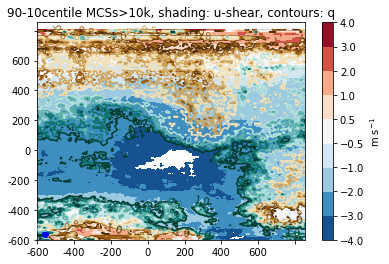

In [15]:
f = plt.figure()
ax = f.add_subplot(111)
plt.contourf((cp4_strong['u_mid'].values/cp4_scnt)-(cp4_weak['u_mid'].values/cp4_wcnt), cmap='RdBu_r', levels=[-4,-3,-2,-1,-0.5,0.5,1,2,3,4])
cbar = plt.colorbar()
cbar.set_label( 'm s$^{-1}$')
plt.title('90-10centile MCSs>10k, shading: u-shear, contours: q')
cs = plt.contour(((cp4_strong['q_pl'].values/cp4_scnt)-(cp4_weak['q_pl'].values)/cp4_wcnt)*1000, cmap='BrBG', levels=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1])
plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

plt.plot(5,5,'bo')
ax.set_xticklabels([-600, -400, -200, 0, 200, 400, 600])
ax.set_yticklabels([-600, -400, -200, 0, 200, 400, 600])

/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


[Text(0, 0.0, '-600'),
 Text(0, 25.0, '-400'),
 Text(0, 50.0, '-200'),
 Text(0, 75.0, '0'),
 Text(0, 100.0, '200'),
 Text(0, 125.0, '400'),
 Text(0, 150.0, '600')]

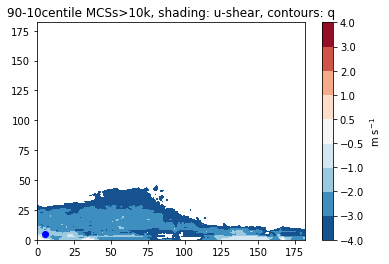

In [20]:
ax = f.add_subplot(111)
plt.contourf((cp4_strong['q_pl'].values*100/cp4_scnt)-(cp4_weak['q_pl'].values*1000/cp4_wcnt), cmap='RdBu_r', levels=[-4,-3,-2,-1,-0.5,0.5,1,2,3,4])
cbar = plt.colorbar()
cbar.set_label( 'm s$^{-1}$')
plt.title('90-10centile MCSs>10k, shading: u-shear, contours: q')
# cs = plt.contour(((cp4_strong['q_pl'].values/cp4_scnt)-(cp4_weak['q_pl'].values)/cp4_wcnt)*1000, cmap='BrBG', levels=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1])
# plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")

plt.plot(5,5,'bo')
ax.set_xticklabels([-600, -400, -200, 0, 200, 400, 600])
ax.set_yticklabels([-600, -400, -200, 0, 200, 400, 600])

In [665]:
out_ds, out_clim, cnt, out_weak, out_strong, cnt_weak, cnt_strong = get_ERA(era,pdf,clim)

1983-02-14 18:00:00
Era missing
1983-02-14 18:00:00
Era missing
1983-02-16 18:00:00
Era missing
1983-02-17 18:00:00
Era missing
1983-02-17 18:00:00
Era missing
1983-02-18 18:00:00
Era missing
1983-02-18 18:00:00
Era missing
1983-02-18 18:00:00
Era missing
1983-02-19 18:00:00
Era missing
1983-02-19 18:00:00
Era missing
1983-02-19 18:00:00
Era missing
1983-02-19 18:00:00
Era missing
1983-02-19 18:00:00
Era missing
1983-02-20 18:00:00
Era missing
1983-02-20 18:00:00
Era missing
1983-02-21 18:00:00
Era missing
1983-02-24 18:00:00
Era missing
1983-02-24 18:00:00
Era missing
1983-02-26 18:00:00
Era missing
1983-02-26 18:00:00
Era missing
1983-02-26 18:00:00
Era missing
1983-03-17 18:00:00
5.284999847412109 -7.415000915527344
3 10
1983-03-17 18:00:00
5.915000915527344 -0.4499969482421875
4 19
1983-03-18 18:00:00
5.915000915527344 -4.7550048828125
4 14
1983-03-18 18:00:00
6.790000915527344 -9.200004577636719
5 8
1983-03-18 18:00:00
5.495002746582031 -0.625
3 19
1983-03-20 18:00:00
5.5300025939

5 19
1983-05-17 18:00:00
5.530002593994141 -8.080001831054688
3 9
1983-05-18 18:00:00
6.8249969482421875 1.9650039672851562
5 23
1983-05-18 18:00:00
5.600002288818359 -2.4800033569335938
3 17
1983-05-18 18:00:00
6.755001068115234 9.840003967285156
5 33
1983-05-19 18:00:00
6.334999084472656 -9.654998779296875
4 7
1983-05-19 18:00:00
5.3899993896484375 9.314994812011719
3 32
1983-05-20 18:00:00
5.040000915527344 8.055000305175781
3 31
1983-05-20 18:00:00
6.650001525878906 -0.274993896484375
5 20
1983-05-21 18:00:00
7.700000762939453 -6.540000915527344
6 11
1983-05-21 18:00:00
7.770000457763672 -9.514999389648438
6 7
1983-05-21 18:00:00
5.460002899169922 -9.409996032714844
3 7
1983-05-21 18:00:00
6.299999237060547 9.6300048828125
4 33
1983-05-22 18:00:00
5.1100006103515625 -4.160003662109375
3 14
1983-05-22 18:00:00
6.159999847412109 -9.164993286132812
4 8
1983-05-23 18:00:00
7.944999694824219 4.94000244140625
7 27
1983-05-24 18:00:00
6.68499755859375 10.889999389648438
5 35
1983-05-25 18

3 32
1983-12-07 18:00:00
7.490001678466797 6.375
6 29
1983-12-10 18:00:00
5.530002593994141 9.455001831054688
3 33
1983-12-11 18:00:00
7.140003204345703 -0.029998779296875
6 20
1983-12-11 18:00:00
6.965000152587891 5.81500244140625
5 28
1983-12-11 18:00:00
6.159999847412109 -5.034996032714844
4 13
1983-12-12 18:00:00
5.25 -7.694999694824219
3 10
1983-12-13 18:00:00
5.635002136230469 -3.6350021362304688
4 15
1983-12-14 18:00:00
5.600002288818359 6.584999084472656
3 29
1983-12-15 18:00:00
5.005001068115234 -1.2549972534179688
3 18
1983-12-15 18:00:00
5.530002593994141 9.595001220703125
3 33
1983-12-15 18:00:00
7.034999847412109 1.404998779296875
5 22
1983-12-15 18:00:00
8.224998474121094 4.3800048828125
7 26
1983-12-17 18:00:00
5.1100006103515625 8.650001525878906
3 32
1983-12-17 18:00:00
6.055000305175781 -1.6750030517578125
4 18
1983-12-18 18:00:00
5.145000457763672 -6.19000244140625
3 12
1983-12-18 18:00:00
5.075000762939453 9.069999694824219
3 32
1983-12-18 18:00:00
5.494998931884766

1984-04-10 18:00:00
5.354999542236328 -1.8499984741210938
3 18
1984-04-10 18:00:00
5.3899993896484375 -8.779998779296875
3 8
1984-04-10 18:00:00
7.979999542236328 -9.1300048828125
7 8
1984-04-10 18:00:00
8.119998931884766 3.6800003051757812
7 25
1984-04-11 18:00:00
5.039997100830078 9.139999389648438
3 32
1984-04-11 18:00:00
5.460002899169922 -9.375
3 8
1984-04-11 18:00:00
6.125 -0.4850006103515625
4 19
1984-04-11 18:00:00
7.630001068115234 -8.7449951171875
6 8
1984-04-12 18:00:00
8.39999771118164 -8.81500244140625
7 8
1984-04-12 18:00:00
5.915000915527344 9.735000610351562
4 33
1984-04-13 18:00:00
5.670001983642578 8.370002746582031
4 31
1984-04-13 18:00:00
7.700000762939453 5.150001525878906
6 27
1984-04-13 18:00:00
5.354999542236328 -9.479995727539062
3 7
1984-04-13 18:00:00
7.034999847412109 -0.37999725341796875
5 19
1984-04-14 18:00:00
5.0749969482421875 5.6049957275390625
3 27
1984-04-15 18:00:00
7.524997711181641 5.430000305175781
6 27
1984-04-16 18:00:00
5.144996643066406 -7.83

7.1399993896484375 0.00499725341796875
6 20
1984-10-29 18:00:00
5.145000457763672 -1.3949966430664062
3 18
1984-10-31 18:00:00
5.459999084472656 -0.975006103515625
3 19
1984-11-04 18:00:00
5.319999694824219 -7.4499969482421875
3 10
1984-11-05 18:00:00
5.319999694824219 4.519996643066406
3 26
1984-11-05 18:00:00
5.950000762939453 -0.9749984741210938
4 19
1984-11-06 18:00:00
8.364997863769531 -2.5849990844726562
7 17
1984-11-06 18:00:00
5.1100006103515625 -8.290000915527344
3 9
1984-11-07 18:00:00
8.119998931884766 -9.025001525878906
7 8
1984-11-07 18:00:00
5.740001678466797 -9.444999694824219
4 7
1984-11-08 18:00:00
8.049999237060547 -8.7449951171875
7 8
1984-11-09 18:00:00
5.530002593994141 -3.1800003051757812
3 16
1984-11-09 18:00:00
7.700000762939453 -7.099998474121094
6 11
1984-11-11 18:00:00
7.875 -7.589996337890625
7 10
1984-11-11 18:00:00
5.80999755859375 7.775001525878906
4 30
1984-11-12 18:00:00
7.31500244140625 2.5250015258789062
6 23
1984-11-12 18:00:00
5.460002899169922 -9.4

1985-04-04 18:00:00
7.350002288818359 -2.1299972534179688
6 17
1985-04-04 18:00:00
7.805000305175781 1.7549972534179688
6 22
1985-04-04 18:00:00
7.840000152587891 -6.400001525878906
6 11
1985-04-05 18:00:00
5.25 -6.715003967285156
3 11
1985-04-05 18:00:00
6.5800018310546875 4.660003662109375
5 26
1985-04-05 18:00:00
7.454998016357422 0.80999755859375
6 21
1985-04-05 18:00:00
6.719997406005859 10.43499755859375
5 34
1985-04-06 18:00:00
5.355003356933594 -8.955001831054688
3 8
1985-04-06 18:00:00
5.075000762939453 8.265007019042969
3 31
1985-04-06 18:00:00
6.895000457763672 2.4550018310546875
5 23
1985-04-06 18:00:00
7.979999542236328 -2.1649932861328125
7 17
1985-04-06 18:00:00
8.294998168945312 -8.814994812011719
7 8
1985-04-07 18:00:00
5.599998474121094 -8.989997863769531
3 8
1985-04-09 18:00:00
8.119998931884766 -1.6750030517578125
7 18
1985-04-09 18:00:00
8.400001525878906 -8.639999389648438
7 8
1985-04-10 18:00:00
5.040000915527344 -3.9850006103515625
3 15
1985-04-10 18:00:00
5.180

1985-10-14 18:00:00
6.685001373291016 5.9550018310546875
5 28
1985-10-14 18:00:00
7.385002136230469 -8.779998779296875
6 8
1985-10-15 18:00:00
6.790000915527344 -1.9199981689453125
5 17
1985-10-15 18:00:00
7.245002746582031 10.19000244140625
6 34
1985-10-16 18:00:00
7.7350006103515625 -0.660003662109375
6 19
1985-10-16 18:00:00
8.084999084472656 -3.7050018310546875
7 15
1985-10-16 18:00:00
6.055000305175781 -6.6450042724609375
4 11
1985-10-17 18:00:00
5.740001678466797 -2.6200027465820312
4 17
1985-10-18 18:00:00
5.600002288818359 -2.1300048828125
3 17
1985-10-18 18:00:00
6.194999694824219 9.560005187988281
4 33
1985-10-18 18:00:00
7.909999847412109 -9.550003051757812
7 7
1985-10-19 18:00:00
6.334999084472656 9.349998474121094
4 32
1985-10-19 18:00:00
6.789997100830078 5.290000915527344
5 27
1985-10-19 18:00:00
8.119998931884766 -9.654998779296875
7 7
1985-10-20 18:00:00
5.495002746582031 8.7550048828125
3 32
1985-10-20 18:00:00
6.439998626708984 4.94000244140625
5 27
1985-10-21 18:00:

1986-02-20 18:00:00
6.020000457763672 -1.42999267578125
4 18
1986-02-20 18:00:00
6.474998474121094 -5.875
5 12
1986-02-20 18:00:00
8.119998931884766 -8.324996948242188
7 9
1986-02-21 18:00:00
5.215000152587891 -7.4850006103515625
3 10
1986-02-22 18:00:00
5.0749969482421875 6.8300018310546875
3 29
1986-02-22 18:00:00
7.4550018310546875 4.94000244140625
6 27
1986-02-26 18:00:00
6.160003662109375 6.025001525878906
4 28
1986-02-26 18:00:00
5.915000915527344 9.700004577636719
4 33
1986-02-26 18:00:00
7.875 0.9850006103515625
7 21
1986-02-26 18:00:00
7.630001068115234 -6.959999084472656
6 11
1986-02-26 18:00:00
7.840000152587891 -2.5850067138671875
6 17
1986-02-26 18:00:00
8.189998626708984 3.8899993896484375
7 25
1986-02-27 18:00:00
5.530002593994141 -5.840003967285156
3 12
1986-02-27 18:00:00
7.209999084472656 0.07500457763671875
6 20
1986-02-27 18:00:00
7.1750030517578125 -7.555000305175781
6 10
1986-02-28 18:00:00
6.404998779296875 1.3000030517578125
5 22
1986-02-28 18:00:00
5.1100006103

1986-05-07 18:00:00
5.845001220703125 -1.1149978637695312
4 19
1986-05-07 18:00:00
6.649997711181641 10.889999389648438
5 35
1986-05-07 18:00:00
7.31500244140625 0.25
6 20
1986-05-07 18:00:00
5.145000457763672 8.825004577636719
3 32
1986-05-08 18:00:00
5.039997100830078 8.650001525878906
3 32
1986-05-08 18:00:00
5.1100006103515625 -7.344993591308594
3 10
1986-05-08 18:00:00
8.329998016357422 -8.675003051757812
7 8
1986-05-09 18:00:00
5.075000762939453 -7.905006408691406
3 9
1986-05-09 18:00:00
5.775001525878906 -5.0
4 13
1986-05-09 18:00:00
6.369998931884766 -0.8700027465820312
4 19
1986-05-09 18:00:00
7.875 1.3700027465820312
7 22
1986-05-09 18:00:00
7.490001678466797 -7.519996643066406
6 10
1986-05-10 18:00:00
5.9499969482421875 -6.75
4 11
1986-05-11 18:00:00
5.880001068115234 -0.8349990844726562
4 19
1986-05-12 18:00:00
5.950000762939453 -4.3350067138671875
4 14
1986-05-12 18:00:00
5.25 -7.2050018310546875
3 10
1986-05-13 18:00:00
7.700000762939453 -8.534996032714844
6 9
1986-05-13 

3 18
1987-01-19 18:00:00
7.069999694824219 1.4749984741210938
5 22
1987-01-20 18:00:00
8.189998626708984 -7.975006103515625
7 9
1987-02-02 18:00:00
5.845001220703125 6.864997863769531
4 29
1987-02-03 18:00:00
7.630001068115234 5.3600006103515625
6 27
1987-02-05 18:00:00
5.460002899169922 -2.05999755859375
3 17
1987-02-12 18:00:00
6.020000457763672 0.8800048828125
4 21
1987-02-12 18:00:00
6.930000305175781 3.75
5 25
1987-02-13 18:00:00
5.284999847412109 -5.1049957275390625
3 13
1987-02-13 18:00:00
6.720001220703125 -5.069999694824219
5 13
1987-02-13 18:00:00
7.385002136230469 1.9650039672851562
6 23
1987-02-13 18:00:00
8.294998168945312 5.534996032714844
7 27
1987-02-14 18:00:00
5.635002136230469 -0.06499481201171875
4 20
1987-02-14 18:00:00
5.7050018310546875 -2.095001220703125
4 17
1987-02-14 18:00:00
6.615001678466797 10.050003051757812
5 33
1987-02-14 18:00:00
5.459999084472656 3.7150039672851562
3 25
1987-02-15 18:00:00
5.56500244140625 -7.4499969482421875
3 10
1987-02-15 18:00:00


1987-04-18 18:00:00
6.930000305175781 -1.9900054931640625
5 17
1987-04-18 18:00:00
7.31500244140625 3.1200027465820312
6 24
1987-04-18 18:00:00
7.875 -7.555000305175781
7 10
1987-04-19 18:00:00
6.930000305175781 -1.1149978637695312
5 19
1987-04-19 18:00:00
5.775001525878906 -5.6999969482421875
4 12
1987-04-19 18:00:00
6.755001068115234 -6.19000244140625
5 12
1987-04-19 18:00:00
7.4550018310546875 4.590003967285156
6 26
1987-04-19 18:00:00
8.014999389648438 -7.625
7 10
1987-04-19 18:00:00
5.56500244140625 9.034996032714844
3 32
1987-04-20 18:00:00
5.775001525878906 -0.41500091552734375
4 19
1987-04-22 18:00:00
5.284999847412109 -6.8549957275390625
3 11
1987-04-23 18:00:00
6.090000152587891 -5.489997863769531
4 13
1987-04-24 18:00:00
5.915000915527344 -5.349998474121094
4 13
1987-04-25 18:00:00
5.880001068115234 -0.274993896484375
4 20
1987-04-26 18:00:00
6.965000152587891 -4.2649993896484375
5 14
1987-04-26 18:00:00
7.944999694824219 -8.745002746582031
7 8
1987-04-26 18:00:00
5.39000320

1987-10-18 18:00:00
6.930000305175781 -1.535003662109375
5 18
1987-10-19 18:00:00
5.25 9.0
3 32
1987-10-19 18:00:00
5.354999542236328 -2.3050003051757812
3 17
1987-10-19 18:00:00
5.810001373291016 -9.270004272460938
4 8
1987-10-19 18:00:00
7.0 3.4000015258789062
5 25
1987-10-20 18:00:00
6.090000152587891 -3.5999984741210938
4 15
1987-10-20 18:00:00
6.895000457763672 3.399993896484375
5 25
1987-10-20 18:00:00
8.049999237060547 0.5999984741210938
7 21
1987-10-20 18:00:00
8.014999389648438 5.185005187988281
7 27
1987-10-20 18:00:00
5.075000762939453 9.770004272460938
3 33
1987-10-21 18:00:00
5.599998474121094 -5.31500244140625
3 13
1987-10-21 18:00:00
6.2649993896484375 -0.029998779296875
4 20
1987-10-21 18:00:00
6.649997711181641 -7.555000305175781
5 10
1987-10-21 18:00:00
7.4550018310546875 1.3000030517578125
6 22
1987-10-21 18:00:00
8.014999389648438 -2.4800033569335938
7 17
1987-10-21 18:00:00
8.224998474121094 -5.55999755859375
7 13
1987-10-22 18:00:00
5.634998321533203 -5.7700042724

1988-03-02 18:00:00
5.950000762939453 9.770004272460938
4 33
1988-03-02 18:00:00
6.334999084472656 5.989997863769531
4 28
1988-03-02 18:00:00
7.210002899169922 10.715003967285156
6 34
1988-03-02 18:00:00
7.4550018310546875 3.75
6 25
1988-03-03 18:00:00
6.615001678466797 -4.439994812011719
5 14
1988-03-03 18:00:00
7.245002746582031 3.7150039672851562
6 25
1988-03-04 18:00:00
7.350002288818359 3.43499755859375
6 25
1988-03-05 18:00:00
5.634998321533203 8.650001525878906
4 32
1988-03-05 18:00:00
6.789997100830078 5.430000305175781
5 27
1988-03-05 18:00:00
6.719997406005859 10.470001220703125
5 34
1988-03-05 18:00:00
7.840000152587891 0.32000732421875
6 20
1988-03-06 18:00:00
5.56500244140625 -4.089996337890625
3 15
1988-03-06 18:00:00
6.5449981689453125 9.279998779296875
5 32
1988-03-07 18:00:00
7.070003509521484 -2.05999755859375
5 17
1988-03-09 18:00:00
5.040000915527344 5.814994812011719
3 28
1988-03-09 18:00:00
6.090000152587891 8.790000915527344
4 32
1988-03-09 18:00:00
7.73500061035

6.5449981689453125 -1.7099990844726562
5 18
1988-04-29 18:00:00
5.320003509521484 5.849998474121094
3 28
1988-04-29 18:00:00
6.299999237060547 10.155006408691406
4 34
1988-04-30 18:00:00
5.180000305175781 -8.709999084472656
3 8
1988-04-30 18:00:00
6.125 9.979995727539062
4 33
1988-04-30 18:00:00
5.284999847412109 -6.8899993896484375
3 11
1988-04-30 18:00:00
6.755001068115234 2.9800033569335938
5 24
1988-05-01 18:00:00
6.510002136230469 4.8350067138671875
5 26
1988-05-02 18:00:00
6.720001220703125 2.875
5 24
1988-05-02 18:00:00
5.390003204345703 -6.504997253417969
3 11
1988-05-03 18:00:00
8.224998474121094 -8.884994506835938
7 8
1988-05-04 18:00:00
5.005001068115234 8.68499755859375
3 32
1988-05-04 18:00:00
7.174999237060547 10.680000305175781
6 34
1988-05-07 18:00:00
5.950000762939453 9.839996337890625
4 33
1988-05-08 18:00:00
5.704998016357422 5.6399993896484375
4 28
1988-05-08 18:00:00
7.000003814697266 7.704994201660156
5 30
1988-05-09 18:00:00
5.635002136230469 -1.5
4 18
1988-05-09

1988-11-01 18:00:00
6.2649993896484375 0.845001220703125
4 21
1988-11-01 18:00:00
6.510002136230469 2.8400039672851562
5 24
1988-11-02 18:00:00
6.194999694824219 -1.1500015258789062
4 18
1988-11-02 18:00:00
7.069999694824219 1.2300033569335938
5 22
1988-11-03 18:00:00
6.2649993896484375 -0.8699951171875
4 19
1988-11-04 18:00:00
5.390003204345703 -6.924995422363281
3 11
1988-11-09 18:00:00
5.145000457763672 8.825004577636719
3 32
1988-11-10 18:00:00
5.3899993896484375 -0.6949996948242188
3 19
1988-11-10 18:00:00
6.159999847412109 0.7400054931640625
4 21
1988-11-11 18:00:00
5.530002593994141 8.615005493164062
3 31
1988-11-11 18:00:00
5.424999237060547 -4.8249969482421875
3 14
1988-11-12 18:00:00
5.145000457763672 -6.575004577636719
3 11
1988-11-12 18:00:00
5.530002593994141 -1.5699996948242188
3 18
1988-11-12 18:00:00
5.459999084472656 -4.3699951171875
3 14
1988-11-13 18:00:00
5.180000305175781 6.129997253417969
3 28
1988-11-13 18:00:00
5.459999084472656 -1.5699996948242188
3 18
1988-11-

1989-03-21 18:00:00
7.034999847412109 1.5100021362304688
5 22
1989-03-21 18:00:00
7.944999694824219 5.745002746582031
7 28
1989-03-21 18:00:00
5.495002746582031 -9.129997253417969
3 8
1989-03-22 18:00:00
6.8600006103515625 5.254997253417969
5 27
1989-03-22 18:00:00
6.439998626708984 10.75
5 34
1989-03-22 18:00:00
5.460002899169922 7.1100006103515625
3 29
1989-03-23 18:00:00
5.494998931884766 -7.660003662109375
3 10
1989-03-23 18:00:00
5.530002593994141 9.209999084472656
3 32
1989-03-23 18:00:00
5.775001525878906 10.9949951171875
4 35
1989-03-23 18:00:00
6.545001983642578 1.6150054931640625
5 22
1989-03-23 18:00:00
7.350002288818359 7.25
6 30
1989-03-23 18:00:00
8.014999389648438 6.025001525878906
7 28
1989-03-24 18:00:00
5.704998016357422 9.280006408691406
4 32
1989-03-25 18:00:00
6.335002899169922 9.245002746582031
4 32
1989-03-25 18:00:00
5.635002136230469 -2.8300018310546875
4 16
1989-03-25 18:00:00
6.334999084472656 5.430000305175781
4 27
1989-03-25 18:00:00
6.8600006103515625 10.9

1989-05-23 18:00:00
5.284999847412109 -1.9899978637695312
3 17
1989-05-23 18:00:00
5.319999694824219 -4.159996032714844
3 14
1989-05-23 18:00:00
5.7050018310546875 -8.639999389648438
4 8
1989-05-24 18:00:00
5.600002288818359 -8.919998168945312
3 8
1989-05-24 18:00:00
6.545001983642578 8.404998779296875
5 31
1989-05-25 18:00:00
5.215000152587891 5.3249969482421875
3 27
1989-05-25 18:00:00
5.775001525878906 -3.4249954223632812
4 15
1989-05-25 18:00:00
8.364997863769531 1.6850051879882812
7 22
1989-05-26 18:00:00
7.560001373291016 -7.4850006103515625
6 10
1989-05-26 18:00:00
7.630001068115234 -1.0100021362304688
6 19
1989-05-26 18:00:00
8.329998016357422 -9.970001220703125
7 7
1989-05-27 18:00:00
6.930000305175781 10.715003967285156
5 34
1989-05-27 18:00:00
5.56500244140625 9.139999389648438
3 32
1989-05-27 18:00:00
5.670001983642578 -7.099998474121094
4 11
1989-05-28 18:00:00
5.040000915527344 -7.590003967285156
3 10
1989-05-28 18:00:00
5.075000762939453 9.139999389648438
3 32
1989-05-28

1989-12-14 18:00:00
7.420001983642578 1.5100021362304688
6 22
1989-12-27 18:00:00
5.1100006103515625 -9.830001831054688
3 7
1989-12-28 18:00:00
5.775001525878906 -0.8000030517578125
4 19
1989-12-29 18:00:00
6.299999237060547 -2.6199951171875
4 17
1989-12-30 18:00:00
5.915000915527344 -7.7649993896484375
4 10
1989-12-30 18:00:00
8.014999389648438 -8.254997253417969
7 9
1990-01-09 18:00:00
5.460002899169922 -8.360000610351562
3 9
1990-01-09 18:00:00
7.035003662109375 -8.569999694824219
5 9
1990-01-19 18:00:00
6.229999542236328 0.49500274658203125
4 21
1990-01-19 18:00:00
7.560001373291016 -0.23999786376953125
6 20
1990-01-20 18:00:00
5.460002899169922 -5.069999694824219
3 13
1990-01-20 18:00:00
5.635002136230469 -2.095001220703125
4 17
1990-01-20 18:00:00
7.349998474121094 1.5100021362304688
6 22
1990-01-21 18:00:00
5.670001983642578 -3.214996337890625
4 16
1990-01-21 18:00:00
6.020000457763672 -5.209999084472656
4 13
1990-01-21 18:00:00
6.685001373291016 6.410003662109375
5 29
1990-01-2

1990-05-03 18:00:00
6.719997406005859 4.94000244140625
5 27
1990-05-04 18:00:00
5.215000152587891 9.0
3 32
1990-05-04 18:00:00
8.189998626708984 -8.954994201660156
7 8
1990-05-05 18:00:00
6.614997863769531 4.4499969482421875
5 26
1990-05-05 18:00:00
7.034999847412109 2.4899978637695312
5 23
1990-05-05 18:00:00
5.390003204345703 -7.4149932861328125
3 10
1990-05-06 18:00:00
5.1100006103515625 -7.904998779296875
3 9
1990-05-06 18:00:00
8.295001983642578 -4.090003967285156
7 15
1990-05-07 18:00:00
5.075000762939453 -9.165000915527344
3 8
1990-05-07 18:00:00
5.459999084472656 8.404998779296875
3 31
1990-05-08 18:00:00
5.040000915527344 8.335006713867188
3 31
1990-05-09 18:00:00
6.055000305175781 8.964996337890625
4 32
1990-05-09 18:00:00
5.880001068115234 -4.650001525878906
4 14
1990-05-10 18:00:00
8.400001525878906 4.625
7 26
1990-05-11 18:00:00
7.875 -8.220001220703125
7 9
1990-05-11 18:00:00
5.25 -8.464996337890625
3 9
1990-05-12 18:00:00
7.314998626708984 10.644996643066406
6 34
1990-05

4 11
1990-11-13 18:00:00
7.525001525878906 1.3700027465820312
6 22
1990-11-13 18:00:00
7.595001220703125 3.6100006103515625
6 25
1990-11-14 18:00:00
7.770000457763672 -8.745002746582031
6 8
1990-11-14 18:00:00
7.4550018310546875 -1.9899978637695312
6 17
1990-11-14 18:00:00
6.055000305175781 9.175003051757812
4 32
1990-11-15 18:00:00
8.329998016357422 -7.7299957275390625
7 10
1990-11-15 18:00:00
5.845001220703125 8.860000610351562
4 32
1990-11-15 18:00:00
7.980003356933594 0.6699981689453125
7 21
1990-11-15 18:00:00
7.560001373291016 -3.25
6 16
1990-11-15 18:00:00
7.245002746582031 2.6299972534179688
6 24
1990-11-16 18:00:00
8.329998016357422 0.25
7 20
1990-11-17 18:00:00
5.530002593994141 -7.5200042724609375
3 10
1990-11-17 18:00:00
5.880001068115234 -1.220001220703125
4 18
1990-11-18 18:00:00
5.845001220703125 -6.8899993896484375
4 11
1990-11-18 18:00:00
5.915000915527344 -1.0100021362304688
4 19
1990-11-18 18:00:00
7.770000457763672 -2.024993896484375
6 17
1990-11-18 18:00:00
5.18000

1991-02-27 18:00:00
7.314998626708984 0.7400054931640625
6 21
1991-02-27 18:00:00
7.4199981689453125 6.095001220703125
6 28
1991-02-27 18:00:00
8.364997863769531 -1.9199981689453125
7 17
1991-02-27 18:00:00
5.600002288818359 -8.290000915527344
3 9
1991-02-28 18:00:00
6.895000457763672 -3.7399978637695312
5 15
1991-03-01 18:00:00
6.020000457763672 7.1100006103515625
4 29
1991-03-01 18:00:00
6.404998779296875 10.120002746582031
5 33
1991-03-01 18:00:00
6.649997711181641 -5.349998474121094
5 13
1991-03-01 18:00:00
7.350002288818359 -1.0800018310546875
6 19
1991-03-01 18:00:00
7.174999237060547 3.5400009155273438
6 25
1991-03-02 18:00:00
5.215000152587891 -1.8499984741210938
3 18
1991-03-03 18:00:00
5.040000915527344 -7.100006103515625
3 11
1991-03-05 18:00:00
6.439998626708984 5.605003356933594
5 27
1991-03-05 18:00:00
6.369998931884766 -0.589996337890625
4 19
1991-03-05 18:00:00
7.104999542236328 1.160003662109375
5 22
1991-03-05 18:00:00
7.595001220703125 3.7150039672851562
6 25
1991-03

4 14
1991-04-13 18:00:00
7.4199981689453125 8.824996948242188
6 32
1991-04-13 18:00:00
6.229999542236328 -0.1699981689453125
4 20
1991-04-13 18:00:00
6.895000457763672 2.4899978637695312
5 23
1991-04-14 18:00:00
5.529998779296875 -8.639999389648438
3 8
1991-04-14 18:00:00
7.350002288818359 -7.1699981689453125
6 10
1991-04-15 18:00:00
6.159999847412109 10.575004577636719
4 34
1991-04-15 18:00:00
5.284999847412109 8.650001525878906
3 32
1991-04-15 18:00:00
5.424999237060547 -3.0749969482421875
3 16
1991-04-16 18:00:00
5.6699981689453125 9.245002746582031
4 32
1991-04-17 18:00:00
6.650001525878906 9.595001220703125
5 33
1991-04-18 18:00:00
5.530002593994141 -7.6949920654296875
3 10
1991-04-18 18:00:00
5.495002746582031 9.069999694824219
3 32
1991-04-20 18:00:00
6.439998626708984 9.805000305175781
5 33
1991-04-23 18:00:00
6.299999237060547 9.55999755859375
4 33
1991-04-24 18:00:00
6.334999084472656 5.325004577636719
4 27
1991-04-25 18:00:00
5.880001068115234 -1.7450027465820312
4 18
1991-0

1991-10-21 18:00:00
5.775001525878906 8.930000305175781
4 32
1991-10-22 18:00:00
5.915000915527344 -7.239997863769531
4 10
1991-10-22 18:00:00
6.579998016357422 -3.3550033569335938
5 16
1991-10-23 18:00:00
5.0749969482421875 5.9199981689453125
3 28
1991-10-24 18:00:00
5.880001068115234 8.370002746582031
4 31
1991-10-24 18:00:00
7.7350006103515625 -8.639999389648438
6 8
1991-10-25 18:00:00
6.334999084472656 10.085006713867188
4 33
1991-10-25 18:00:00
6.369998931884766 -0.5200042724609375
4 19
1991-10-26 18:00:00
5.670001983642578 5.954994201660156
4 28
1991-10-26 18:00:00
6.755001068115234 9.805000305175781
5 33
1991-10-27 18:00:00
5.284999847412109 9.525001525878906
3 33
1991-10-27 18:00:00
6.68499755859375 10.785003662109375
5 34
1991-10-27 18:00:00
7.700000762939453 4.765007019042969
6 26
1991-10-28 18:00:00
7.210002899169922 10.925003051757812
6 35
1991-10-28 18:00:00
8.120002746582031 -1.0800018310546875
7 19
1991-10-28 18:00:00
7.4550018310546875 -9.199996948242188
6 8
1991-10-28 

4 19
1992-04-09 18:00:00
7.909999847412109 -9.339996337890625
7 8
1992-04-09 18:00:00
6.369998931884766 9.0
4 32
1992-04-10 18:00:00
7.55999755859375 5.3600006103515625
6 27
1992-04-10 18:00:00
5.319999694824219 6.549995422363281
3 29
1992-04-10 18:00:00
6.055000305175781 -2.1650009155273438
4 17
1992-04-11 18:00:00
5.215000152587891 9.875
3 33
1992-04-11 18:00:00
5.635002136230469 -4.649993896484375
4 14
1992-04-11 18:00:00
5.880001068115234 -2.05999755859375
4 17
1992-04-11 18:00:00
6.020000457763672 0.4250030517578125
4 21
1992-04-11 18:00:00
8.014999389648438 -4.964996337890625
7 13
1992-04-11 18:00:00
8.470001220703125 4.30999755859375
7 26
1992-04-11 18:00:00
5.215000152587891 -7.625
3 10
1992-04-12 18:00:00
5.915000915527344 -2.2700042724609375
4 17
1992-04-12 18:00:00
6.194999694824219 8.125
4 31
1992-04-13 18:00:00
6.68499755859375 0.5300064086914062
5 21
1992-04-13 18:00:00
7.490001678466797 -4.230003356933594
6 14
1992-04-14 18:00:00
7.525001525878906 -9.795005798339844
6 7


1992-10-08 18:00:00
5.740001678466797 5.465003967285156
4 27
1992-10-09 18:00:00
7.104999542236328 -1.464996337890625
5 18
1992-10-11 18:00:00
6.334999084472656 5.605003356933594
4 27
1992-10-11 18:00:00
6.5449981689453125 -1.535003662109375
5 18
1992-10-11 18:00:00
5.494998931884766 8.650001525878906
3 32
1992-10-12 18:00:00
5.740001678466797 8.510002136230469
4 31
1992-10-12 18:00:00
6.5449981689453125 -9.584999084472656
5 7
1992-10-12 18:00:00
6.5449981689453125 0.3899993896484375
5 21
1992-10-12 18:00:00
7.4550018310546875 7.6699981689453125
6 30
1992-10-12 18:00:00
8.014999389648438 3.9950027465820312
7 25
1992-10-13 18:00:00
5.635002136230469 8.615005493164062
4 31
1992-10-14 18:00:00
7.245002746582031 10.819999694824219
6 34
1992-10-14 18:00:00
6.194999694824219 6.69000244140625
4 29
1992-10-14 18:00:00
6.159999847412109 8.614997863769531
4 31
1992-10-15 18:00:00
7.665000915527344 4.344993591308594
6 26
1992-10-15 18:00:00
5.320003509521484 7.215003967285156
3 30
1992-10-16 18:0

5.075000762939453 5.779998779296875
3 28
1993-02-23 18:00:00
8.084999084472656 -5.524993896484375
7 13
1993-02-25 18:00:00
6.334999084472656 -1.4300003051757812
4 18
1993-02-25 18:00:00
7.630001068115234 2.875
6 24
1993-02-25 18:00:00
8.119998931884766 -7.625
7 10
1993-02-27 18:00:00
5.739997863769531 5.6750030517578125
4 28
1993-02-27 18:00:00
6.405002593994141 9.31500244140625
5 32
1993-02-27 18:00:00
6.965000152587891 10.610000610351562
5 34
1993-02-28 18:00:00
6.159999847412109 -3.1100006103515625
4 16
1993-02-28 18:00:00
7.55999755859375 -0.23999786376953125
6 20
1993-02-28 18:00:00
6.5449981689453125 9.525001525878906
5 33
1993-02-28 18:00:00
7.770000457763672 5.185005187988281
6 27
1993-02-28 18:00:00
8.330001831054688 -7.7299957275390625
7 10
1993-02-28 18:00:00
5.9850006103515625 -8.5
4 9
1993-03-01 18:00:00
5.25 10.575004577636719
3 34
1993-03-01 18:00:00
6.090000152587891 -3.3549957275390625
4 16
1993-03-01 18:00:00
6.614997863769531 -0.7999954223632812
5 19
1993-03-01 18:00

1993-04-22 18:00:00
7.944999694824219 -8.430000305175781
7 9
1993-04-22 18:00:00
8.43499755859375 -3.7049942016601562
7 15
1993-04-25 18:00:00
5.9850006103515625 -1.535003662109375
4 18
1993-04-25 18:00:00
5.635002136230469 5.430000305175781
4 27
1993-04-25 18:00:00
7.490001678466797 3.154998779296875
6 24
1993-04-26 18:00:00
6.229999542236328 6.025001525878906
4 28
1993-04-26 18:00:00
7.560001373291016 -7.1699981689453125
6 10
1993-04-26 18:00:00
5.25 -7.239997863769531
3 10
1993-04-26 18:00:00
5.109996795654297 7.529998779296875
3 30
1993-04-26 18:00:00
5.529998779296875 -2.8300018310546875
3 16
1993-04-27 18:00:00
6.334999084472656 9.875007629394531
4 33
1993-04-28 18:00:00
5.3899993896484375 -8.430000305175781
3 9
1993-04-28 18:00:00
7.104999542236328 5.709999084472656
5 28
1993-04-28 18:00:00
6.055000305175781 9.525001525878906
4 33
1993-04-28 18:00:00
6.404998779296875 -5.035003662109375
5 13
1993-04-28 18:00:00
8.365001678466797 -2.7249984741210938
7 16
1993-04-30 18:00:00
8.329

1993-10-26 18:00:00
8.119998931884766 5.569999694824219
7 27
1993-10-26 18:00:00
5.635002136230469 -3.8799972534179688
4 15
1993-10-26 18:00:00
7.105003356933594 0.35500335693359375
5 20
1993-10-27 18:00:00
8.46999740600586 -8.079994201660156
7 9
1993-10-27 18:00:00
5.1100006103515625 -7.4850006103515625
3 10
1993-10-27 18:00:00
5.845001220703125 -0.8000030517578125
4 19
1993-10-27 18:00:00
7.0 -0.06500244140625
5 20
1993-10-27 18:00:00
7.7350006103515625 4.94000244140625
6 27
1993-10-28 18:00:00
5.284999847412109 -7.904998779296875
3 9
1993-10-28 18:00:00
6.404998779296875 5.5
5 27
1993-10-28 18:00:00
7.210002899169922 4.8000030517578125
6 26
1993-10-28 18:00:00
7.244998931884766 -7.974998474121094
6 9
1993-10-28 18:00:00
5.320003509521484 -3.4600067138671875
3 15
1993-10-28 18:00:00
5.075000762939453 9.279998779296875
3 32
1993-10-29 18:00:00
5.319999694824219 8.650001525878906
3 32
1993-10-29 18:00:00
5.460002899169922 -2.69000244140625
3 16
1993-10-30 18:00:00
5.950000762939453 7.2

1994-02-28 18:00:00
6.614997863769531 1.1949996948242188
5 22
1994-03-01 18:00:00
6.755001068115234 -4.299995422363281
5 14
1994-03-02 18:00:00
5.285003662109375 9.279998779296875
3 32
1994-03-03 18:00:00
7.665000915527344 -6.3650054931640625
6 12
1994-03-03 18:00:00
7.875 5.394996643066406
7 27
1994-03-04 18:00:00
5.810001373291016 -5.7350006103515625
4 12
1994-03-04 18:00:00
6.44000244140625 10.155006408691406
5 34
1994-03-04 18:00:00
7.385002136230469 -2.2000045776367188
6 17
1994-03-06 18:00:00
5.7050018310546875 10.645004272460938
4 34
1994-03-07 18:00:00
5.494998931884766 -5.489997863769531
3 13
1994-03-08 18:00:00
6.229999542236328 -8.569999694824219
4 9
1994-03-08 18:00:00
6.2649993896484375 10.189994812011719
4 34
1994-03-08 18:00:00
8.120002746582031 -7.135002136230469
7 10
1994-03-09 18:00:00
6.439998626708984 5.5
5 27
1994-03-09 18:00:00
6.159999847412109 9.210006713867188
4 32
1994-03-09 18:00:00
7.174999237060547 -0.9749984741210938
6 19
1994-03-09 18:00:00
7.595001220703

1994-04-21 18:00:00
6.474998474121094 1.1599960327148438
5 22
1994-04-22 18:00:00
5.950000762939453 9.139999389648438
4 32
1994-04-22 18:00:00
7.1399993896484375 -0.23999786376953125
6 20
1994-04-22 18:00:00
7.069999694824219 3.9599990844726562
5 25
1994-04-22 18:00:00
7.630001068115234 -8.394996643066406
6 9
1994-04-22 18:00:00
7.805000305175781 5.18499755859375
6 27
1994-04-23 18:00:00
6.439998626708984 10.610000610351562
5 34
1994-04-23 18:00:00
7.944999694824219 3.9950027465820312
7 25
1994-04-24 18:00:00
5.7050018310546875 -1.5
4 18
1994-04-26 18:00:00
5.530002593994141 -2.6200027465820312
3 17
1994-04-26 18:00:00
6.090000152587891 -4.894996643066406
4 13
1994-04-28 18:00:00
5.880001068115234 9.595001220703125
4 33
1994-04-30 18:00:00
5.495002746582031 8.160003662109375
3 31
1994-04-30 18:00:00
5.635002136230469 -8.639999389648438
4 8
1994-05-01 18:00:00
5.319999694824219 8.544998168945312
3 31
1994-05-01 18:00:00
8.15500259399414 0.5649948120117188
7 21
1994-05-02 18:00:00
6.4749

5.7050018310546875 8.894996643066406
4 32
1994-10-15 18:00:00
7.140003204345703 -2.1299972534179688
6 17
1994-10-15 18:00:00
7.525001525878906 0.9150009155273438
6 21
1994-10-16 18:00:00
7.069999694824219 -9.760002136230469
5 7
1994-10-16 18:00:00
7.0 4.939994812011719
5 27
1994-10-17 18:00:00
6.650001525878906 10.539993286132812
5 34
1994-10-17 18:00:00
6.090000152587891 8.194999694824219
4 31
1994-10-17 18:00:00
6.229999542236328 -8.7449951171875
4 8
1994-10-18 18:00:00
6.720001220703125 -2.0250015258789062
5 17
1994-10-18 18:00:00
5.740001678466797 4.415000915527344
4 26
1994-10-18 18:00:00
6.020000457763672 8.790000915527344
4 32
1994-10-20 18:00:00
6.194999694824219 -5.875
4 12
1994-10-20 18:00:00
6.369998931884766 -0.8699951171875
4 19
1994-10-20 18:00:00
7.140003204345703 -8.674995422363281
6 8
1994-10-20 18:00:00
6.44000244140625 8.930000305175781
5 32
1994-10-21 18:00:00
6.125 -2.2000045776367188
4 17
1994-10-21 18:00:00
7.384998321533203 -0.8699951171875
6 19
1994-10-22 18:00

6.720001220703125 5.290000915527344
5 27
1995-03-10 18:00:00
7.490001678466797 0.8100051879882812
6 21
1995-03-10 18:00:00
7.700000762939453 -7.204994201660156
6 10
1995-03-11 18:00:00
5.459999084472656 10.120002746582031
3 33
1995-03-11 18:00:00
6.159999847412109 5.6049957275390625
4 27
1995-03-13 18:00:00
5.810001373291016 -6.959999084472656
4 11
1995-03-13 18:00:00
7.944999694824219 -7.415000915527344
7 10
1995-03-13 18:00:00
8.294998168945312 4.870002746582031
7 26
1995-03-14 18:00:00
7.630001068115234 -3.4250030517578125
6 15
1995-03-15 18:00:00
6.650001525878906 -6.784996032714844
5 11
1995-03-15 18:00:00
5.530002593994141 9.455001831054688
3 33
1995-03-15 18:00:00
5.424999237060547 6.095001220703125
3 28
1995-03-15 18:00:00
8.189998626708984 6.024993896484375
7 28
1995-03-17 18:00:00
6.334999084472656 -3.1800003051757812
4 16
1995-03-17 18:00:00
7.665000915527344 5.3950042724609375
6 27
1995-03-19 18:00:00
6.965000152587891 -4.2649993896484375
5 14
1995-03-19 18:00:00
6.26499938

6.790000915527344 -7.4850006103515625
5 10
1995-05-10 18:00:00
5.775001525878906 8.614997863769531
4 31
1995-05-10 18:00:00
8.224998474121094 4.4499969482421875
7 26
1995-05-11 18:00:00
5.284999847412109 -6.9949951171875
3 11
1995-05-11 18:00:00
5.354999542236328 6.8650054931640625
3 29
1995-05-11 18:00:00
6.090000152587891 -1.8850021362304688
4 17
1995-05-11 18:00:00
7.385002136230469 -8.675003051757812
6 8
1995-05-11 18:00:00
7.805000305175781 -6.260002136230469
6 12
1995-05-12 18:00:00
5.775001525878906 9.419998168945312
4 33
1995-05-13 18:00:00
6.8600006103515625 -2.375
5 17
1995-05-13 18:00:00
6.895000457763672 9.384994506835938
5 33
1995-05-13 18:00:00
7.4550018310546875 4.7649993896484375
6 26
1995-05-13 18:00:00
7.245002746582031 1.8249969482421875
6 22
1995-05-13 18:00:00
5.355003356933594 8.44000244140625
3 31
1995-05-14 18:00:00
5.7050018310546875 9.175003051757812
4 32
1995-05-14 18:00:00
5.319999694824219 -2.4799957275390625
3 17
1995-05-14 18:00:00
5.600002288818359 0.985

1995-10-23 18:00:00
8.049999237060547 -1.0100021362304688
7 19
1995-10-23 18:00:00
5.600002288818359 -0.94000244140625
3 19
1995-10-23 18:00:00
6.299999237060547 9.980003356933594
4 33
1995-10-24 18:00:00
7.174999237060547 2.4899978637695312
6 23
1995-10-24 18:00:00
6.8600006103515625 10.714996337890625
5 34
1995-10-24 18:00:00
8.259998321533203 0.25
7 20
1995-10-25 18:00:00
6.020000457763672 -5.980003356933594
4 12
1995-10-25 18:00:00
6.754997253417969 -0.660003662109375
5 19
1995-10-25 18:00:00
5.670001983642578 9.944999694824219
4 33
1995-10-26 18:00:00
5.1100006103515625 -7.590003967285156
3 10
1995-10-26 18:00:00
5.635002136230469 5.989997863769531
4 28
1995-10-26 18:00:00
5.670001983642578 -2.1650009155273438
4 17
1995-10-26 18:00:00
6.895000457763672 10.330001831054688
5 34
1995-10-26 18:00:00
7.875 -8.639999389648438
7 8
1995-10-26 18:00:00
8.084999084472656 3.9249954223632812
7 25
1995-10-27 18:00:00
6.369998931884766 -8.5
4 9
1995-10-27 18:00:00
7.105003356933594 -6.505004882

7.280002593994141 1.3000030517578125
6 22
1996-02-12 18:00:00
7.525001525878906 -6.435005187988281
6 11
1996-02-12 18:00:00
5.284999847412109 -2.2350006103515625
3 17
1996-02-12 18:00:00
5.005001068115234 -6.680000305175781
3 11
1996-02-12 18:00:00
7.0 -0.8349990844726562
5 19
1996-02-13 18:00:00
6.020000457763672 -0.8000030517578125
4 19
1996-02-13 18:00:00
6.125 6.724998474121094
4 29
1996-02-13 18:00:00
6.369998931884766 -3.3549957275390625
4 16
1996-02-13 18:00:00
7.384998321533203 0.9850006103515625
6 21
1996-02-13 18:00:00
7.420001983642578 5.220001220703125
6 27
1996-02-13 18:00:00
5.284999847412109 -9.025001525878906
3 8
1996-02-14 18:00:00
6.194999694824219 -4.930000305175781
4 13
1996-02-14 18:00:00
6.055000305175781 -0.6949996948242188
4 19
1996-02-14 18:00:00
6.369998931884766 0.6699981689453125
4 21
1996-02-14 18:00:00
7.944999694824219 -2.4800033569335938
7 17
1996-02-15 18:00:00
7.560001373291016 -0.37999725341796875
6 19
1996-02-15 18:00:00
6.685001373291016 4.764999389

1996-04-08 18:00:00
5.7050018310546875 -9.164993286132812
4 8
1996-04-08 18:00:00
6.68499755859375 6.200004577636719
5 28
1996-04-08 18:00:00
7.770000457763672 -7.694999694824219
6 10
1996-04-09 18:00:00
5.040000915527344 -6.43499755859375
3 11
1996-04-09 18:00:00
6.055000305175781 7.0749969482421875
4 29
1996-04-09 18:00:00
6.475002288818359 10.154998779296875
5 34
1996-04-09 18:00:00
7.805000305175781 -7.345001220703125
6 10
1996-04-09 18:00:00
8.400001525878906 5.394996643066406
7 27
1996-04-10 18:00:00
5.1100006103515625 8.545005798339844
3 31
1996-04-10 18:00:00
5.215000152587891 -2.1999969482421875
3 17
1996-04-10 18:00:00
7.560001373291016 1.5100021362304688
6 22
1996-04-10 18:00:00
8.015003204345703 -4.160003662109375
7 14
1996-04-10 18:00:00
8.329998016357422 6.165000915527344
7 28
1996-04-11 18:00:00
7.210002899169922 -7.135002136230469
6 10
1996-04-12 18:00:00
7.7350006103515625 0.18000030517578125
6 20
1996-04-13 18:00:00
5.005001068115234 -7.1699981689453125
3 10
1996-04-1

6 9
1996-10-11 18:00:00
5.004997253417969 9.875
3 33
1996-10-12 18:00:00
8.365001678466797 -1.6049957275390625
7 18
1996-10-12 18:00:00
5.495002746582031 9.665000915527344
3 33
1996-10-12 18:00:00
6.5449981689453125 0.6699981689453125
5 21
1996-10-13 18:00:00
6.439998626708984 9.209999084472656
5 32
1996-10-14 18:00:00
7.7350006103515625 5.185005187988281
6 27
1996-10-14 18:00:00
6.509998321533203 9.349998474121094
5 32
1996-10-15 18:00:00
6.020000457763672 -0.48499298095703125
4 19
1996-10-15 18:00:00
6.579998016357422 10.610000610351562
5 34
1996-10-15 18:00:00
7.595001220703125 3.0149993896484375
6 24
1996-10-16 18:00:00
5.9850006103515625 -9.620002746582031
4 7
1996-10-16 18:00:00
8.084999084472656 0.4949951171875
7 21
1996-10-16 18:00:00
7.875 5.0800018310546875
7 27
1996-10-16 18:00:00
8.329998016357422 -3.4599990844726562
7 15
1996-10-16 18:00:00
5.635002136230469 5.779998779296875
4 28
1996-10-17 18:00:00
6.265003204345703 -8.919998168945312
4 8
1996-10-17 18:00:00
6.7200012207

1997-03-21 18:00:00
7.280002593994141 -6.959999084472656
6 11
1997-03-21 18:00:00
7.174999237060547 0.7750015258789062
6 21
1997-03-22 18:00:00
8.259998321533203 -8.885002136230469
7 8
1997-03-22 18:00:00
5.1100006103515625 -6.6100006103515625
3 11
1997-03-22 18:00:00
7.1399993896484375 1.0199966430664062
6 21
1997-03-23 18:00:00
7.700000762939453 -4.720001220703125
6 14
1997-03-23 18:00:00
7.034999847412109 10.400001525878906
5 34
1997-03-23 18:00:00
8.46999740600586 -7.94000244140625
7 9
1997-03-24 18:00:00
5.635002136230469 9.875
4 33
1997-03-25 18:00:00
6.719997406005859 10.260002136230469
5 34
1997-03-25 18:00:00
7.909999847412109 0.845001220703125
7 21
1997-03-26 18:00:00
6.685001373291016 -5.55999755859375
5 13
1997-03-27 18:00:00
6.930000305175781 -4.5449981689453125
5 14
1997-03-27 18:00:00
6.090000152587891 9.349998474121094
4 32
1997-03-28 18:00:00
7.7350006103515625 -8.254997253417969
6 9
1997-03-28 18:00:00
7.245002746582031 -2.339996337890625
6 17
1997-03-28 18:00:00
5.03

1997-05-10 18:00:00
6.474998474121094 -6.1199951171875
5 12
1997-05-10 18:00:00
5.319999694824219 -8.044998168945312
3 9
1997-05-10 18:00:00
5.529998779296875 9.349998474121094
3 32
1997-05-11 18:00:00
5.145000457763672 9.769996643066406
3 33
1997-05-12 18:00:00
5.005001068115234 -7.625
3 10
1997-05-12 18:00:00
5.319999694824219 -2.93499755859375
3 16
1997-05-12 18:00:00
6.404998779296875 -0.8700027465820312
5 19
1997-05-13 18:00:00
7.665000915527344 -8.254997253417969
6 9
1997-05-14 18:00:00
5.075000762939453 -9.970001220703125
3 7
1997-05-14 18:00:00
5.3899993896484375 9.245002746582031
3 32
1997-05-15 18:00:00
5.215000152587891 -3.3549957275390625
3 16
1997-05-16 18:00:00
5.039997100830078 7.9850006103515625
3 31
1997-05-16 18:00:00
6.3000030517578125 6.305000305175781
4 28
1997-05-16 18:00:00
5.180000305175781 9.384994506835938
3 33
1997-05-16 18:00:00
5.530002593994141 -9.620002746582031
3 7
1997-05-16 18:00:00
5.880001068115234 -1.0100021362304688
4 19
1997-05-17 18:00:00
7.73500

4 33
1997-11-06 18:00:00
7.595001220703125 3.9250030517578125
6 25
1997-11-07 18:00:00
6.68499755859375 0.5999984741210938
5 21
1997-11-08 18:00:00
6.859996795654297 -1.2900009155273438
5 18
1997-11-08 18:00:00
8.119998931884766 -9.900001525878906
7 7
1997-11-08 18:00:00
8.014999389648438 0.9150009155273438
7 21
1997-11-09 18:00:00
6.719997406005859 -7.1349945068359375
5 10
1997-11-10 18:00:00
5.040000915527344 9.2449951171875
3 32
1997-11-11 18:00:00
5.56500244140625 8.965003967285156
3 32
1997-11-11 18:00:00
8.259998321533203 -9.234992980957031
7 8
1997-11-12 18:00:00
5.915000915527344 6.1300048828125
4 28
1997-11-12 18:00:00
8.295001983642578 -9.93499755859375
7 7
1997-11-13 18:00:00
5.145000457763672 9.629997253417969
3 33
1997-11-13 18:00:00
7.245002746582031 4.555000305175781
6 26
1997-11-13 18:00:00
8.364997863769531 -9.549995422363281
7 7
1997-11-14 18:00:00
5.600002288818359 9.31500244140625
3 32
1997-11-14 18:00:00
6.090000152587891 5.745002746582031
4 28
1997-11-15 18:00:00


4 17
1998-03-30 18:00:00
5.845001220703125 -5.349998474121094
4 13
1998-03-30 18:00:00
7.770000457763672 -0.4499969482421875
6 19
1998-03-30 18:00:00
7.944999694824219 4.345001220703125
7 26
1998-03-31 18:00:00
7.385002136230469 4.590003967285156
6 26
1998-03-31 18:00:00
8.259998321533203 -6.224998474121094
7 12
1998-03-31 18:00:00
5.215000152587891 -8.080001831054688
3 9
1998-03-31 18:00:00
6.965000152587891 -1.7099990844726562
5 18
1998-04-01 18:00:00
6.299999237060547 -7.30999755859375
4 10
1998-04-01 18:00:00
6.510002136230469 -1.7099990844726562
5 18
1998-04-01 18:00:00
7.595001220703125 0.7400054931640625
6 21
1998-04-02 18:00:00
6.545001983642578 0.35500335693359375
5 20
1998-04-02 18:00:00
7.805000305175781 -7.659996032714844
6 10
1998-04-02 18:00:00
7.770000457763672 5.0449981689453125
6 27
1998-04-03 18:00:00
5.739997863769531 9.349998474121094
4 32
1998-04-03 18:00:00
6.754997253417969 7.040000915527344
5 29
1998-04-03 18:00:00
8.329998016357422 1.7900009155273438
7 22
1998-

1998-05-30 18:00:00
5.145000457763672 -6.6100006103515625
3 11
1998-05-30 18:00:00
6.965000152587891 0.4600067138671875
5 21
1998-05-31 18:00:00
5.180000305175781 8.930000305175781
3 32
1998-05-31 18:00:00
6.159999847412109 -1.3249969482421875
4 18
1998-05-31 18:00:00
7.4550018310546875 -8.290000915527344
6 9
1998-10-01 18:00:00
6.2649993896484375 -8.5
4 9
1998-10-01 18:00:00
7.034999847412109 9.139999389648438
5 32
1998-10-01 18:00:00
7.875 -1.9899978637695312
7 17
1998-10-01 18:00:00
8.260002136230469 4.239997863769531
7 26
1998-10-04 18:00:00
5.180000305175781 8.824996948242188
3 32
1998-10-04 18:00:00
6.439998626708984 9.840003967285156
5 33
1998-10-04 18:00:00
7.209999084472656 -1.0100021362304688
6 19
1998-10-05 18:00:00
6.404998779296875 0.0050048828125
5 20
1998-10-07 18:00:00
7.385002136230469 -6.715003967285156
6 11
1998-10-07 18:00:00
8.46999740600586 -9.830001831054688
7 7
1998-10-07 18:00:00
6.125 -5.769996643066406
4 12
1998-10-07 18:00:00
7.105003356933594 4.730003356933

5.495002746582031 -8.18499755859375
3 9
1998-12-08 18:00:00
5.740001678466797 -2.9350051879882812
4 16
1998-12-08 18:00:00
7.489997863769531 -1.5699996948242188
6 18
1998-12-09 18:00:00
5.670001983642578 8.650001525878906
4 32
1998-12-11 18:00:00
5.215000152587891 8.44000244140625
3 31
1998-12-11 18:00:00
7.069999694824219 -1.220001220703125
5 18
1998-12-12 18:00:00
5.319999694824219 -2.7949981689453125
3 16
1998-12-25 18:00:00
5.354999542236328 -2.375
3 17
1998-12-25 18:00:00
6.509998321533203 -0.8349990844726562
5 19
1998-12-26 18:00:00
5.1100006103515625 -8.605003356933594
3 9
1998-12-26 18:00:00
6.2649993896484375 -5.595001220703125
4 13
1998-12-28 18:00:00
8.014999389648438 -9.444999694824219
7 7
1998-12-28 18:00:00
5.1100006103515625 -6.785003662109375
3 11
1998-12-28 18:00:00
6.229999542236328 -1.2900009155273438
4 18
1999-01-04 18:00:00
5.634998321533203 6.970001220703125
4 29
1999-01-05 18:00:00
5.80999755859375 0.49500274658203125
4 21
1999-01-07 18:00:00
6.125 -5.17499542236

1999-03-29 18:00:00
7.805000305175781 5.779998779296875
6 28
1999-03-30 18:00:00
7.875 0.6699981689453125
7 21
1999-03-30 18:00:00
6.299999237060547 10.050003051757812
4 33
1999-03-31 18:00:00
5.004997253417969 8.894996643066406
3 32
1999-03-31 18:00:00
6.579998016357422 5.0449981689453125
5 27
1999-03-31 18:00:00
6.965000152587891 0.14499664306640625
5 20
1999-03-31 18:00:00
6.789997100830078 10.644996643066406
5 34
1999-03-31 18:00:00
7.770000457763672 -7.7649993896484375
6 10
1999-04-01 18:00:00
5.775001525878906 9.735000610351562
4 33
1999-04-01 18:00:00
5.774997711181641 -5.314994812011719
4 13
1999-04-02 18:00:00
7.909999847412109 -8.849998474121094
7 8
1999-04-02 18:00:00
8.365001678466797 -6.644996643066406
7 11
1999-04-02 18:00:00
5.320003509521484 -5.069999694824219
3 13
1999-04-03 18:00:00
6.404998779296875 -9.865005493164062
5 7
1999-04-03 18:00:00
7.770000457763672 6.2350006103515625
6 28
1999-04-03 18:00:00
6.8600006103515625 -8.395004272460938
5 9
1999-04-05 18:00:00
5.3

1999-10-04 18:00:00
6.439998626708984 -1.2900009155273438
5 18
1999-10-05 18:00:00
6.090000152587891 8.68499755859375
4 32
1999-10-06 18:00:00
7.140003204345703 9.209999084472656
6 32
1999-10-06 18:00:00
6.159999847412109 6.5500030517578125
4 29
1999-10-07 18:00:00
7.0 -9.444999694824219
5 7
1999-10-07 18:00:00
6.719997406005859 10.610000610351562
5 34
1999-10-07 18:00:00
7.560001373291016 2.595001220703125
6 23
1999-10-08 18:00:00
7.630001068115234 10.610000610351562
6 34
1999-10-08 18:00:00
5.039997100830078 3.6800003051757812
3 25
1999-10-08 18:00:00
6.895000457763672 -0.45000457763671875
5 19
1999-10-09 18:00:00
6.649997711181641 -0.5199966430664062
5 19
1999-10-09 18:00:00
6.8600006103515625 10.400001525878906
5 34
1999-10-10 18:00:00
5.354999542236328 -7.4149932861328125
3 10
1999-10-10 18:00:00
6.2649993896484375 -4.5800018310546875
4 14
1999-10-10 18:00:00
6.404998779296875 -7.30999755859375
5 10
1999-10-10 18:00:00
7.069999694824219 -9.199996948242188
5 8
1999-10-11 18:00:00
7

1999-11-26 18:00:00
6.755001068115234 -1.81500244140625
5 18
1999-11-26 18:00:00
5.284999847412109 5.150001525878906
3 27
1999-11-26 18:00:00
6.229999542236328 7.56500244140625
4 30
1999-11-26 18:00:00
6.055000305175781 -6.0149993896484375
4 12
1999-11-26 18:00:00
6.965003967285156 9.944999694824219
5 33
1999-11-26 18:00:00
7.420001983642578 -7.345001220703125
6 10
1999-11-26 18:00:00
7.280002593994141 -4.894996643066406
6 13
1999-11-27 18:00:00
5.494998931884766 -2.3400039672851562
3 17
1999-11-27 18:00:00
6.229999542236328 -7.94000244140625
4 9
1999-11-27 18:00:00
6.474998474121094 -5.4550018310546875
5 13
1999-11-27 18:00:00
7.034999847412109 0.28499603271484375
5 20
1999-11-28 18:00:00
6.2649993896484375 5.325004577636719
4 27
1999-11-29 18:00:00
8.39999771118164 -9.410003662109375
7 7
1999-11-30 18:00:00
5.460002899169922 -8.5
3 9
1999-12-01 18:00:00
5.530002593994141 -5.839996337890625
3 12
1999-12-01 18:00:00
5.880001068115234 -3.4950027465820312
4 15
1999-12-07 18:00:00
6.09000

2000-04-15 18:00:00
5.25 -4.404998779296875
3 14
2000-04-15 18:00:00
5.56500244140625 9.595001220703125
3 33
2000-04-16 18:00:00
5.950000762939453 3.6450042724609375
4 25
2000-04-17 18:00:00
6.685001373291016 -7.415000915527344
5 10
2000-04-17 18:00:00
6.159999847412109 7.950004577636719
4 31
2000-04-17 18:00:00
6.965000152587891 3.3300018310546875
5 24
2000-04-18 18:00:00
6.720001220703125 10.819999694824219
5 34
2000-04-19 18:00:00
5.774997711181641 4.975006103515625
4 27
2000-04-19 18:00:00
5.670001983642578 2.4550018310546875
4 23
2000-04-19 18:00:00
7.909999847412109 5.569999694824219
7 27
2000-04-19 18:00:00
8.259998321533203 -9.514999389648438
7 7
2000-04-20 18:00:00
5.215000152587891 -7.730003356933594
3 10
2000-04-21 18:00:00
5.354999542236328 8.825004577636719
3 32
2000-04-21 18:00:00
7.069999694824219 -3.56500244140625
5 15
2000-04-21 18:00:00
7.665000915527344 -8.044998168945312
6 9
2000-04-22 18:00:00
5.424999237060547 -7.3800048828125
3 10
2000-04-22 18:00:00
5.8450012207

2000-10-15 18:00:00
8.39999771118164 -4.089996337890625
7 15
2000-10-16 18:00:00
7.840000152587891 -5.1049957275390625
6 13
2000-10-16 18:00:00
7.209999084472656 -3.214996337890625
6 16
2000-10-16 18:00:00
5.005001068115234 -8.849998474121094
3 8
2000-10-17 18:00:00
8.470001220703125 0.9850006103515625
7 21
2000-10-17 18:00:00
7.909999847412109 -8.220001220703125
7 9
2000-10-17 18:00:00
6.44000244140625 9.840003967285156
5 33
2000-10-17 18:00:00
5.810001373291016 -9.165000915527344
4 8
2000-10-17 18:00:00
5.530002593994141 -1.3600006103515625
3 18
2000-10-18 18:00:00
5.7050018310546875 -6.19000244140625
4 12
2000-10-18 18:00:00
6.159999847412109 9.735000610351562
4 33
2000-10-18 18:00:00
8.224998474121094 -0.625
7 19
2000-10-18 18:00:00
7.0 2.2099990844726562
5 23
2000-10-18 18:00:00
8.470001220703125 6.760002136230469
7 29
2000-10-19 18:00:00
6.44000244140625 5.674995422363281
5 28
2000-10-19 18:00:00
6.020000457763672 -6.680000305175781
4 11
2000-10-19 18:00:00
5.7050018310546875 -3.

2001-03-05 18:00:00
5.005001068115234 -3.2499923706054688
3 16
2001-03-06 18:00:00
6.509998321533203 -2.0250015258789062
5 17
2001-03-06 18:00:00
6.649997711181641 -4.685005187988281
5 14
2001-03-07 18:00:00
5.039997100830078 8.615005493164062
3 31
2001-03-07 18:00:00
5.390003204345703 -6.084999084472656
3 12
2001-03-07 18:00:00
6.090000152587891 7.635002136230469
4 30
2001-03-08 18:00:00
6.614997863769531 6.864997863769531
5 29
2001-03-08 18:00:00
5.460002899169922 -6.224998474121094
3 12
2001-03-09 18:00:00
7.525001525878906 5.325004577636719
6 27
2001-03-09 18:00:00
6.195003509521484 6.935005187988281
4 29
2001-03-10 18:00:00
5.495002746582031 -7.625
3 10
2001-03-10 18:00:00
5.775001525878906 -2.024993896484375
4 17
2001-03-10 18:00:00
6.8600006103515625 5.3950042724609375
5 27
2001-03-11 18:00:00
7.770000457763672 -7.4149932861328125
6 10
2001-03-11 18:00:00
5.4250030517578125 8.264999389648438
3 31
2001-03-11 18:00:00
6.404998779296875 10.224998474121094
5 34
2001-03-11 18:00:00
6

2001-04-27 18:00:00
6.3000030517578125 9.770004272460938
4 33
2001-04-28 18:00:00
5.704998016357422 9.910003662109375
4 33
2001-04-29 18:00:00
6.8600006103515625 9.700004577636719
5 33
2001-04-29 18:00:00
7.909999847412109 -7.870002746582031
7 10
2001-04-30 18:00:00
6.229999542236328 5.81500244140625
4 28
2001-04-30 18:00:00
5.319999694824219 8.544998168945312
3 31
2001-05-01 18:00:00
5.915000915527344 -3.845001220703125
4 15
2001-05-01 18:00:00
6.090000152587891 9.139999389648438
4 32
2001-05-02 18:00:00
6.125 -1.220001220703125
4 18
2001-05-02 18:00:00
6.8600006103515625 5.394996643066406
5 27
2001-05-03 18:00:00
7.454998016357422 0.7050018310546875
6 21
2001-05-04 18:00:00
6.404998779296875 -9.375
5 8
2001-05-04 18:00:00
6.055000305175781 -3.9500045776367188
4 15
2001-05-04 18:00:00
8.224998474121094 -7.660003662109375
7 10
2001-05-05 18:00:00
8.294998168945312 4.730003356933594
7 26
2001-05-05 18:00:00
5.180000305175781 6.654998779296875
3 29
2001-05-05 18:00:00
5.810001373291016 -

2001-10-24 18:00:00
6.404998779296875 0.04000091552734375
5 20
2001-10-24 18:00:00
7.105003356933594 4.94000244140625
5 27
2001-10-25 18:00:00
5.284999847412109 -9.129997253417969
3 8
2001-10-25 18:00:00
5.495002746582031 8.790000915527344
3 32
2001-10-25 18:00:00
5.320003509521484 -3.529998779296875
3 15
2001-10-26 18:00:00
5.075000762939453 9.525001525878906
3 33
2001-10-27 18:00:00
5.1100006103515625 6.200004577636719
3 28
2001-10-31 18:00:00
5.004997253417969 8.860000610351562
3 32
2001-10-31 18:00:00
6.965000152587891 -3.9149932861328125
5 15
2001-11-01 18:00:00
5.215003967285156 -8.2550048828125
3 9
2001-11-06 18:00:00
5.424999237060547 -8.675003051757812
3 8
2001-11-06 18:00:00
5.530002593994141 7.529998779296875
3 30
2001-11-06 18:00:00
6.229999542236328 -1.535003662109375
4 18
2001-11-07 18:00:00
7.909999847412109 -9.05999755859375
7 8
2001-11-07 18:00:00
5.215000152587891 -7.870002746582031
3 10
2001-11-08 18:00:00
5.1100006103515625 -7.099998474121094
3 11
2001-11-09 18:00:0

2002-03-19 18:00:00
7.245002746582031 -0.30999755859375
6 20
2002-03-20 18:00:00
5.56500244140625 -2.7249984741210938
3 16
2002-03-20 18:00:00
7.595001220703125 -1.6399993896484375
6 18
2002-03-20 18:00:00
7.4550018310546875 -3.9849929809570312
6 15
2002-03-20 18:00:00
5.25 8.894996643066406
3 32
2002-03-22 18:00:00
5.880001068115234 -1.5699996948242188
4 18
2002-03-22 18:00:00
8.365001678466797 -8.639999389648438
7 8
2002-03-22 18:00:00
5.355003356933594 2.2449951171875
3 23
2002-03-23 18:00:00
5.845001220703125 4.7649993896484375
4 26
2002-03-23 18:00:00
6.509998321533203 -4.685005187988281
5 14
2002-03-23 18:00:00
7.104999542236328 2.2800064086914062
5 23
2002-03-24 18:00:00
6.159999847412109 -3.2150039672851562
4 16
2002-03-24 18:00:00
7.350002288818359 -3.529998779296875
6 15
2002-03-25 18:00:00
7.840000152587891 -6.959999084472656
6 11
2002-03-25 18:00:00
7.909999847412109 5.709999084472656
7 28
2002-03-25 18:00:00
8.294998168945312 -2.6200027465820312
7 17
2002-03-25 18:00:00
5.

2002-05-19 18:00:00
7.4550018310546875 -7.4850006103515625
6 10
2002-05-20 18:00:00
5.354999542236328 -4.930000305175781
3 13
2002-05-20 18:00:00
6.055000305175781 -0.41500091552734375
4 19
2002-05-21 18:00:00
6.369998931884766 1.2299957275390625
4 22
2002-05-21 18:00:00
5.3899993896484375 8.720001220703125
3 32
2002-05-21 18:00:00
5.529998779296875 6.060005187988281
3 28
2002-05-22 18:00:00
7.665000915527344 -7.834999084472656
6 10
2002-05-23 18:00:00
5.880001068115234 9.490005493164062
4 33
2002-05-23 18:00:00
5.740001678466797 -2.095001220703125
4 17
2002-05-24 18:00:00
5.9850006103515625 -4.125
4 15
2002-05-24 18:00:00
6.614997863769531 -8.919998168945312
5 8
2002-05-24 18:00:00
7.630001068115234 7.040000915527344
6 29
2002-05-25 18:00:00
5.914997100830078 9.699996948242188
4 33
2002-05-25 18:00:00
7.1750030517578125 -9.269996643066406
6 8
2002-05-25 18:00:00
7.1399993896484375 2.4199981689453125
6 23
2002-05-26 18:00:00
8.470001220703125 1.2300033569335938
7 22
2002-05-27 18:00:00

5.775001525878906 9.349998474121094
4 32
2002-11-03 18:00:00
6.299999237060547 5.885002136230469
4 28
2002-11-03 18:00:00
6.159999847412109 -9.760002136230469
4 7
2002-11-03 18:00:00
5.880001068115234 -6.504997253417969
4 11
2002-11-04 18:00:00
6.090000152587891 -3.529998779296875
4 15
2002-11-04 18:00:00
7.069999694824219 5.569999694824219
5 27
2002-11-04 18:00:00
7.034999847412109 0.4949951171875
5 21
2002-11-04 18:00:00
6.930000305175781 10.995002746582031
5 35
2002-11-04 18:00:00
5.25 -8.114997863769531
3 9
2002-11-04 18:00:00
5.880001068115234 9.525001525878906
4 33
2002-11-04 18:00:00
5.810001373291016 -5.629997253417969
4 12
2002-11-04 18:00:00
5.740001678466797 -1.7099990844726562
4 18
2002-11-05 18:00:00
6.965000152587891 -1.779998779296875
5 18
2002-11-05 18:00:00
7.980003356933594 4.415000915527344
7 26
2002-11-05 18:00:00
5.215000152587891 9.6300048828125
3 33
2002-11-06 18:00:00
5.845001220703125 -1.9549942016601562
4 17
2002-11-07 18:00:00
5.495002746582031 -6.64500427246

5.320003509521484 -6.399993896484375
3 11
2003-03-08 18:00:00
6.439998626708984 5.9550018310546875
5 28
2003-03-08 18:00:00
7.525001525878906 -7.6949920654296875
6 10
2003-03-08 18:00:00
5.180000305175781 -7.870002746582031
3 10
2003-03-08 18:00:00
5.56500244140625 7.4250030517578125
3 30
2003-03-09 18:00:00
7.31500244140625 -8.465003967285156
6 9
2003-03-10 18:00:00
5.390003204345703 -5.944999694824219
3 12
2003-03-10 18:00:00
5.460002899169922 -1.0800018310546875
3 19
2003-03-11 18:00:00
5.56500244140625 7.180000305175781
3 30
2003-03-11 18:00:00
7.4199981689453125 -2.5500030517578125
6 17
2003-03-11 18:00:00
7.104999542236328 0.3899993896484375
5 21
2003-03-11 18:00:00
7.279998779296875 5.5
6 27
2003-03-12 18:00:00
7.350002288818359 7.599998474121094
6 30
2003-03-12 18:00:00
7.770000457763672 5.325004577636719
6 27
2003-03-12 18:00:00
5.1100006103515625 5.6750030517578125
3 28
2003-03-12 18:00:00
6.404998779296875 -4.894996643066406
5 13
2003-03-13 18:00:00
5.915000915527344 -3.3199

2003-05-10 18:00:00
7.490001678466797 3.19000244140625
6 24
2003-05-10 18:00:00
8.43499755859375 -2.05999755859375
7 17
2003-05-11 18:00:00
5.635002136230469 -8.639999389648438
4 8
2003-05-11 18:00:00
6.895000457763672 -0.06500244140625
5 20
2003-05-11 18:00:00
8.224998474121094 -9.654998779296875
7 7
2003-05-12 18:00:00
7.0 -7.099998474121094
5 11
2003-05-12 18:00:00
6.125 9.629997253417969
4 33
2003-05-12 18:00:00
8.189998626708984 5.9199981689453125
7 28
2003-05-16 18:00:00
6.229999542236328 -8.639999389648438
4 8
2003-05-16 18:00:00
6.8600006103515625 -3.3199996948242188
5 16
2003-05-16 18:00:00
7.665000915527344 1.5100021362304688
6 22
2003-05-17 18:00:00
7.420001983642578 -0.7299957275390625
6 19
2003-05-18 18:00:00
5.670001983642578 -9.410003662109375
4 7
2003-05-18 18:00:00
8.435001373291016 -9.1300048828125
7 8
2003-05-19 18:00:00
5.56500244140625 -5.7700042724609375
3 12
2003-05-19 18:00:00
5.880001068115234 -2.2350006103515625
4 17
2003-05-19 18:00:00
8.470001220703125 -9.30

4 19
2003-10-28 18:00:00
5.355003356933594 10.995002746582031
3 35
2003-10-28 18:00:00
5.320003509521484 7.144996643066406
3 30
2003-10-28 18:00:00
6.685001373291016 -2.5849990844726562
5 17
2003-10-28 18:00:00
7.245002746582031 0.9850006103515625
6 21
2003-10-28 18:00:00
7.420001983642578 4.135002136230469
6 26
2003-10-29 18:00:00
7.525001525878906 4.730003356933594
6 26
2003-10-29 18:00:00
8.084999084472656 -9.864997863769531
7 7
2003-10-29 18:00:00
5.040000915527344 -7.8350067138671875
3 10
2003-10-29 18:00:00
6.474998474121094 -1.1850051879882812
5 18
2003-10-29 18:00:00
6.930000305175781 9.94500732421875
5 33
2003-10-30 18:00:00
6.159999847412109 -0.4499969482421875
4 19
2003-10-30 18:00:00
5.355003356933594 -8.990005493164062
3 8
2003-10-30 18:00:00
6.370002746582031 10.435005187988281
4 34
2003-10-30 18:00:00
5.810001373291016 -4.754997253417969
4 14
2003-10-31 18:00:00
5.355003356933594 -7.239997863769531
3 10
2003-10-31 18:00:00
6.720001220703125 -0.660003662109375
5 19
2003-1

2004-02-25 18:00:00
6.090000152587891 5.010002136230469
4 27
2004-02-25 18:00:00
5.390003204345703 -7.870002746582031
3 10
2004-02-25 18:00:00
6.510002136230469 -0.6599960327148438
5 19
2004-02-25 18:00:00
6.229999542236328 -5.595001220703125
4 13
2004-02-25 18:00:00
8.364997863769531 -8.954994201660156
7 8
2004-02-26 18:00:00
6.439998626708984 -2.93499755859375
5 16
2004-02-26 18:00:00
7.244998931884766 -1.2900009155273438
6 18
2004-02-26 18:00:00
7.0 0.7050018310546875
5 21
2004-02-26 18:00:00
7.4550018310546875 2.55999755859375
6 23
2004-02-26 18:00:00
5.250003814697266 5.290000915527344
3 27
2004-02-27 18:00:00
5.355003356933594 -6.5749969482421875
3 11
2004-02-27 18:00:00
6.965000152587891 -1.18499755859375
5 18
2004-02-27 18:00:00
7.349998474121094 0.7750015258789062
6 21
2004-02-27 18:00:00
8.295001983642578 3.19000244140625
7 24
2004-02-28 18:00:00
8.435001373291016 -7.94000244140625
7 9
2004-02-28 18:00:00
5.040000915527344 -7.660003662109375
3 10
2004-02-28 18:00:00
5.1450004

5.600002288818359 -2.2349929809570312
3 17
2004-04-24 18:00:00
5.354999542236328 9.31500244140625
3 32
2004-04-24 18:00:00
5.075000762939453 -8.360000610351562
3 9
2004-04-25 18:00:00
5.144996643066406 -6.084999084472656
3 12
2004-04-25 18:00:00
5.144996643066406 -3.4599990844726562
3 15
2004-04-25 18:00:00
5.109996795654297 8.720001220703125
3 32
2004-04-25 18:00:00
5.215000152587891 -9.970001220703125
3 7
2004-04-25 18:00:00
6.859996795654297 10.19000244140625
5 34
2004-04-26 18:00:00
6.090000152587891 -0.41500091552734375
4 19
2004-04-26 18:00:00
7.034999847412109 -4.650001525878906
5 14
2004-04-26 18:00:00
7.630001068115234 -8.430000305175781
6 9
2004-04-27 18:00:00
8.085002899169922 0.9500045776367188
7 21
2004-04-28 18:00:00
5.670001983642578 -3.3899993896484375
4 15
2004-04-29 18:00:00
6.579998016357422 10.330001831054688
5 34
2004-04-30 18:00:00
6.615001678466797 4.694999694824219
5 26
2004-05-01 18:00:00
6.090000152587891 10.120002746582031
4 33
2004-05-03 18:00:00
5.565002441

2004-10-21 18:00:00
6.159999847412109 -1.5
4 18
2004-10-21 18:00:00
5.845001220703125 -5.839996337890625
4 12
2004-10-21 18:00:00
8.014999389648438 5.18499755859375
7 27
2004-10-22 18:00:00
6.299999237060547 -2.6200027465820312
4 17
2004-10-22 18:00:00
8.119998931884766 4.099998474121094
7 25
2004-10-22 18:00:00
7.840000152587891 -1.4300003051757812
6 18
2004-10-22 18:00:00
5.9850006103515625 -8.18499755859375
4 9
2004-10-23 18:00:00
5.005001068115234 6.3050079345703125
3 28
2004-10-24 18:00:00
6.510002136230469 4.730003356933594
5 26
2004-10-24 18:00:00
5.775001525878906 8.334999084472656
4 31
2004-10-25 18:00:00
5.950000762939453 -6.120002746582031
4 12
2004-10-25 18:00:00
5.390003204345703 -2.6200027465820312
3 17
2004-10-26 18:00:00
7.944999694824219 -9.829994201660156
7 7
2004-10-26 18:00:00
8.084999084472656 4.1699981689453125
7 26
2004-10-26 18:00:00
5.145000457763672 -9.05999755859375
3 8
2004-10-26 18:00:00
5.284999847412109 -6.575004577636719
3 11
2004-10-27 18:00:00
5.670001

4 13
2005-02-09 18:00:00
6.369998931884766 -1.2549972534179688
4 18
2005-02-09 18:00:00
7.7350006103515625 3.5050048828125
6 25
2005-02-09 18:00:00
5.145000457763672 8.930000305175781
3 32
2005-02-10 18:00:00
5.25 9.735000610351562
3 33
2005-02-11 18:00:00
6.299999237060547 9.560005187988281
4 33
2005-02-12 18:00:00
5.9850006103515625 -0.41500091552734375
4 19
2005-02-12 18:00:00
5.56500244140625 -6.2599945068359375
3 12
2005-02-14 18:00:00
5.950000762939453 -3.5649948120117188
4 15
2005-02-19 18:00:00
8.43499755859375 5.6750030517578125
7 28
2005-02-19 18:00:00
8.365001678466797 -8.220001220703125
7 9
2005-02-19 18:00:00
6.405002593994141 -8.954994201660156
5 8
2005-02-19 18:00:00
7.630001068115234 -1.220001220703125
6 18
2005-02-20 18:00:00
5.215000152587891 7.6699981689453125
3 30
2005-02-20 18:00:00
6.965000152587891 -6.75
5 11
2005-02-20 18:00:00
5.460002899169922 -5.910003662109375
3 12
2005-02-21 18:00:00
7.490001678466797 1.8600006103515625
6 22
2005-02-21 18:00:00
7.3500022888

2005-04-07 18:00:00
5.845001220703125 9.035003662109375
4 32
2005-04-07 18:00:00
5.670001983642578 -8.709999084472656
4 8
2005-04-07 18:00:00
6.8600006103515625 -0.345001220703125
5 20
2005-04-07 18:00:00
6.090000152587891 -4.720001220703125
4 14
2005-04-07 18:00:00
7.385002136230469 2.910003662109375
6 24
2005-04-07 18:00:00
8.224998474121094 -7.1349945068359375
7 10
2005-04-08 18:00:00
5.494998931884766 9.735000610351562
3 33
2005-04-08 18:00:00
5.740001678466797 -7.2400054931640625
4 10
2005-04-08 18:00:00
6.125 -0.7649993896484375
4 19
2005-04-09 18:00:00
5.880001068115234 -1.0800018310546875
4 19
2005-04-09 18:00:00
7.385002136230469 5.220001220703125
6 27
2005-04-09 18:00:00
5.354999542236328 5.430000305175781
3 27
2005-04-09 18:00:00
5.600002288818359 7.0050048828125
3 29
2005-04-10 18:00:00
7.525001525878906 -5.209999084472656
6 13
2005-04-10 18:00:00
7.805000305175781 0.31999969482421875
6 20
2005-04-10 18:00:00
5.635002136230469 -7.659996032714844
4 10
2005-04-10 18:00:00
6.0

2005-10-09 18:00:00
6.650001525878906 1.8249969482421875
5 22
2005-10-09 18:00:00
6.685001373291016 9.384994506835938
5 33
2005-10-09 18:00:00
8.364997863769531 2.2449951171875
7 23
2005-10-09 18:00:00
6.474998474121094 5.220001220703125
5 27
2005-10-10 18:00:00
6.5800018310546875 -1.220001220703125
5 18
2005-10-10 18:00:00
8.329998016357422 4.660003662109375
7 26
2005-10-11 18:00:00
7.244998931884766 -1.6749954223632812
6 18
2005-10-11 18:00:00
7.210002899169922 10.819999694824219
6 34
2005-10-11 18:00:00
6.125 -5.279998779296875
4 13
2005-10-13 18:00:00
6.090000152587891 9.280006408691406
4 32
2005-10-14 18:00:00
5.354999542236328 -6.785003662109375
3 11
2005-10-14 18:00:00
5.775001525878906 -4.5449981689453125
4 14
2005-10-14 18:00:00
6.404998779296875 -1.1500015258789062
5 18
2005-10-14 18:00:00
6.965000152587891 10.120002746582031
5 33
2005-10-14 18:00:00
7.244998931884766 -9.654998779296875
6 7
2005-10-15 18:00:00
5.4250030517578125 -9.620002746582031
3 7
2005-10-15 18:00:00
5.31

5.950000762939453 7.4949951171875
4 30
2006-01-26 18:00:00
5.075000762939453 -6.6450042724609375
3 11
2006-01-27 18:00:00
8.084999084472656 5.709999084472656
7 28
2006-01-28 18:00:00
6.090000152587891 -5.875
4 12
2006-01-28 18:00:00
7.1750030517578125 1.9650039672851562
6 23
2006-01-28 18:00:00
7.4550018310546875 -0.5550003051757812
6 19
2006-01-29 18:00:00
6.369998931884766 -4.964996337890625
4 13
2006-01-29 18:00:00
7.979999542236328 -7.4499969482421875
7 10
2006-01-30 18:00:00
6.2649993896484375 7.4949951171875
4 30
2006-01-31 18:00:00
5.530002593994141 -7.625
3 10
2006-01-31 18:00:00
6.125 6.2350006103515625
4 28
2006-01-31 18:00:00
7.069999694824219 0.7399978637695312
5 21
2006-02-02 18:00:00
6.020000457763672 -8.114997863769531
4 9
2006-02-04 18:00:00
5.390003204345703 6.05999755859375
3 28
2006-02-06 18:00:00
7.385002136230469 4.904998779296875
6 27
2006-02-06 18:00:00
5.460002899169922 -1.6049957275390625
3 18
2006-02-06 18:00:00
6.579998016357422 1.3000030517578125
5 22
2006-0

5.215000152587891 9.104995727539062
3 32
2006-03-23 18:00:00
8.365001678466797 -8.325004577636719
7 9
2006-03-24 18:00:00
8.189998626708984 -6.5749969482421875
7 11
2006-03-25 18:00:00
5.250003814697266 5.6049957275390625
3 27
2006-03-25 18:00:00
7.595001220703125 5.150001525878906
6 27
2006-03-25 18:00:00
7.560001373291016 2.2099990844726562
6 23
2006-03-26 18:00:00
5.810001373291016 -1.2549972534179688
4 18
2006-03-26 18:00:00
5.915000915527344 6.2700042724609375
4 28
2006-03-26 18:00:00
8.330001831054688 3.470001220703125
7 25
2006-03-26 18:00:00
5.25 10.084999084472656
3 33
2006-03-27 18:00:00
6.229999542236328 -9.375
4 8
2006-03-27 18:00:00
7.280002593994141 -2.4099960327148438
6 17
2006-03-27 18:00:00
5.075000762939453 6.5500030517578125
3 29
2006-03-27 18:00:00
6.020000457763672 -0.4499969482421875
4 19
2006-03-28 18:00:00
5.880001068115234 6.480003356933594
4 29
2006-03-28 18:00:00
5.950000762939453 -0.23999786376953125
4 20
2006-03-28 18:00:00
7.1750030517578125 -9.30500030517

2006-05-09 18:00:00
5.180000305175781 -7.555000305175781
3 10
2006-05-09 18:00:00
6.650001525878906 -2.4099960327148438
5 17
2006-05-10 18:00:00
6.579998016357422 5.745002746582031
5 28
2006-05-11 18:00:00
5.215000152587891 9.735000610351562
3 33
2006-05-12 18:00:00
5.0749969482421875 5.5
3 27
2006-05-13 18:00:00
5.039997100830078 -8.430000305175781
3 9
2006-05-14 18:00:00
5.180000305175781 -8.360000610351562
3 9
2006-05-14 18:00:00
5.529998779296875 8.965003967285156
3 32
2006-05-14 18:00:00
8.400001525878906 4.135002136230469
7 26
2006-05-15 18:00:00
7.770000457763672 2.2099990844726562
6 23
2006-05-17 18:00:00
5.810001373291016 9.910003662109375
4 33
2006-05-17 18:00:00
5.635002136230469 -3.9150009155273438
4 15
2006-05-18 18:00:00
6.545001983642578 -0.2050018310546875
5 20
2006-05-18 18:00:00
6.125 8.650001525878906
4 32
2006-05-18 18:00:00
8.43499755859375 -3.0749969482421875
7 16
2006-05-18 18:00:00
5.3899993896484375 -8.535003662109375
3 9
2006-05-19 18:00:00
5.56500244140625 7.

2006-11-06 18:00:00
7.31500244140625 5.045005798339844
6 27
2006-11-06 18:00:00
5.599998474121094 -3.80999755859375
3 15
2006-11-06 18:00:00
6.2649993896484375 -1.0450057983398438
4 19
2006-11-07 18:00:00
6.229999542236328 5.464996337890625
4 27
2006-11-13 18:00:00
5.390003204345703 -4.720001220703125
3 14
2006-11-13 18:00:00
5.670001983642578 -0.6949996948242188
4 19
2006-11-14 18:00:00
5.180000305175781 -7.870002746582031
3 10
2006-11-14 18:00:00
5.354999542236328 -3.6349945068359375
3 15
2006-11-14 18:00:00
5.495002746582031 -5.805000305175781
3 12
2006-11-15 18:00:00
5.320003509521484 -8.394996643066406
3 9
2006-11-16 18:00:00
5.424999237060547 -4.3699951171875
3 14
2006-11-16 18:00:00
7.245002746582031 -8.955001831054688
6 8
2006-11-17 18:00:00
5.040000915527344 8.615005493164062
3 31
2006-11-20 18:00:00
5.284999847412109 8.475006103515625
3 31
2006-11-23 18:00:00
5.040000915527344 2.4550018310546875
3 23
2006-12-01 18:00:00
5.915000915527344 -3.1450042724609375
4 16
2006-12-02 18

2007-04-15 18:00:00
6.370002746582031 5.6399993896484375
4 28
2007-04-15 18:00:00
7.314998626708984 -4.44000244140625
6 14
2007-04-15 18:00:00
7.244998931884766 3.1200027465820312
6 24
2007-04-16 18:00:00
5.915000915527344 5.814994812011719
4 28
2007-04-16 18:00:00
5.004997253417969 1.125
3 22
2007-04-16 18:00:00
6.020000457763672 9.245002746582031
4 32
2007-04-16 18:00:00
5.9850006103515625 -5.80499267578125
4 12
2007-04-16 18:00:00
6.194999694824219 -1.9550018310546875
4 17
2007-04-16 18:00:00
7.979999542236328 -4.334999084472656
7 14
2007-04-17 18:00:00
5.075000762939453 -7.625
3 10
2007-04-17 18:00:00
6.159999847412109 -4.404998779296875
4 14
2007-04-18 18:00:00
5.635002136230469 -3.1800003051757812
4 16
2007-04-18 18:00:00
5.775001525878906 -5.980003356933594
4 12
2007-04-18 18:00:00
6.825000762939453 10.014999389648438
5 33
2007-04-18 18:00:00
8.119998931884766 0.8799972534179688
7 21
2007-04-19 18:00:00
5.250003814697266 8.055007934570312
3 31
2007-04-19 18:00:00
5.3199996948242

2007-10-10 18:00:00
6.790000915527344 1.9650039672851562
5 23
2007-10-10 18:00:00
7.7350006103515625 4.694999694824219
6 26
2007-10-10 18:00:00
8.400001525878906 -0.1349945068359375
7 20
2007-10-11 18:00:00
6.755001068115234 2.6299972534179688
5 24
2007-10-11 18:00:00
7.944999694824219 4.4850006103515625
7 26
2007-10-11 18:00:00
5.845001220703125 -0.625
4 19
2007-10-12 18:00:00
7.210002899169922 4.275001525878906
6 26
2007-10-12 18:00:00
7.875 -3.4599990844726562
7 15
2007-10-12 18:00:00
5.424999237060547 5.814994812011719
3 28
2007-10-12 18:00:00
5.530002593994141 -1.6399993896484375
3 18
2007-10-13 18:00:00
7.1399993896484375 5.290000915527344
6 27
2007-10-13 18:00:00
8.259998321533203 5.2550048828125
7 27
2007-10-14 18:00:00
7.909999847412109 -0.34499359130859375
7 20
2007-10-15 18:00:00
7.385002136230469 4.660003662109375
6 26
2007-10-16 18:00:00
6.719997406005859 10.084999084472656
5 33
2007-10-17 18:00:00
6.614997863769531 -0.029998779296875
5 20
2007-10-17 18:00:00
6.68500137329

2007-12-02 18:00:00
7.944999694824219 0.1450042724609375
7 20
2007-12-02 18:00:00
5.845001220703125 -4.439994812011719
4 14
2007-12-02 18:00:00
5.740001678466797 -8.045005798339844
4 9
2007-12-03 18:00:00
6.614997863769531 -0.4499969482421875
5 19
2007-12-03 18:00:00
5.215000152587891 8.930000305175781
3 32
2007-12-04 18:00:00
5.530002593994141 8.545005798339844
3 31
2007-12-04 18:00:00
6.020000457763672 -9.480003356933594
4 7
2007-12-06 18:00:00
5.600002288818359 5.464996337890625
3 27
2007-12-08 18:00:00
5.530002593994141 7.9850006103515625
3 31
2007-12-08 18:00:00
7.700000762939453 4.975006103515625
6 27
2007-12-08 18:00:00
6.930000305175781 2.8400039672851562
5 24
2007-12-16 18:00:00
5.880001068115234 -4.194999694824219
4 14
2007-12-31 18:00:00
5.845001220703125 2.6650009155273438
4 24
2008-02-06 18:00:00
6.159999847412109 -1.2900009155273438
4 18
2008-02-07 18:00:00
5.915000915527344 -6.084999084472656
4 12
2008-02-07 18:00:00
6.020000457763672 -3.5999984741210938
4 15
2008-02-08 

2008-03-30 18:00:00
6.614997863769531 7.0749969482421875
5 29
2008-03-30 18:00:00
7.210002899169922 9.805000305175781
6 33
2008-04-01 18:00:00
5.004997253417969 6.444999694824219
3 29
2008-04-01 18:00:00
6.44000244140625 9.175003051757812
5 32
2008-04-01 18:00:00
7.770000457763672 1.8950042724609375
6 23
2008-04-02 18:00:00
8.015003204345703 -6.785003662109375
7 11
2008-04-03 18:00:00
7.280002593994141 10.680000305175781
6 34
2008-04-03 18:00:00
6.194999694824219 5.5
4 27
2008-04-04 18:00:00
5.740001678466797 -2.970001220703125
4 16
2008-04-04 18:00:00
6.299999237060547 -9.970001220703125
4 7
2008-04-06 18:00:00
5.740001678466797 -1.5
4 18
2008-04-06 18:00:00
6.334999084472656 10.645004272460938
4 34
2008-04-06 18:00:00
7.104999542236328 0.0050048828125
5 20
2008-04-07 18:00:00
5.215000152587891 10.120002746582031
3 33
2008-04-07 18:00:00
7.069999694824219 -0.9749984741210938
5 19
2008-04-08 18:00:00
7.210002899169922 -2.7950057983398438
6 16
2008-04-09 18:00:00
5.495002746582031 -6.53

2008-10-09 18:00:00
7.7350006103515625 -0.274993896484375
6 20
2008-10-09 18:00:00
8.224998474121094 -1.1150054931640625
7 19
2008-10-10 18:00:00
7.1750030517578125 2.875
6 24
2008-10-10 18:00:00
6.229999542236328 9.31500244140625
4 32
2008-10-10 18:00:00
5.529998779296875 6.409996032714844
3 29
2008-10-10 18:00:00
6.334999084472656 -9.724998474121094
4 7
2008-10-10 18:00:00
6.474998474121094 0.28499603271484375
5 20
2008-10-11 18:00:00
6.5449981689453125 -9.199996948242188
5 8
2008-10-11 18:00:00
8.294998168945312 -1.8499984741210938
7 18
2008-10-11 18:00:00
5.635002136230469 -6.43499755859375
4 11
2008-10-11 18:00:00
6.614997863769531 -0.9050064086914062
5 19
2008-10-11 18:00:00
6.404998779296875 -3.6350021362304688
5 15
2008-10-12 18:00:00
5.915000915527344 8.159996032714844
4 31
2008-10-12 18:00:00
6.965000152587891 4.4149932861328125
5 26
2008-10-12 18:00:00
7.069999694824219 -3.774993896484375
5 15
2008-10-13 18:00:00
5.355003356933594 9.209999084472656
3 32
2008-10-13 18:00:00
6

3 17
2009-01-03 18:00:00
6.474998474121094 -1.8499984741210938
5 18
2009-01-05 18:00:00
5.810001373291016 -8.5
4 9
2009-01-09 18:00:00
7.805000305175781 4.519996643066406
6 26
2009-01-09 18:00:00
7.280002593994141 1.5800018310546875
6 22
2009-01-09 18:00:00
5.215000152587891 -4.019996643066406
3 15
2009-01-09 18:00:00
5.284999847412109 -6.5749969482421875
3 11
2009-01-12 18:00:00
8.084999084472656 5.150001525878906
7 27
2009-01-12 18:00:00
8.294998168945312 6.8300018310546875
7 29
2009-01-14 18:00:00
5.740001678466797 8.019996643066406
4 31
2009-01-15 18:00:00
6.369998931884766 10.084999084472656
4 33
2009-01-18 18:00:00
7.665000915527344 7.319999694824219
6 30
2009-01-19 18:00:00
7.350002288818359 5.605003356933594
6 27
2009-01-20 18:00:00
5.25 9.385002136230469
3 33
2009-01-20 18:00:00
6.2649993896484375 6.69000244140625
4 29
2009-01-20 18:00:00
7.560001373291016 7.495002746582031
6 30
2009-01-30 18:00:00
6.2649993896484375 -0.1699981689453125
4 20
2009-01-30 18:00:00
7.3500022888183

2009-03-22 18:00:00
7.875 -7.694999694824219
7 10
2009-03-23 18:00:00
7.420001983642578 -1.3600006103515625
6 18
2009-03-23 18:00:00
7.595001220703125 4.4850006103515625
6 26
2009-03-23 18:00:00
5.915000915527344 -8.639999389648438
4 8
2009-03-23 18:00:00
7.350002288818359 1.0199966430664062
6 21
2009-03-24 18:00:00
7.525001525878906 4.660003662109375
6 26
2009-03-24 18:00:00
5.284999847412109 9.525001525878906
3 33
2009-03-25 18:00:00
6.020000457763672 -5.839996337890625
4 12
2009-03-25 18:00:00
6.755001068115234 4.310005187988281
5 26
2009-03-25 18:00:00
7.069999694824219 1.720001220703125
5 22
2009-03-25 18:00:00
7.595001220703125 -0.904998779296875
6 19
2009-03-25 18:00:00
7.770000457763672 -7.8000030517578125
6 10
2009-03-26 18:00:00
7.385002136230469 -1.8499984741210938
6 18
2009-03-27 18:00:00
7.6999969482421875 -1.2899932861328125
6 18
2009-03-28 18:00:00
5.740001678466797 -1.5
4 18
2009-03-28 18:00:00
7.454998016357422 5.3600006103515625
6 27
2009-03-29 18:00:00
5.355003356933

2009-05-26 18:00:00
8.364997863769531 -3.1449966430664062
7 16
2009-05-26 18:00:00
5.880001068115234 -4.8249969482421875
4 14
2009-05-27 18:00:00
5.319999694824219 -6.19000244140625
3 12
2009-05-27 18:00:00
5.460002899169922 6.2350006103515625
3 28
2009-05-28 18:00:00
7.105003356933594 10.050003051757812
5 33
2009-05-29 18:00:00
6.125 -1.4650039672851562
4 18
2009-05-29 18:00:00
6.720001220703125 0.3549957275390625
5 20
2009-05-29 18:00:00
5.180000305175781 -5.665000915527344
3 12
2009-05-30 18:00:00
5.460002899169922 -7.274993896484375
3 10
2009-05-31 18:00:00
5.704998016357422 9.525001525878906
4 33
2009-10-01 18:00:00
6.404998779296875 4.099998474121094
5 25
2009-10-01 18:00:00
7.31500244140625 -6.784996032714844
6 11
2009-10-01 18:00:00
5.215000152587891 -7.834999084472656
3 10
2009-10-02 18:00:00
5.354999542236328 -9.025001525878906
3 8
2009-10-02 18:00:00
7.490001678466797 4.4499969482421875
6 26
2009-10-03 18:00:00
5.984996795654297 9.665000915527344
4 33
2009-10-03 18:00:00
5.7

2010-01-27 18:00:00
6.545001983642578 -7.099998474121094
5 11
2010-01-27 18:00:00
7.490001678466797 2.7699966430664062
6 24
2010-01-27 18:00:00
5.145000457763672 -7.519996643066406
3 10
2010-01-28 18:00:00
6.650001525878906 9.769996643066406
5 33
2010-01-29 18:00:00
5.740001678466797 9.455001831054688
4 33
2010-01-30 18:00:00
6.579998016357422 10.5050048828125
5 34
2010-02-01 18:00:00
5.810001373291016 6.2350006103515625
4 28
2010-02-04 18:00:00
6.474998474121094 5.569999694824219
5 27
2010-02-10 18:00:00
5.670001983642578 -7.135002136230469
4 10
2010-02-10 18:00:00
6.229999542236328 6.970001220703125
4 29
2010-02-10 18:00:00
6.404998779296875 0.31999969482421875
5 20
2010-02-10 18:00:00
6.439998626708984 -4.475006103515625
5 14
2010-02-11 18:00:00
6.090000152587891 -6.120002746582031
4 12
2010-02-11 18:00:00
6.125 -1.9549942016601562
4 17
2010-02-11 18:00:00
7.385002136230469 -6.0500030517578125
6 12
2010-02-11 18:00:00
7.560001373291016 -3.4249954223632812
6 15
2010-02-11 18:00:00
7.

2010-03-29 18:00:00
6.965000152587891 4.239997863769531
5 26
2010-03-30 18:00:00
5.775001525878906 -3.7050018310546875
4 15
2010-03-30 18:00:00
6.790000915527344 0.7399978637695312
5 21
2010-03-30 18:00:00
7.174999237060547 4.8000030517578125
6 26
2010-03-30 18:00:00
7.4550018310546875 -9.900001525878906
6 7
2010-03-30 18:00:00
8.084999084472656 -5.245002746582031
7 13
2010-03-30 18:00:00
6.020000457763672 -7.135002136230469
4 10
2010-03-31 18:00:00
5.4250030517578125 -6.295005798339844
3 12
2010-03-31 18:00:00
5.880001068115234 -0.8349990844726562
4 19
2010-03-31 18:00:00
6.789997100830078 5.464996337890625
5 27
2010-03-31 18:00:00
6.685001373291016 -9.935005187988281
5 7
2010-03-31 18:00:00
7.805000305175781 -7.94000244140625
6 9
2010-04-01 18:00:00
6.44000244140625 -0.09999847412109375
5 20
2010-04-01 18:00:00
7.385002136230469 4.730003356933594
6 26
2010-04-01 18:00:00
8.049999237060547 -8.079994201660156
7 9
2010-04-01 18:00:00
5.564998626708984 6.305000305175781
3 28
2010-04-01 1

5.530002593994141 -7.55499267578125
3 10
2010-05-17 18:00:00
6.404998779296875 10.260002136230469
5 34
2010-05-18 18:00:00
5.810001373291016 9.139999389648438
4 32
2010-05-19 18:00:00
5.740001678466797 8.720001220703125
4 32
2010-05-19 18:00:00
7.840000152587891 3.154998779296875
6 24
2010-05-20 18:00:00
5.319999694824219 5.779998779296875
3 28
2010-05-20 18:00:00
6.055000305175781 -3.56500244140625
4 15
2010-05-20 18:00:00
6.090000152587891 8.615005493164062
4 31
2010-05-21 18:00:00
6.370002746582031 -9.480003356933594
4 7
2010-05-21 18:00:00
5.600002288818359 4.135002136230469
3 26
2010-05-21 18:00:00
6.615001678466797 -2.9699935913085938
5 16
2010-05-21 18:00:00
6.685001373291016 -0.8349990844726562
5 19
2010-05-22 18:00:00
6.405002593994141 10.819999694824219
5 34
2010-05-23 18:00:00
6.930000305175781 0.6699981689453125
5 21
2010-05-23 18:00:00
5.915000915527344 -9.794998168945312
4 7
2010-05-23 18:00:00
5.495002746582031 7.180000305175781
3 30
2010-05-23 18:00:00
6.965000152587891

2010-11-04 18:00:00
5.880001068115234 9.489997863769531
4 33
2010-11-04 18:00:00
6.125 7.459999084472656
4 30
2010-11-04 18:00:00
7.034999847412109 10.784996032714844
5 34
2010-11-04 18:00:00
7.420001983642578 -9.024993896484375
6 8
2010-11-06 18:00:00
5.075000762939453 5.6399993896484375
3 28
2010-11-06 18:00:00
6.335002899169922 -5.4900054931640625
4 13
2010-11-06 18:00:00
8.39999771118164 5.3950042724609375
7 27
2010-11-07 18:00:00
6.404998779296875 -1.6050033569335938
5 18
2010-11-07 18:00:00
7.7350006103515625 -8.639999389648438
6 8
2010-11-08 18:00:00
5.740001678466797 -7.4850006103515625
4 10
2010-11-08 18:00:00
5.7050018310546875 8.790000915527344
4 32
2010-11-08 18:00:00
7.909999847412109 -8.814994812011719
7 8
2010-11-09 18:00:00
5.670001983642578 -0.8700027465820312
4 19
2010-11-10 18:00:00
7.280002593994141 10.574996948242188
6 34
2010-11-10 18:00:00
5.250003814697266 -8.044998168945312
3 9
2010-11-11 18:00:00
5.354999542236328 -7.730003356933594
3 10
2010-11-11 18:00:00
5.

2011-03-03 18:00:00
5.145000457763672 -7.974998474121094
3 9
2011-03-03 18:00:00
6.055000305175781 -4.5449981689453125
4 14
2011-03-04 18:00:00
7.104999542236328 -8.990005493164062
5 8
2011-03-05 18:00:00
6.5449981689453125 10.75
5 34
2011-03-05 18:00:00
6.5449981689453125 -3.3899993896484375
5 15
2011-03-05 18:00:00
6.125 8.860000610351562
4 32
2011-03-06 18:00:00
6.439998626708984 -9.864997863769531
5 7
2011-03-06 18:00:00
5.915000915527344 -2.1650009155273438
4 17
2011-03-06 18:00:00
6.020000457763672 -6.400001525878906
4 11
2011-03-07 18:00:00
6.68499755859375 2.6299972534179688
5 24
2011-03-07 18:00:00
7.31500244140625 -0.8349990844726562
6 19
2011-03-07 18:00:00
8.470001220703125 -3.3199996948242188
7 16
2011-03-07 18:00:00
5.355003356933594 -1.7450027465820312
3 18
2011-03-08 18:00:00
6.790000915527344 4.170005798339844
5 26
2011-03-08 18:00:00
8.049999237060547 1.125
7 22
2011-03-09 18:00:00
5.56500244140625 -7.55499267578125
3 10
2011-03-09 18:00:00
5.670001983642578 -2.759994

2011-04-15 18:00:00
8.154998779296875 -6.644996643066406
7 11
2011-04-16 18:00:00
5.600002288818359 -6.154998779296875
3 12
2011-04-16 18:00:00
6.090000152587891 5.3950042724609375
4 27
2011-04-16 18:00:00
6.825000762939453 -3.0749969482421875
5 16
2011-04-17 18:00:00
5.355003356933594 -6.3300018310546875
3 12
2011-04-17 18:00:00
5.284999847412109 8.125
3 31
2011-04-19 18:00:00
5.4250030517578125 -7.55499267578125
3 10
2011-04-20 18:00:00
6.020000457763672 -9.900001525878906
4 7
2011-04-20 18:00:00
7.665000915527344 0.4250030517578125
6 21
2011-04-21 18:00:00
5.180000305175781 -8.394996643066406
3 9
2011-04-21 18:00:00
6.194999694824219 -1.8499984741210938
4 18
2011-04-21 18:00:00
6.790000915527344 0.25
5 20
2011-04-21 18:00:00
7.875 -8.430000305175781
7 9
2011-04-22 18:00:00
5.740001678466797 4.870002746582031
4 26
2011-04-22 18:00:00
5.319999694824219 -2.30499267578125
3 17
2011-04-22 18:00:00
6.020000457763672 -0.34499359130859375
4 20
2011-04-22 18:00:00
7.7350006103515625 10.88999

2011-10-13 18:00:00
8.294998168945312 -9.375
7 8
2011-10-13 18:00:00
5.354999542236328 -7.904998779296875
3 9
2011-10-13 18:00:00
5.319999694824219 -4.614997863769531
3 14
2011-10-13 18:00:00
6.404998779296875 9.840003967285156
5 33
2011-10-14 18:00:00
5.950000762939453 8.719993591308594
4 32
2011-10-14 18:00:00
5.740001678466797 -7.904998779296875
4 9
2011-10-14 18:00:00
6.439998626708984 -3.0400009155273438
5 16
2011-10-14 18:00:00
7.525001525878906 -1.7450027465820312
6 18
2011-10-15 18:00:00
6.194999694824219 -8.150001525878906
4 9
2011-10-15 18:00:00
6.509998321533203 -5.279998779296875
5 13
2011-10-15 18:00:00
7.875 10.43499755859375
7 34
2011-10-16 18:00:00
8.39999771118164 3.82000732421875
7 25
2011-10-16 18:00:00
6.405002593994141 10.260002136230469
5 34
2011-10-17 18:00:00
6.5449981689453125 0.285003662109375
5 20
2011-10-17 18:00:00
5.880001068115234 -9.094993591308594
4 8
2011-10-17 18:00:00
5.215000152587891 -6.260002136230469
3 12
2011-10-18 18:00:00
5.390003204345703 -2.

2012-02-26 18:00:00
5.284999847412109 6.305000305175781
3 28
2012-02-26 18:00:00
5.495002746582031 -1.9899978637695312
3 17
2012-02-27 18:00:00
5.4250030517578125 -3.9500045776367188
3 15
2012-02-27 18:00:00
6.299999237060547 -0.9749984741210938
4 19
2012-02-27 18:00:00
7.1399993896484375 1.0900039672851562
6 21
2012-02-27 18:00:00
5.424999237060547 7.3899993896484375
3 30
2012-02-27 18:00:00
5.390003204345703 -6.2949981689453125
3 12
2012-02-28 18:00:00
5.740001678466797 -5.944999694824219
4 12
2012-02-28 18:00:00
5.495002746582031 -3.0400009155273438
3 16
2012-02-28 18:00:00
6.615001678466797 -0.1349945068359375
5 20
2012-02-28 18:00:00
6.965000152587891 4.904998779296875
5 27
2012-02-28 18:00:00
7.245002746582031 -6.959999084472656
6 11
2012-02-28 18:00:00
8.400001525878906 -3.9850006103515625
7 15
2012-02-28 18:00:00
8.224998474121094 -9.269996643066406
7 8
2012-02-29 18:00:00
8.189998626708984 4.239997863769531
7 26
2012-02-29 18:00:00
5.075000762939453 8.964996337890625
3 32
2012

5.215000152587891 6.165000915527344
3 28
2012-04-21 18:00:00
6.020000457763672 5.464996337890625
4 27
2012-04-22 18:00:00
6.650001525878906 9.595001220703125
5 33
2012-04-22 18:00:00
5.7050018310546875 -1.81500244140625
4 18
2012-04-23 18:00:00
5.390003204345703 9.139999389648438
3 32
2012-04-23 18:00:00
5.530002593994141 -6.2599945068359375
3 12
2012-04-23 18:00:00
6.790000915527344 10.959999084472656
5 35
2012-04-23 18:00:00
7.420001983642578 -7.834999084472656
6 10
2012-04-24 18:00:00
5.144996643066406 9.769996643066406
3 33
2012-04-25 18:00:00
5.25 -9.199996948242188
3 8
2012-04-26 18:00:00
6.650001525878906 10.050003051757812
5 33
2012-04-27 18:00:00
8.119998931884766 2.1399993896484375
7 23
2012-04-27 18:00:00
7.210002899169922 4.135002136230469
6 26
2012-04-28 18:00:00
5.530002593994141 8.965003967285156
3 32
2012-04-29 18:00:00
5.3899993896484375 9.105003356933594
3 32
2012-04-30 18:00:00
5.950000762939453 9.909996032714844
4 33
2012-04-30 18:00:00
5.670001983642578 -1.29000091

3 10
2012-10-18 18:00:00
6.614997863769531 10.014999389648438
5 33
2012-10-18 18:00:00
5.600002288818359 6.515007019042969
3 29
2012-10-18 18:00:00
5.56500244140625 -3.0749969482421875
3 16
2012-10-18 18:00:00
7.000003814697266 -9.479995727539062
5 7
2012-10-19 18:00:00
6.545001983642578 -1.6399993896484375
5 18
2012-10-19 18:00:00
5.845001220703125 -6.0149993896484375
4 12
2012-10-19 18:00:00
6.194999694824219 9.349998474121094
4 32
2012-10-20 18:00:00
5.56500244140625 8.615005493164062
3 31
2012-10-20 18:00:00
5.915000915527344 -1.7099990844726562
4 18
2012-10-20 18:00:00
7.140003204345703 -2.6200027465820312
6 17
2012-10-20 18:00:00
7.840000152587891 4.4499969482421875
6 26
2012-10-21 18:00:00
5.635002136230469 -7.239997863769531
4 10
2012-10-21 18:00:00
7.104999542236328 10.784996032714844
5 34
2012-10-21 18:00:00
6.895000457763672 -0.34499359130859375
5 20
2012-10-21 18:00:00
7.875 -5.875
7 12
2012-10-22 18:00:00
6.404998779296875 9.560005187988281
5 33
2012-10-22 18:00:00
6.125 -

5.3899993896484375 -2.1299972534179688
3 17
2012-12-10 18:00:00
5.7050018310546875 -6.3300018310546875
4 12
2012-12-10 18:00:00
6.895000457763672 1.0200042724609375
5 21
2012-12-11 18:00:00
5.880001068115234 -2.410003662109375
4 17
2012-12-11 18:00:00
7.140003204345703 0.7750015258789062
6 21
2012-12-11 18:00:00
7.770000457763672 4.625
6 26
2012-12-12 18:00:00
5.775001525878906 -5.4199981689453125
4 13
2012-12-12 18:00:00
6.474998474121094 -0.625
5 19
2012-12-12 18:00:00
7.560001373291016 -2.339996337890625
6 17
2012-12-13 18:00:00
5.355003356933594 -7.415000915527344
3 10
2012-12-13 18:00:00
6.334999084472656 -0.09999847412109375
4 20
2012-12-13 18:00:00
7.944999694824219 0.529998779296875
7 21
2012-12-14 18:00:00
5.880001068115234 -6.049995422363281
4 12
2012-12-14 18:00:00
5.950000762939453 -3.9150009155273438
4 15
2012-12-16 18:00:00
5.040000915527344 -7.239997863769531
3 10
2012-12-26 18:00:00
6.159999847412109 -4.8950042724609375
4 13
2012-12-27 18:00:00
6.159999847412109 -6.8199

2013-03-21 18:00:00
7.840000152587891 0.7399978637695312
6 21
2013-03-21 18:00:00
8.050003051757812 -9.444999694824219
7 7
2013-03-22 18:00:00
7.490001678466797 5.814994812011719
6 28
2013-03-22 18:00:00
7.7350006103515625 1.0199966430664062
6 21
2013-03-24 18:00:00
8.014999389648438 6.165000915527344
7 28
2013-03-24 18:00:00
7.909999847412109 -7.905006408691406
7 9
2013-03-24 18:00:00
5.880001068115234 9.175003051757812
4 32
2013-03-25 18:00:00
5.1100006103515625 8.860000610351562
3 32
2013-03-25 18:00:00
5.495002746582031 -1.8850021362304688
3 17
2013-03-25 18:00:00
5.635002136230469 -6.470001220703125
4 11
2013-03-25 18:00:00
7.630001068115234 -5.2449951171875
6 13
2013-03-26 18:00:00
5.530002593994141 9.419998168945312
3 33
2013-03-26 18:00:00
5.320003509521484 6.480003356933594
3 29
2013-03-26 18:00:00
6.720001220703125 -0.8000030517578125
5 19
2013-03-27 18:00:00
5.880001068115234 10.75
4 34
2013-03-27 18:00:00
7.700000762939453 10.784996032714844
6 34
2013-03-29 18:00:00
8.32999

2013-05-13 18:00:00
6.545001983642578 9.349998474121094
5 32
2013-05-15 18:00:00
5.635002136230469 -1.6750030517578125
4 18
2013-05-15 18:00:00
5.775001525878906 -8.709999084472656
4 8
2013-05-15 18:00:00
6.2649993896484375 -6.260002136230469
4 12
2013-05-16 18:00:00
5.600002288818359 8.510002136230469
3 31
2013-05-16 18:00:00
6.299999237060547 -5.069999694824219
4 13
2013-05-18 18:00:00
8.154998779296875 1.0900039672851562
7 21
2013-05-18 18:00:00
5.599998474121094 7.56500244140625
3 30
2013-05-18 18:00:00
7.1399993896484375 5.6399993896484375
6 28
2013-05-19 18:00:00
6.965000152587891 10.260002136230469
5 34
2013-05-20 18:00:00
7.909999847412109 4.4850006103515625
7 26
2013-05-20 18:00:00
5.564998626708984 5.81500244140625
3 28
2013-05-20 18:00:00
5.1100006103515625 -9.024993896484375
3 8
2013-05-22 18:00:00
5.319999694824219 8.544998168945312
3 31
2013-05-22 18:00:00
7.840000152587891 -8.394996643066406
6 9
2013-05-22 18:00:00
5.915000915527344 -7.799995422363281
4 10
2013-05-23 18:

6.090000152587891 -7.029998779296875
4 11
2013-11-08 18:00:00
5.600002288818359 8.474998474121094
3 31
2013-11-08 18:00:00
5.950000762939453 -1.6399993896484375
4 18
2013-11-08 18:00:00
7.280002593994141 2.279998779296875
6 23
2013-11-09 18:00:00
7.350002288818359 4.1699981689453125
6 26
2013-11-09 18:00:00
8.049999237060547 -8.534996032714844
7 9
2013-11-11 18:00:00
7.630001068115234 -8.779998779296875
6 8
2013-11-11 18:00:00
5.7050018310546875 8.44000244140625
4 31
2013-11-11 18:00:00
6.2649993896484375 -1.464996337890625
4 18
2013-11-11 18:00:00
6.68499755859375 4.8000030517578125
5 26
2013-11-11 18:00:00
7.105003356933594 -6.084999084472656
5 12
2013-11-12 18:00:00
5.529998779296875 5.885002136230469
3 28
2013-11-12 18:00:00
8.39999771118164 -9.095001220703125
7 8
2013-11-13 18:00:00
5.9850006103515625 -1.2549972534179688
4 18
2013-11-13 18:00:00
7.350002288818359 5.6399993896484375
6 28
2013-11-13 18:00:00
5.075000762939453 8.965003967285156
3 32
2013-11-15 18:00:00
7.314998626708

2014-02-27 18:00:00
5.530002593994141 -6.3650054931640625
3 12
2014-02-27 18:00:00
7.4199981689453125 -0.1699981689453125
6 20
2014-02-27 18:00:00
6.2649993896484375 9.384994506835938
4 33
2014-02-27 18:00:00
6.859996795654297 -5.174995422363281
5 13
2014-02-28 18:00:00
5.390003204345703 -3.845001220703125
3 15
2014-02-28 18:00:00
5.740001678466797 9.209999084472656
4 32
2014-02-28 18:00:00
5.775001525878906 7.214996337890625
4 30
2014-02-28 18:00:00
7.630001068115234 3.6450042724609375
6 25
2014-02-28 18:00:00
7.4550018310546875 10.365005493164062
6 34
2014-02-28 18:00:00
8.39999771118164 7.1100006103515625
7 29
2014-03-01 18:00:00
5.215000152587891 10.504997253417969
3 34
2014-03-01 18:00:00
5.879997253417969 7.180000305175781
4 30
2014-03-04 18:00:00
6.335002899169922 6.654998779296875
4 29
2014-03-05 18:00:00
5.319999694824219 6.5500030517578125
3 29
2014-03-05 18:00:00
7.244998931884766 0.6350021362304688
6 21
2014-03-05 18:00:00
8.014999389648438 5.254997253417969
7 27
2014-03-06

5.320003509521484 -8.709999084472656
3 8
2014-04-22 18:00:00
7.104999542236328 -0.4499969482421875
5 19
2014-04-22 18:00:00
6.439998626708984 6.655006408691406
5 29
2014-04-22 18:00:00
6.474998474121094 -3.774993896484375
5 15
2014-04-23 18:00:00
5.424999237060547 6.655006408691406
3 29
2014-04-23 18:00:00
6.965000152587891 0.7050018310546875
5 21
2014-04-24 18:00:00
6.965000152587891 5.9199981689453125
5 28
2014-04-24 18:00:00
7.525001525878906 -8.114997863769531
6 9
2014-04-25 18:00:00
5.424999237060547 8.790000915527344
3 32
2014-04-25 18:00:00
5.459999084472656 -6.714996337890625
3 11
2014-04-25 18:00:00
5.880001068115234 -3.8100051879882812
4 15
2014-04-25 18:00:00
7.630001068115234 -1.2900009155273438
6 18
2014-04-26 18:00:00
5.25 -7.4499969482421875
3 10
2014-04-26 18:00:00
7.034999847412109 -0.8000030517578125
5 19
2014-04-26 18:00:00
7.034999847412109 -3.4250030517578125
5 15
2014-04-26 18:00:00
7.909999847412109 -8.080001831054688
7 9
2014-04-27 18:00:00
5.56500244140625 -8.7

Era missing
2014-10-30 18:00:00
Era missing
2014-10-30 18:00:00
Era missing
2014-11-01 18:00:00
Era missing
2014-11-02 18:00:00
Era missing
2014-11-02 18:00:00
Era missing
2014-11-03 18:00:00
Era missing
2014-11-04 18:00:00
Era missing
2014-11-04 18:00:00
Era missing
2014-11-04 18:00:00
Era missing
2014-11-04 18:00:00
Era missing
2014-11-04 18:00:00
Era missing
2014-11-05 18:00:00
Era missing
2014-11-05 18:00:00
Era missing
2014-11-05 18:00:00
Era missing
2014-11-06 18:00:00
Era missing
2014-11-06 18:00:00
Era missing
2014-11-06 18:00:00
Era missing
2014-11-07 18:00:00
Era missing
2014-11-07 18:00:00
Era missing
2014-11-08 18:00:00
Era missing
2014-11-08 18:00:00
Era missing
2014-11-08 18:00:00
Era missing
2014-11-08 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era missing
2014-11-09 18:00:00
Era miss

Era missing
2015-04-16 18:00:00
Era missing
2015-04-17 18:00:00
Era missing
2015-04-17 18:00:00
Era missing
2015-04-17 18:00:00
Era missing
2015-04-18 18:00:00
Era missing
2015-04-18 18:00:00
Era missing
2015-04-18 18:00:00
Era missing
2015-04-18 18:00:00
Era missing
2015-04-19 18:00:00
Era missing
2015-04-19 18:00:00
Era missing
2015-04-19 18:00:00
Era missing
2015-04-19 18:00:00
Era missing
2015-04-20 18:00:00
Era missing
2015-04-20 18:00:00
Era missing
2015-04-20 18:00:00
Era missing
2015-04-20 18:00:00
Era missing
2015-04-21 18:00:00
Era missing
2015-04-21 18:00:00
Era missing
2015-04-21 18:00:00
Era missing
2015-04-22 18:00:00
Era missing
2015-04-22 18:00:00
Era missing
2015-04-22 18:00:00
Era missing
2015-04-22 18:00:00
Era missing
2015-04-23 18:00:00
Era missing
2015-04-23 18:00:00
Era missing
2015-04-23 18:00:00
Era missing
2015-04-23 18:00:00
Era missing
2015-04-23 18:00:00
Era missing
2015-04-24 18:00:00
Era missing
2015-04-24 18:00:00
Era missing
2015-04-24 18:00:00
Era miss

Era missing
2016-03-10 18:00:00
Era missing
2016-03-11 18:00:00
Era missing
2016-03-11 18:00:00
Era missing
2016-03-11 18:00:00
Era missing
2016-03-11 18:00:00
Era missing
2016-03-12 18:00:00
Era missing
2016-03-12 18:00:00
Era missing
2016-03-12 18:00:00
Era missing
2016-03-12 18:00:00
Era missing
2016-03-13 18:00:00
Era missing
2016-03-13 18:00:00
Era missing
2016-03-14 18:00:00
Era missing
2016-03-14 18:00:00
Era missing
2016-03-15 18:00:00
Era missing
2016-03-15 18:00:00
Era missing
2016-03-15 18:00:00
Era missing
2016-03-15 18:00:00
Era missing
2016-03-16 18:00:00
Era missing
2016-03-16 18:00:00
Era missing
2016-03-16 18:00:00
Era missing
2016-03-17 18:00:00
Era missing
2016-03-18 18:00:00
Era missing
2016-03-18 18:00:00
Era missing
2016-03-19 18:00:00
Era missing
2016-03-19 18:00:00
Era missing
2016-03-20 18:00:00
Era missing
2016-03-20 18:00:00
Era missing
2016-03-20 18:00:00
Era missing
2016-03-20 18:00:00
Era missing
2016-03-20 18:00:00
Era missing
2016-03-21 18:00:00
Era miss

Era missing
2016-11-03 18:00:00
Era missing
2016-11-03 18:00:00
Era missing
2016-11-04 18:00:00
Era missing
2016-11-04 18:00:00
Era missing
2016-11-05 18:00:00
Era missing
2016-11-05 18:00:00
Era missing
2016-11-06 18:00:00
Era missing
2016-11-07 18:00:00
Era missing
2016-11-08 18:00:00
Era missing
2016-11-09 18:00:00
Era missing
2016-11-09 18:00:00
Era missing
2016-11-10 18:00:00
Era missing
2016-11-13 18:00:00
Era missing
2016-11-14 18:00:00
Era missing
2016-11-17 18:00:00
Era missing
2016-11-18 18:00:00
Era missing
2016-11-19 18:00:00
Era missing
2016-11-20 18:00:00
Era missing
2016-11-20 18:00:00
Era missing
2016-11-20 18:00:00
Era missing
2016-11-20 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-21 18:00:00
Era missing
2016-11-22 18:00:00
Era missing
2016-11-22 18:00:00
Era missing
2016-11-22 18:00:00
Era missing
2016-11-23 18:00:00
Era miss

Era missing
2017-04-22 18:00:00
Era missing
2017-04-23 18:00:00
Era missing
2017-04-23 18:00:00
Era missing
2017-04-23 18:00:00
Era missing
2017-04-23 18:00:00
Era missing
2017-04-24 18:00:00
Era missing
2017-04-24 18:00:00
Era missing
2017-04-25 18:00:00
Era missing
2017-04-26 18:00:00
Era missing
2017-04-27 18:00:00
Era missing
2017-04-28 18:00:00
Era missing
2017-04-29 18:00:00
Era missing
2017-04-30 18:00:00
Era missing
2017-04-30 18:00:00
Era missing
2017-04-30 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-01 18:00:00
Era missing
2017-05-02 18:00:00
Era missing
2017-05-02 18:00:00
Era missing
2017-05-02 18:00:00
Era missing
2017-05-02 18:00:00
Era missing
2017-05-03 18:00:00
Era missing
2017-05-04 18:00:00
Era missing
2017-05-04 18:00:00
Era missing
2017-05-04 18:00:00
Era missing
2017-05-05 18:00:00
Era miss

In [628]:
xlen = out_strong['u'].sel(level=925).shape[1]
ylen = out_strong['u'].sel(level=925).shape[0]

xv, yv = np.meshgrid(np.arange(ylen), np.arange(xlen))
st=1
xquiv = xv[0::st, 0::st]
yquiv = yv[0::st, 0::st]
hpa = 925
u = (((out_weak['u'].sel(level=hpa).values/cnt_weak[4,:,:])))#-((out_weak['u'].sel(level=hpa).values)/cnt_weak[4,:,:])))[0::st, 0::st]
v = ((out_weak['v'].sel(level=hpa).values/cnt_weak[4,:,:]))#-((out_weak['v'].sel(level=hpa).values)/cnt_weak[4,:,:]))[0::st, 0::st]

In [629]:
u.shape

(11, 11)

In [630]:
div = kinematics.divergence(u,v,np.arange(xlen)[0:-1],np.arange(ylen)[0:-1])

/home/ck/miniconda3/lib/python3.5/site-packages/metpy/calc/tools.py:1019: RuntimeWarning: divide by zero encountered in true_divide
  f[tuple(slice1)] +
/home/ck/miniconda3/lib/python3.5/site-packages/metpy/calc/tools.py:1019: RuntimeWarning: invalid value encountered in add
  f[tuple(slice1)] +
/home/ck/miniconda3/lib/python3.5/site-packages/metpy/calc/tools.py:1034: RuntimeWarning: divide by zero encountered in true_divide
  f[tuple(slice1)] -
/home/ck/miniconda3/lib/python3.5/site-packages/metpy/calc/tools.py:1034: RuntimeWarning: invalid value encountered in add
  f[tuple(slice1)] -


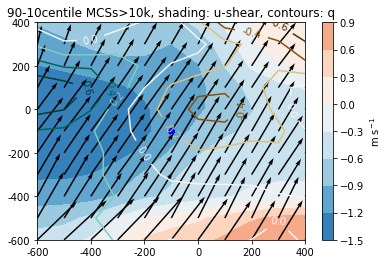

In [631]:
f = plt.figure()
ax = f.add_subplot(111)
plt.contourf((out_strong['u'].sel(level=600).values/cnt_strong[4,:,:])-(out_weak['u'].sel(level=600).values/cnt_weak[4,:,:]), cmap='RdBu_r', vmin=-2, vmax=2)
cbar = plt.colorbar()
cbar.set_label( 'm s$^{-1}$')
plt.title('90-10centile MCSs>10k, shading: u-shear, contours: q')
cs = plt.contour(((out_strong['q'].sel(level=925).values/cnt_strong[4,:,:])-(out_weak['q'].sel(level=925).values)/cnt_weak[4,:,:])*1000, cmap='BrBG', vmin=-0.5, vmax=0.5)
plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
# qu = ax.quiver(xquiv, yquiv, u, v, scale=15)
# qk = plt.quiverkey(qu, 0.9, 0.02,1, '1 m s$^{-1}$',
#                    labelpos='E', coordinates='figure')
# plt.plot(5,5,'bo')
# ax.set_xticklabels([-600, -400, -200, 0, 200, 400, 600])
# ax.set_yticklabels([-600, -400, -200, 0, 200, 400, 600])
plt.savefig(cnst.network_data + 'figs/CLOVER/fig4.png')

[Text(0, 0, '-600'),
 Text(0, 0, '-400'),
 Text(0, 0, '-200'),
 Text(0, 0, '0'),
 Text(0, 0, '200'),
 Text(0, 0, '400')]

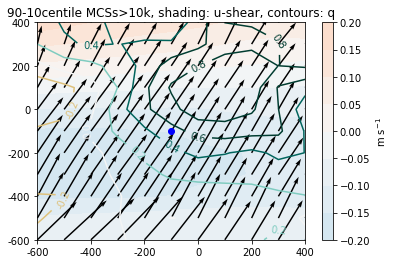

In [641]:
f = plt.figure()
ax = f.add_subplot(111)
plt.contourf((out_strong['u'].sel(level=600).values/cnt_strong[4,:,:])-(out_clim['u'].sel(level=600).values/cnt[4,:,:]), cmap='RdBu_r', vmin=-1, vmax=1)
cbar = plt.colorbar()
cbar.set_label( 'm s$^{-1}$')
plt.title('90-10centile MCSs>10k, shading: u-shear, contours: q')
cs = plt.contour(((out_weak['q'].sel(level=925).values/cnt_weak[4,:,:])-(out_clim['q'].sel(level=925).values)/cnt[4,:,:])*1000, cmap='BrBG', vmin=-0.5, vmax=0.5)
plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
qu = ax.quiver(xquiv, yquiv, u, v, scale=15)
qk = plt.quiverkey(qu, 0.9, 0.02,1, '1 m s$^{-1}$',
                   labelpos='E', coordinates='figure')
plt.plot(5,5,'bo')
ax.set_xticklabels([-600, -400, -200, 0, 200, 400, 600])
ax.set_yticklabels([-600, -400, -200, 0, 200, 400, 600])

In [581]:
out_strong

<xarray.Dataset>
Dimensions:  (level: 6, x: 13, y: 13)
Coordinates:
  * level    (level) int32 600 650 700 850 925 950
Dimensions without coordinates: x, y
Data variables:
    pv       (level, y, x) float64 0.0002355 0.0002368 ... -0.001329 -0.001064
    t        (level, y, x) float64 7.256e+05 7.311e+05 ... 2.706e+06 2.691e+06
    q        (level, y, x) float64 12.69 12.82 12.87 12.9 ... 92.41 91.09 89.68
    w        (level, y, x) float64 -128.9 -124.8 -131.1 ... -341.1 -350.8 -338.4
    d        (level, y, x) float64 0.003611 0.003893 ... -0.03474 -0.0305
    r        (level, y, x) float64 1.754e+05 1.773e+05 ... 3.239e+05 3.185e+05
    u        (level, y, x) float64 -1.876e+04 -1.9e+04 ... -7.997e+03 -8.539e+03
    v        (level, y, x) float64 -1.66e+03 -1.726e+03 ... 1.93e+03 1.631e+03

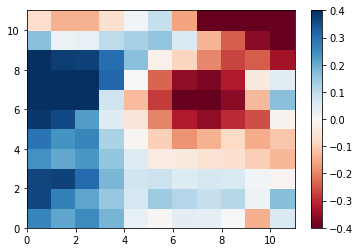

In [653]:
f = plt.figure()
d = (out_strong['q'].sel(level=925).values)/cnt_strong[0,:,:]
c = (out_weak['q'].sel(level=925).values)/cnt_weak[0,:,:]
clim = (out_clim['q'].sel(level=925).values)/cnt[0,:,:]
plt.pcolormesh((d-c)*1000, cmap='RdBu', vmin=-0.4, vmax=0.4)
plt.colorbar()


In [416]:
strong_u = ((out_strong['u'].sel(level=600).values/cnt[4,:,:] - out_strong['u'].sel(level=925).values)/cnt[4,:,:])
weak_u = ((out_weak['u'].sel(level=600).values/cnt[4,:,:] - out_weak['u'].sel(level=925).values)/cnt[4,:,:])
clim_u = ((out_ds['u'].sel(level=600).values/cnt[4,:,:] - out_ds['u'].sel(level=925).values)/cnt[4,:,:])

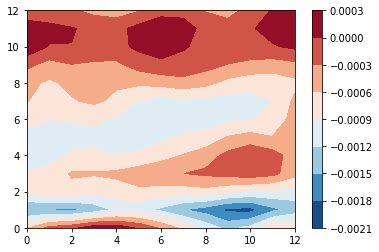

In [419]:
plt.contourf(weak_u, cmap='RdBu_r', )
plt.colorbar()